<font style='color:Blue' size="6"> **P4 -  Anticiper les besoins en consommation électrique de batiments** </font>

___________________________________________________________________________________________________________________ 
___________________________________________________________________________________________________________________ 

# P4_02 - Modélisation Consommation d'énergie, et émissions de Co2 à Seattle
______________________________________________________________________________

# <span style='background :lightgreen' > 1. Contexte  </span>

________________________________________________________

### Mission

_________________________________________________________

La **ville de Seattle** souhaiterait attendre son objectif **neutralité carbone**, d'ici 2050. Afin de limiter les couts liées aux prélèvements des informations des batiments, comme pour celles de 2015 et 2016, des **prévisions** pour les batiments de la ville sont nécessaires.   

Les trois objectifs principaux fixés sont :

- prédire au moyen d'une modélisation : 
 > - les émissions de CO2 (Gaz à Effets de Serre), 
 > - la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.
- Evaluer, pour ces prédictions, la pertinence d'un indicateur d'efficacité énergétique appelé Energy Star Score.

### Approche des étapes

_________________________________________________________


- **Préparation des données pour les rendre applicables aux modèles de machine learning :**

> découpage des **features** en entrée (matrice X) et de la **variable cible** (vecteur y).
> split du jeu de données en jeu d'entraînement (train) et jeu de test (test).
> préparation des **variables quantitatives** : eventuelle standardisation.
> préparation des **variables qualitatives** : enventuelle encodage / standardisation.

- **Modélisation :**

> - Tester différents modèles en utilisant les **hyperparamètres** de base sur la variable cible transformée en log et sur la variable vible non transformée.

> - Conclure de la **performance des modèles**, la variable cible à utiliser : transformée ou non?
> - Sélectionner les **3 modèles** avec les hyperparamètres de base les plus performant.
> - Optimiser les 3 modèles précédemment sélectionnés.

> - Recherche manuelle des hyperparamètres afin d'évaluer les influences sur le modèle en question.
> - Recherche automatique à partir des premières intuitions pour trouver les hyperparamètres les plus performants :
  méthode **GridSearch CV** et **Randomized Search CV**
> - Sélectionner le modèle final le plus performant.

- **Compléments :**

> - Analyser les erreurs de prédictions : sous ou sur estimation, toujours les mêmes bâtiments?
> - Voir les features importance (feature engineering efficace?)

In [1]:
# Chargement des librairies
import datetime
#import jyquickhelper
import numpy as np
import pandas as pd
import pycaret as pyc
import sys
from math import sqrt
import pickle
from pprint import pprint
import mlflow
import time
import shap

# Librairies personnelles
import fonctions_data
import fonctions_models

# Création de pipelines
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

# Feature selection
#import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn import decomposition
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer

# Scoring - cross-validation
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, \
    cross_validate, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, \
    KFold, learning_curve

# Data pré-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder, LabelBinarizer
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import FeatureHasher


# Modélisation
from sklearn import tree
from pycaret.regression import *
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, \
    BayesianRidge, HuberRegressor, OrthogonalMatchingPursuit, Lars
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, \
    ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor, \
    StackingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Warnings
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from dtreeviz.trees import dtreeviz
import seaborn as sns

# Métriques
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer

# Warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=ConvergenceWarning)


#%matplotlib inline
# Chargement à chaud des librairies personnelles
#%load_ext autoreload
#%autoreload 2
# Valide code pep8
#%load_ext pycodestyle_magic
#%pycodestyle_on
#%pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Pycaret               : ' + pyc.__version__)
print('Matplotlib            : ' + mpl.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__)
now = datetime.datetime.now().isoformat()
print('Lancé le              : ' + now)

Version des librairies utilisées :
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.24.3
Pandas                : 1.5.3
Pycaret               : 3.0.4
Matplotlib            : 3.7.1
Seaborn               : 0.12.2
Sklearn               : 1.2.2
Lancé le              : 2023-08-25T15:39:27.903739


# <span style='background :lightgreen' > 2. Chargement du dataset cleané  </span>

In [20]:
data = pd.read_table('data_bat_clean.csv') 
data.drop('Unnamed: 0',axis=1,inplace=True)

In [53]:
data.head()

SiteEnergyUseWN(kBtu)  SiteEnergyUseWNLog  TotalGHGEmissions  \
0              7456910.0            6.872559             249.98   
1              8664479.0            6.937743             295.86   
2             73937112.0            7.868862            2089.28   
3              6946800.5            6.841785             286.43   
4             14656503.0            7.166030             505.01   

   TotalGHGEmissionsLog  ENERGYSTARScore    BuildingType PrimaryPropertyType  \
0              2.399639             60.0  NonResidential               Hotel   
1              2.472552             61.0  NonResidential               Hotel   
2              3.320204             43.0  NonResidential               Hotel   
3              2.458532             56.0  NonResidential               Hotel   
4              2.704159             75.0  NonResidential               Hotel   

   CouncilDistrictCode Neighborhood  NumberofBuildings  ...  Latitude  \
0                    7     DOWNTOWN                  1  ...  47.61220   
1                    7     DOWNTOWN                  1  ...  47.61317   
2                    7     DOWNTOWN                  1  ...  47.61393   
3                    7     DOWNTOWN                  1  ...  47.61412   
4                    7     DOWNTOWN                  1  ...  47.61375   

   ZipCode          Address lat_long_bin Address_type TauxParkingGFA  \
0  98101.0    405 Olive way           40        Other       0.000000   
1  98101.0  724 Pine street           40        Other       0.145453   
2  98101.0  1900 5th Avenue           40        Other       0.205748   
3  98101.0   620 STEWART ST           40       STREET       0.000000   
4  98121.0    401 LENORA ST           40       STREET       0.353115   

  TauxFirstUseGFA  TauxSecondtUseGFA  TauxThirdtUseGFA  BuildingAge  
0        1.000000           0.000000          0.000000           89  
1        0.809918           0.145453          0.044629           20  
2        0.791220           0.000000          0.000000           47  
3        1.000000           0.000000          0.000000           90  
4        0.703070           0.387339          0.000000           36  

[5 rows x 34 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SiteEnergyUseWN(kBtu)         1755 non-null   float64
 1   SiteEnergyUseWNLog            1755 non-null   float64
 2   TotalGHGEmissions             1755 non-null   float64
 3   TotalGHGEmissionsLog          1755 non-null   float64
 4   ENERGYSTARScore               1155 non-null   float64
 5   BuildingType                  1755 non-null   object 
 6   PrimaryPropertyType           1755 non-null   object 
 7   CouncilDistrictCode           1755 non-null   int64  
 8   Neighborhood                  1755 non-null   object 
 9   NumberofBuildings             1755 non-null   int64  
 10  NumberofFloors                1755 non-null   int64  
 11  PropertyGFATotal              1755 non-null   int64  
 12  PropertyGFABuilding(s)        1755 non-null   int64  
 13  Lis

In [21]:
data['ENERGYSTARScore'] = data['ENERGYSTARScore'].fillna(data['ENERGYSTARScore'].mean())
data['ListOfAllPropertyUseTypes'] = data['ListOfAllPropertyUseTypes'].fillna(data['ListOfAllPropertyUseTypes'].mode()[0])
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna(data['LargestPropertyUseType'].mode()[0])
data['ZipCode'] = data['ZipCode'].fillna(data['ZipCode'].mode()[0])

In [22]:
data.isna().sum()

SiteEnergyUseWN(kBtu)           0
SiteEnergyUseWNLog              0
TotalGHGEmissions               0
TotalGHGEmissionsLog            0
ENERGYSTARScore                 0
BuildingType                    0
PrimaryPropertyType             0
CouncilDistrictCode             0
Neighborhood                    0
NumberofBuildings               0
NumberofFloors                  0
PropertyGFATotal                0
PropertyGFABuilding(s)          0
ListOfAllPropertyUseTypes       0
LargestPropertyUseType          0
SecondLargestPropertyUseType    0
ThirdLargestPropertyUseType     0
SteamUse(kBtu)                  0
Electricity(kBtu)               0
NaturalGas(kBtu)                0
OtherFuelUse(kBtu)              0
Comments                        0
Outlier                         0
Longitude                       0
Latitude                        0
ZipCode                         0
Address                         0
lat_long_bin                    0
Address_type                    0
TauxParkingGFA

# <span style='background :lightgreen' > 3. Première approche sur les modèles avec PyCaret  </span>

La démarche d'utilisation de pycaret est :

- d'effectuer une première exploration sur les modèles avec les hyperparamètres de base, 
- et d'observer l'impact sur des métriques en fonction du feature engineering effectué, sur les différents modèles proposés :
> - des données en entrée **SANS l'usage des caractéristiques** en entrée (features engineering),
> - des données en entrée **AVEC l'usage des caractéristiques** en entrée (features engineering). 

**Pycaret SANS les variables caractéristiques en entrée**

In [8]:
# Sans les variables ajoutées lors du feature engineering
data_pycaret_nofeature = data.copy()
data_pycaret_nofeature.drop(['ENERGYSTARScore', 'TotalGHGEmissions','SiteEnergyUseWNLog',
                             'TotalGHGEmissionsLog', 'lat_long_bin', 'Address_type',
                             'BuildingAge','SteamUse(kBtu)', 'Electricity(kBtu)',
                             'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)','TauxParkingGFA',
                             'TauxFirstUseGFA','TauxSecondtUseGFA','TauxThirdtUseGFA'
                              ], 1, inplace=True)

In [9]:
data_pycaret_nofeature.columns.to_list()

['SiteEnergyUseWN(kBtu)',
 'BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Comments',
 'Outlier',
 'Longitude',
 'Latitude',
 'ZipCode',
 'Address']

In [9]:
# Initialisation 
reg_exp = setup(data_pycaret_nofeature,
                       target='SiteEnergyUseWN(kBtu)',
                       session_id=123,
                       log_experiment=False,
                       experiment_name='cons_energie')

In [11]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés sur 
# notre environnement de développement
best_model = compare_models()

In [9]:
# Meilleur modèle ?
print(best_model)

LGBMRegressor(n_jobs=-1, random_state=123)


In [13]:
# Sans les variables ajoutées lors du feature engineering
data_pycaret_nofeature_v2 = data.copy()
data_pycaret_nofeature_v2.drop(['ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)','SiteEnergyUseWNLog',
                             'TotalGHGEmissionsLog', 'lat_long_bin', 'Address_type',
                             'BuildingAge','SteamUse(kBtu)', 'Electricity(kBtu)',
                             'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)','TauxParkingGFA',
                             'TauxFirstUseGFA','TauxSecondtUseGFA','TauxThirdtUseGFA'
                              ], 1, inplace=True)

In [14]:
data_pycaret_nofeature_v2.columns.to_list()

['TotalGHGEmissions',
 'BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Comments',
 'Outlier',
 'Longitude',
 'Latitude',
 'ZipCode',
 'Address']

In [16]:
# Initialisation 
reg_exp = setup(data_pycaret_nofeature_v2,
                       target='TotalGHGEmissions',
                       session_id=123,
                       log_experiment=False,
                       experiment_name='total_emissions')

In [17]:
# Compraraison modèles sur la variable TotalEmissions
best_model = compare_models()

In [ ]:
# Meilleur modèle ?
print(best_model)

**Pycaret avec les variables en entrées du feature engineering**

In [46]:
#Avec les variables ajoutées lors du feature engineering
data_pycaret = data.copy()
data_pycaret.drop(['ENERGYSTARScore', 'SiteEnergyUseWNLog',
                   'TotalGHGEmissions', 'TotalGHGEmissionsLog'], 1, inplace=True)

In [47]:
data_pycaret.columns.to_list()

['SiteEnergyUseWN(kBtu)',
 'BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'OtherFuelUse(kBtu)',
 'Comments',
 'Outlier',
 'Longitude',
 'Latitude',
 'ZipCode',
 'Address',
 'lat_long_bin',
 'Address_type',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'TauxThirdtUseGFA',
 'BuildingAge']

In [48]:
# Initialisation
reg_experiment = setup(data_pycaret,
                       target='SiteEnergyUseWN(kBtu)',
                       session_id=21,
                       log_experiment=False,
                       experiment_name='cons_energie')

In [49]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés sur 
# notre environnement de développement
best_model = compare_models()

In [20]:
# Meilleur modèle ?
print(best_model)

**PyCaret avec les toutes nos variables d'entrée (feature engineering)**

In [52]:
#Avec toutes les variables ajoutées lors du feature engineering
data_pycaret = data.copy()

In [53]:
data_pycaret.columns.to_list()

['SiteEnergyUseWN(kBtu)',
 'SiteEnergyUseWNLog',
 'TotalGHGEmissions',
 'TotalGHGEmissionsLog',
 'ENERGYSTARScore',
 'BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'OtherFuelUse(kBtu)',
 'Comments',
 'Outlier',
 'Longitude',
 'Latitude',
 'ZipCode',
 'Address',
 'lat_long_bin',
 'Address_type',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'TauxThirdtUseGFA',
 'BuildingAge']

In [54]:
# Initialisation
reg_experiment = setup(data_pycaret,
                       target='SiteEnergyUseWN(kBtu)',
                       session_id=21,
                       log_experiment=False,
                       experiment_name='cons_energie')

In [55]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés sur 
# notre environnement de développement
best_model = compare_models()

In [56]:
# Meilleur modèle ?
print(best_model)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=21, ...)


In [68]:
# Sauvegarde du modèle de comparaison de compare_models() en dataframe.
df = pull()

In [70]:
df_top3 = df.head(3)
df_top3

Model          MAE           MSE          RMSE  \
xgboost    Extreme Gradient Boosting  220289.3820  1.929823e+12  1.034154e+06   
gbr      Gradient Boosting Regressor  609367.7366  3.235974e+13  3.331225e+06   
rf           Random Forest Regressor  820417.8483  5.314589e+13  4.764055e+06   

             R2   RMSLE    MAPE  TT (Sec)  
xgboost  0.9955  1.3366  0.0293     1.028  
gbr      0.9644  1.4171  0.0373     0.986  
rf       0.9295  1.3441  0.0489     1.025

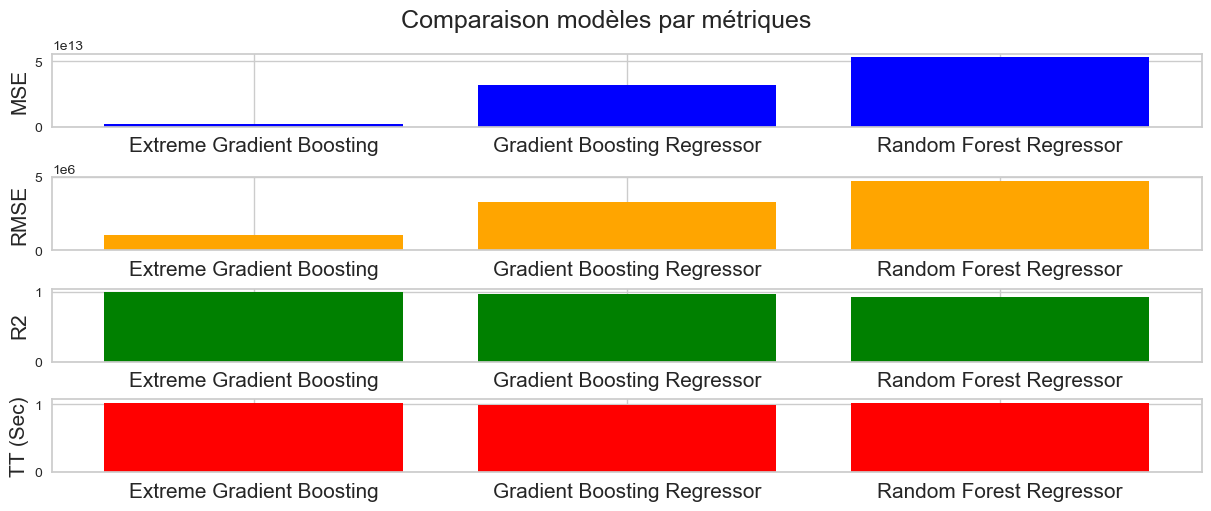

In [77]:
# Comparaison des mértiques

fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(12, 5))
fig.suptitle("Comparaison modèles par métriques", fontsize=18)

axs[0].set_ylabel("MSE", fontsize=15)
axs[0].bar(df_top3['Model'], height=df_top3['MSE'], color='blue')
axs[0].tick_params(axis='x', labelsize=15)

axs[1].set_ylabel("RMSE", fontsize=15)
axs[1].bar(df_top3['Model'], height=df_top3['RMSE'], color='orange')
axs[1].tick_params(axis='x', labelsize=15)

axs[2].set_ylabel("R2", fontsize=15)
axs[2].bar(df_top3['Model'], height=df_top3['R2'], color='green')
axs[2].tick_params(axis='x', labelsize=15)

axs[3].set_ylabel("TT (Sec)", fontsize=15)
axs[3].bar(df_top3['Model'], height=df_top3['TT (Sec)'], color='red')
axs[3].tick_params(axis='x', labelsize=15)

plt.show()

**Constation**
- On constate que les modèles dits **ensemblistes** sont plus performants que les modèles de **regression**. En effet, ceux sélectionnés: 'catboost', et 'xgboost' sont basés sur la méthode du boosting (méthode ensembliste séquentielle)
- les modèles sont tous plus **performants** en présence des variables issues du **feature engineering**.


In [31]:
#Avec les variables ajoutées lors du feature engineering
data_pycaret_v2 = data.copy()
data_pycaret_v2.drop(['ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 
                      'SiteEnergyUseWNLog','TotalGHGEmissionsLog'], 1, inplace=True)

In [32]:
data_pycaret_v2.columns.to_list()

['TotalGHGEmissions',
 'BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'OtherFuelUse(kBtu)',
 'Comments',
 'Outlier',
 'Longitude',
 'Latitude',
 'ZipCode',
 'Address',
 'lat_long_bin',
 'Address_type',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'TauxThirdtUseGFA',
 'BuildingAge']

In [33]:
# Initialisation
reg_experiment = setup(data_pycaret_v2,
                       target='TotalGHGEmissions',
                       session_id=21,
                       log_experiment=False,
                       experiment_name='total_emissions')

In [34]:
best_model = compare_models()

# <span style='background :lightgreen' > 4. Pré-traitement des données  </span>

## <span style='background :lightblue' > 4.1 Matrice X, et variable cible y  </span>

In [23]:
# Copie du jeu de données
data_prepro = data.copy()

**Energy Score**

In [24]:
# Variables cibles
cols_target = data_prepro.columns[0:4].to_list()
cols_target

['SiteEnergyUseWN(kBtu)',
 'SiteEnergyUseWNLog',
 'TotalGHGEmissions',
 'TotalGHGEmissionsLog']

**Catégorisation des variables**

In [25]:
# Variables prédictives
y_labels = ["SiteEnergyUseWN(kBtu)",
            "TotalGHGEmissions"]


# Variables catégorielles
cols_cat = list(data_prepro.select_dtypes(include='object').columns)

# Variables numériques
cols_num = list(data_prepro.drop(columns=cols_cat + cols_target  + ["ENERGYSTARScore"]).columns)

# Liste des types d'énergie
list_energy_type = ["Electricity(kBtu)",
                    "NaturalGas(kBtu)",
                    "SteamUse(kBtu)",
                    "OtherFuelUse(kBtu)"]

**Matrice X**

In [26]:
# Matrice X
X = data_prepro[cols_cat+cols_num]
X.shape

(1755, 29)

**Variable cible (vecteur y)**

Sur les 2 variables cibles, on prend une transformée en log, et l'autre non, afin d'évaluer l'influence sur le modèle, en terme de performance, et d'erreur.

In [27]:
# Analyse de la target 'SiteEnergyUseWN' non transformée
y = data_prepro['SiteEnergyUseWN(kBtu)']
y.shape

(1755,)

In [28]:
# Analyse de la target 'SiteEnergyUseWNLog' transformée en logarithme
y_log = data_prepro['SiteEnergyUseWNLog']
y_log.shape

(1755,)

In [29]:
# Analyse de la target 'TotalGHGEmissions' transformée en logarithme
y_log_Co2 = data_prepro['TotalGHGEmissionsLog']
y_log_Co2.shape

(1755,)

In [30]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21
print(f'Nombre aléatoire : {seed}')

Nombre aléatoire : 21


## <span style='background :lightblue' > 4.2 Séparation données d'entrainement, et test  </span>

Plusieurs jeux de données sont préparés pour les modèles de machine learning :

- Pour voir **l'effet de la transformation logarithmique** de la variable cible sur la performance des modèles :

> - **(a)** un découpage pour la variable cible non transformée
> - **(b)** un découpage pour la variable cible transformée
- pour le **modèle XGBoostRegressor** qui peut gérer lui-même l'encodage des variables catégorielles et voir l'impact de la standardisation :

> - **(c)** un découpage pour la variable cible transformée avec encodage non standardisée
> - **(d)** un découpage pour la variable cible transformée sans encodage non standardisée
> - **(e)** un découpage pour la variable cible transformée sans encodage standardisée
pour voir l'effet de la transformation logarithmique de la variable cible sur la performance des modèles

**(a) Target SiteEnergyUseWN**

In [31]:
# Découpage du jeu de données en train set et test set cible non transformée
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)
print(f'X_train : {X_train.shape} - X_test : {X_test.shape}')
print(f'y_train : {y_train.shape} - y_test : {y_test.shape}')

X_train : (1404, 29) - X_test : (351, 29)
y_train : (1404,) - y_test : (351,)


**(b) Target SiteEnergyUseWNLog (Target SiteEnergyUseWN transformée en log10 + 1)**

In [49]:
# Découpage du jeu de données en train set et test set cilble transformée
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=seed)
print(f'X_train_log : {X_train_log.shape} - X_test_log : {X_test_log.shape}')
print(f'y_train_log : {y_train_log.shape} - y_test_log : {y_test_log.shape}')

X_train_log : (1404, 29) - X_test_log : (351, 29)
y_train_log : (1404,) - y_test_log : (351,)


In [13]:
# Découpage du jeu de données en train set et test set cilble transformée
X_train_log_Co2, X_test_log_Co2, y_train_log_Co2, y_test_log_Co2 = train_test_split(
    X, y_log_Co2, test_size=0.2, random_state=seed)
print(f'X_train_log_Co2 : {X_train_log_Co2.shape} - X_test_log_Co2 : {X_test_log_Co2.shape}')
print(f'y_train_log_Co2 : {y_train_log_Co2.shape} - y_test_log_Co2 : {y_test_log_Co2.shape}')

X_train_log_Co2 : (1404, 29) - X_test_log_Co2 : (351, 29)
y_train_log_Co2 : (1404,) - y_test_log_Co2 : (351,)


In [25]:
# Utilisation de TargetEncoder()
target_encoder = TargetEncoder()

# Encodage des données de consommation d'énergie non transformée en log10
X_train[cols_cat] = target_encoder.fit_transform(X_train[cols_cat], y_train)
X_test[cols_cat] = target_encoder.transform(X_test[cols_cat])

# Sauvegarde de l'encodeur
# with open('modeles/encoder_target.pickle', 'wb') as f:
#     pickle.dump(target_encoder, f, pickle.HIGHEST_PROTOCOL)

In [33]:
# Encodage des données de consommation d'énergie transformée en log10
target_encoder = TargetEncoder()
X_train_log[cols_cat] = target_encoder.fit_transform(
    X_train_log[cols_cat], y_train_log)
X_test_log[cols_cat] = target_encoder.transform(X_test_log[cols_cat])


In [15]:
# Encodage des données de consommation d'énergie transformée en log10
target_encoder = TargetEncoder()
X_train_log_Co2[cols_cat] = target_encoder.fit_transform(
    X_train_log_Co2[cols_cat], y_train_log_Co2)
X_test_log_Co2[cols_cat] = target_encoder.transform(X_test_log_Co2[cols_cat])


## <span style='background :lightblue' > 4.3 Standardisation des variables quantitatives  </span>

In [18]:
# RobustScaler
scaler_rob = RobustScaler()

# Jeu de la target de consommation d'énergie non transformée en log10
X_train[cols_num] = scaler_rob.fit_transform(X_train[cols_num].copy(deep=True))
X_test[cols_num] = scaler_rob.transform(X_test[cols_num].copy(deep=True))

In [34]:
# Jeu de la target de consommation d'énergie transformée en log10
scaler_rob = RobustScaler()
X_train_log[cols_num] = scaler_rob.fit_transform(
    X_train_log[cols_num].copy(deep=True))
X_test_log[cols_num] = scaler_rob.transform(
    X_test_log[cols_num].copy(deep=True))

# <span style='background :lightgreen' > 5. Evaluation de différents modèles de Machine Learning  </span>

Le but de cette partie est d'évaluer, avec leurs hyperparamètres par défaut tout en effectuant de la cross-validation, sur les 3 algorithmes non optimisés les plus performants pour notre problématique.

## <span style='background :gold' >  GradientBoosting  </span>

### <span style='background : navajowhite' >  Influence des paramètres </span>

In [17]:
# Paramètres de base d'un algorthme GradientBoostRegressor
print('Les paramètres par défaut:\n')
gbr_param = GradientBoostingRegressor(random_state=21)
pprint(gbr_param.get_params())

Les paramètres par défaut:

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 21,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [50]:
# # Paramètres de base d'un algorthme RandomForestRegressor
# print('Les paramètres par défaut:\n')
# rf_param = RandomForestRegressor(random_state=21)
# pprint(rf_param.get_params())

In [18]:
# DataFrame sauvegardant les résultats pour les différents essais d'optimisation
df_resultats_gb = pd.DataFrame(dtype='object')

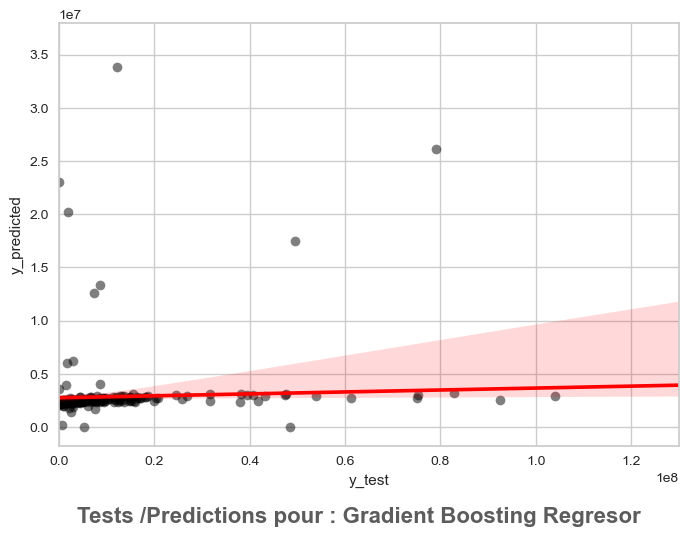

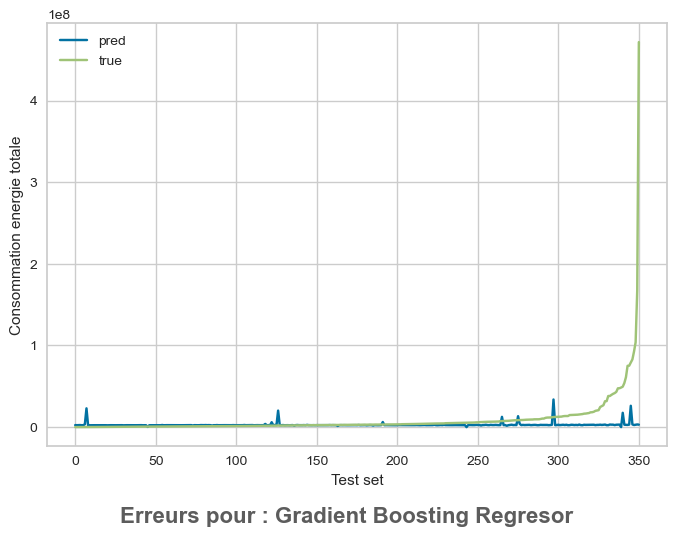

In [68]:
# 
# -----------------------------------------------------------------------
gb =  GradientBoostingRegressor(n_estimators=100)
# BASELINE POUR COMPARAISON FINALE
df_resultats_top3, y_pred = fonctions_models.process_regression(gb,
                                                            X_train_log, X_test_log,
                                                            y_train_log, y_test_log,
                                                            df_resultats_gb,
                                                            'Gradient Boosting Regresor')

### <span style='background : navajowhite' >  Découvrte des hyperparamètres </span>

**Hyperparamètre : n_estimators**

**n_estimators** int, default=100 - Le nombre d'étapes de boosting à exécuter. Le boosting de gradient est assez robuste à l'ajustement excessif, donc un grand nombre donne généralement de meilleures performances.

Hyperparam Test R2 +/- std Train R2 +/- std
>10 0.70841 (0.10082) 0.83870 (0.00723)
>50 0.79726 (0.17801) 0.99291 (0.00133)
>100 0.79489 (0.17854) 0.99642 (0.00062)
>500 0.78738 (0.19102) 0.99972 (0.00005)
>1000 0.78661 (0.19138) 0.99995 (0.00001)
>2000 0.78649 (0.19140) 1.00000 (0.00000)
>3000 0.78650 (0.19139) 1.00000 (0.00000)


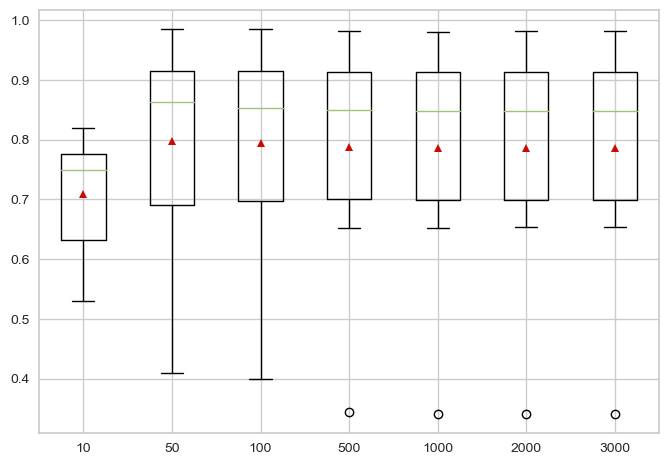

In [33]:
# Variables encodées et standardisées
n_estimators = [10, 50, 100, 500, 1000, 2000, 3000]
fonctions_models.regle_gradboost_nestimators(
    n_estimators, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>80 0.79553 (0.17956) 0.99560 (0.00073)
>90 0.79494 (0.17991) 0.99607 (0.00064)
>100 0.79489 (0.17854) 0.99642 (0.00062)
>110 0.79461 (0.17854) 0.99671 (0.00057)
>120 0.79423 (0.17869) 0.99701 (0.00051)
>130 0.79413 (0.17876) 0.99722 (0.00048)
>140 0.79365 (0.18020) 0.99746 (0.00043)
>150 0.79279 (0.18128) 0.99764 (0.00041)


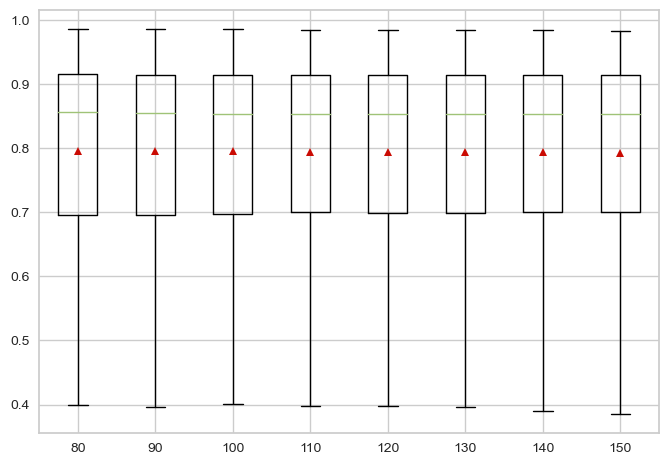

In [40]:
# Variables encodées et standardisées
n_estimators = [80, 90, 100, 110, 120, 130, 140, 150]
fonctions_models.regle_gradboost_nestimators(
    n_estimators, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **n_estimators = 80**
> - Fourchette de recherche : n_estimators = [70, 80, 100]

**Hyperparamètre : max_features**

**max_features** {“auto”, “sqrt”, “log2”}, int or float, default=”auto” - Le nombre de caractéristiques à prendre en compte lors de la recherche du meilleur split

Hyperparam Test R2 +/- std Train R2 +/- std
>auto 0.79489 (0.17854) 0.99642 (0.00062)
>sqrt 0.80786 (0.13552) 0.97707 (0.00223)
>log2 0.79906 (0.12884) 0.96721 (0.00324)
>1 0.60584 (0.14029) 0.81742 (0.01468)
>2 0.75682 (0.10993) 0.91989 (0.00687)
>3 0.81745 (0.08209) 0.95908 (0.00312)
>4 0.79906 (0.12884) 0.96721 (0.00324)
>5 0.80786 (0.13552) 0.97707 (0.00223)
>6 0.84084 (0.11263) 0.98110 (0.00266)
>7 0.84075 (0.14094) 0.98434 (0.00177)
>8 0.83443 (0.15444) 0.98596 (0.00225)
>9 0.85869 (0.13242) 0.98854 (0.00112)
>10 0.85627 (0.13544) 0.99107 (0.00120)
>11 0.82896 (0.16869) 0.99059 (0.00187)
>12 0.84332 (0.15216) 0.99048 (0.00132)
>13 0.83720 (0.16271) 0.99185 (0.00162)
>14 0.83294 (0.16813) 0.99215 (0.00155)
>15 0.83283 (0.16760) 0.99310 (0.00128)
>16 0.82384 (0.17494) 0.99326 (0.00122)
>17 0.83351 (0.16251) 0.99394 (0.00124)
>18 0.82329 (0.17251) 0.99412 (0.00133)
>19 0.80883 (0.18144) 0.99510 (0.00101)
>20 0.81225 (0.17767) 0.99515 (0.00098)


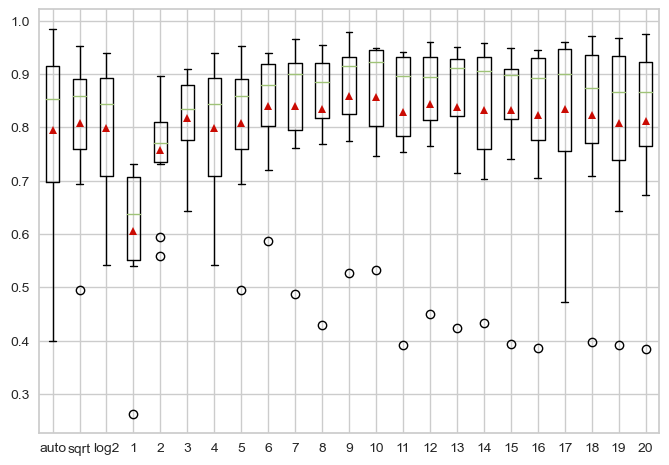

In [35]:
max_features = ['auto', 'sqrt', 'log2', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                12, 13, 14, 15, 16, 17, 18, 19, 20]
fonctions_models.regle_gradboost_maxfeatures(
    max_features, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **max_features** = 9
> - Fourchette de recherche : max_features': ['8', '9', '10', '11']

**Hyperparamètre : learning_rate**

**learning_rate** - float, default=0.1 - Le taux d'apprentissage réduit la contribution de chaque arbre par le taux d'apprentissage. Il existe un compromis entre le taux d'apprentissage et les n_estimators.

Hyperparam Test R2 +/- std Train R2 +/- std
>0.001 0.12365 (0.04456) 0.16769 (0.00205)
>0.01 0.70102 (0.09123) 0.82652 (0.00741)
>0.03 0.81710 (0.16520) 0.98315 (0.00301)
>0.05 0.80453 (0.17851) 0.99298 (0.00117)
>0.08 0.80098 (0.17985) 0.99564 (0.00071)
>0.1 0.79489 (0.17854) 0.99642 (0.00062)
>0.11 0.79434 (0.17594) 0.99678 (0.00052)
>0.12 0.80801 (0.18774) 0.99704 (0.00049)
>0.13 0.78957 (0.18313) 0.99723 (0.00046)
>0.14 0.80233 (0.18334) 0.99742 (0.00053)
>0.15 0.79376 (0.19064) 0.99760 (0.00041)
>0.2 0.78124 (0.18840) 0.99824 (0.00027)
>0.3 0.77647 (0.20956) 0.99895 (0.00019)


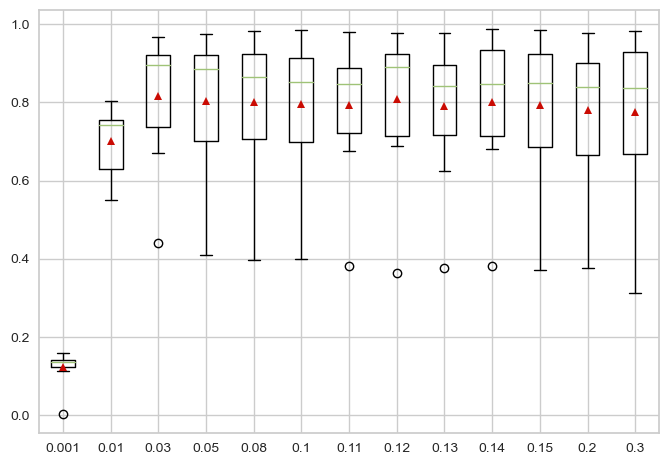

In [49]:
learning_rate = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.11, 0.12, 0.13, 0.14,
                 0.15, 0.2, 0.3]
fonctions_models.regle_gradboost_learningrate(
    learning_rate, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **learning_rate** = 0.03
> - Fourchette de recherche : [0.01, 0.03, 0.05, 0.08]

**Hyperparamètre : criterion**

**criterion** - {‘friedman_mse’, ‘mse’}, default=’friedman_mse’ - La fonction permettant de mesurer la qualité d'un fractionnement. Les critères supportés sont "friedman_mse" pour l'erreur quadratique moyenne avec score d'amélioration par Friedman, "mse" pour l'erreur quadratique moyenne

Hyperparam Test R2 +/- std Train R2 +/- std
>squared_error 0.79263 (0.17896) 0.99642 (0.00062)
>friedman_mse 0.79489 (0.17854) 0.99642 (0.00062)


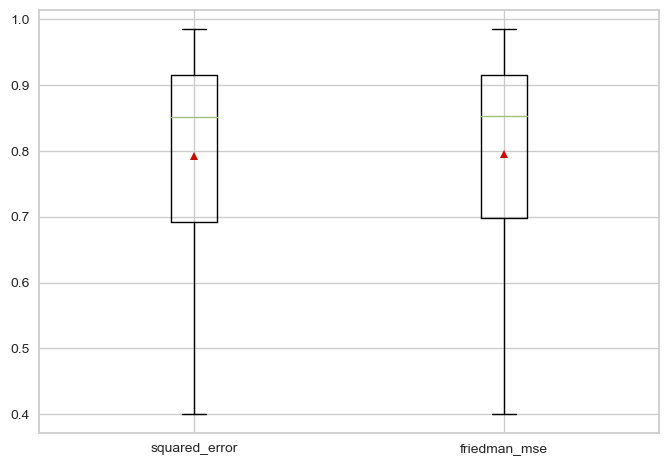

In [56]:
criterion = ['squared_error', 'friedman_mse']
fonctions_models.regle_gradboost_criterion(criterion, X_train_log, y_train_log)

**Constat :**

> - **criterion** : pas d'impact ? Laisse la valeur par défaut.

**Hyperparamètre : max_depth**

**max_depth** - int, default=3 - Profondeur maximale des estimateurs de régression individuels. La profondeur maximale limite le nombre de nœuds dans l'arbre. Réglez ce paramètre pour obtenir les meilleures performances ; la meilleure valeur dépend de l'interaction des variables d'entrée.

Hyperparam Test R2 +/- std Train R2 +/- std
>1 0.85837 (0.11793) 0.92990 (0.00792)
>2 0.81359 (0.16771) 0.98223 (0.00484)
>3 0.79489 (0.17854) 0.99642 (0.00062)
>4 0.74501 (0.23801) 0.99861 (0.00025)
>5 0.75743 (0.25274) 0.99950 (0.00007)
>10 0.71599 (0.25678) 1.00000 (0.00000)


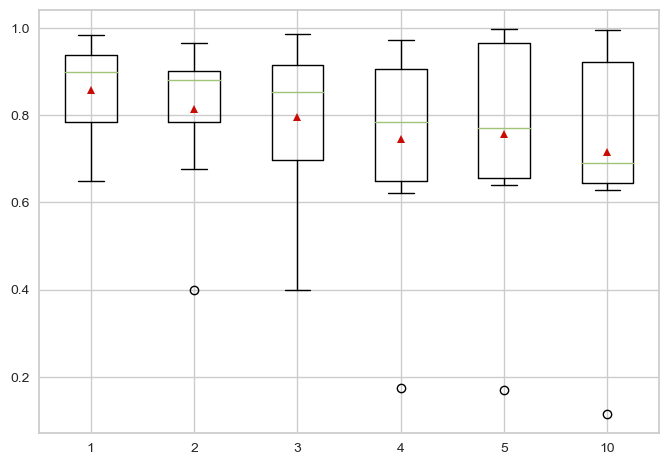

In [57]:
max_depth = [1, 2, 3, 4, 5, 10]
fonctions_models.regle_gradboost_maxdepth(max_depth, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **max_depth = 1** (valeur par défaut)
> - Fourchette de recherche : max_depth = [1, 2, 3]

**Hyperparamètre : min_samples_split**

**min_samples_split** - int or float, default=2 - Le nombre minimum d'échantillons requis pour diviser un nœud interne.

Hyperparam Test R2 +/- std Train R2 +/- std
>2 0.79489 (0.17854) 0.99642 (0.00062)
>3 0.78957 (0.18334) 0.99641 (0.00060)
>4 0.79755 (0.17639) 0.99637 (0.00064)
>5 0.80415 (0.16823) 0.99606 (0.00077)
>6 0.80541 (0.16738) 0.99579 (0.00092)
>7 0.81454 (0.14373) 0.99562 (0.00087)
>8 0.81215 (0.13969) 0.99546 (0.00090)
>9 0.81111 (0.14924) 0.99520 (0.00109)
>10 0.80050 (0.15155) 0.99510 (0.00110)
>11 0.79819 (0.15762) 0.99502 (0.00116)
>12 0.79670 (0.15544) 0.99500 (0.00123)
>13 0.79657 (0.15576) 0.99484 (0.00137)
>14 0.79362 (0.14962) 0.99465 (0.00138)
>15 0.79953 (0.15230) 0.99474 (0.00124)
>16 0.79643 (0.15302) 0.99458 (0.00149)
>17 0.79982 (0.15310) 0.99459 (0.00132)
>18 0.79908 (0.15504) 0.99432 (0.00151)
>19 0.80155 (0.15721) 0.99394 (0.00195)
>20 0.80806 (0.16000) 0.99375 (0.00217)
>21 0.80474 (0.15965) 0.99385 (0.00192)
>22 0.79572 (0.16418) 0.99364 (0.00176)
>23 0.79606 (0.16592) 0.99340 (0.00188)
>24 0.79615 (0.16685) 0.99331 (0.00176)
>25 0.78683 (0.16103) 0.99300 (0.00189)
>26 

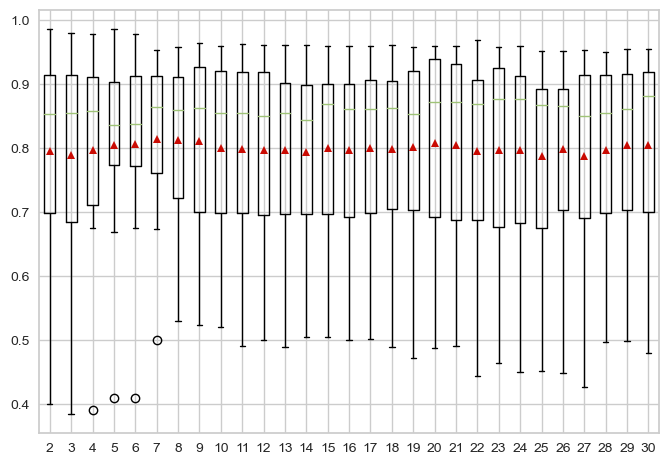

In [58]:
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                     17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
fonctions_models.regle_gradboost_minsamplessplit(
    min_samples_split, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **min_samples_split = 7**
> - Foruchette de recherche : min_samples_split = [5, 6, 7, 8, 9]

**Hyperparamètre : min_samples_leaf**

**min_samples_leaf** - int or float, default=1 - Le nombre minimum d'échantillons requis pour se trouver à un nœud de feuille.

Hyperparam Test R2 +/- std Train R2 +/- std
>1 0.79489 (0.17854) 0.99642 (0.00062)
>5 0.83688 (0.19477) 0.99048 (0.00213)
>10 0.84039 (0.17075) 0.98096 (0.00421)
>15 0.84548 (0.16329) 0.96412 (0.00772)
>20 0.84402 (0.16199) 0.95168 (0.01042)
>25 0.84408 (0.20949) 0.93306 (0.00959)
>30 0.84585 (0.17500) 0.91469 (0.01014)


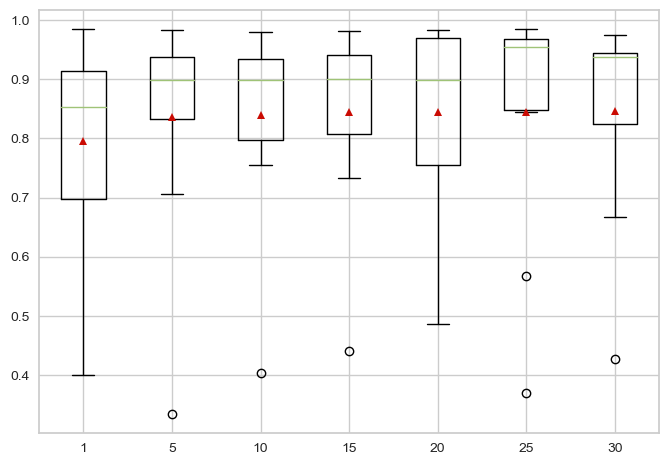

In [59]:
min_samples_leaf = [1, 5, 10, 15, 20, 25, 30]
fonctions_models.regle_gradboost_minsamplesleaf(min_samples_leaf, X_train_log,
                                            y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>10 0.84039 (0.17075) 0.98096 (0.00421)
>11 0.83776 (0.17520) 0.97827 (0.00466)
>12 0.84054 (0.17270) 0.97470 (0.00601)
>13 0.83917 (0.16426) 0.97122 (0.00632)
>14 0.84675 (0.16714) 0.96713 (0.00738)
>15 0.84548 (0.16329) 0.96412 (0.00772)


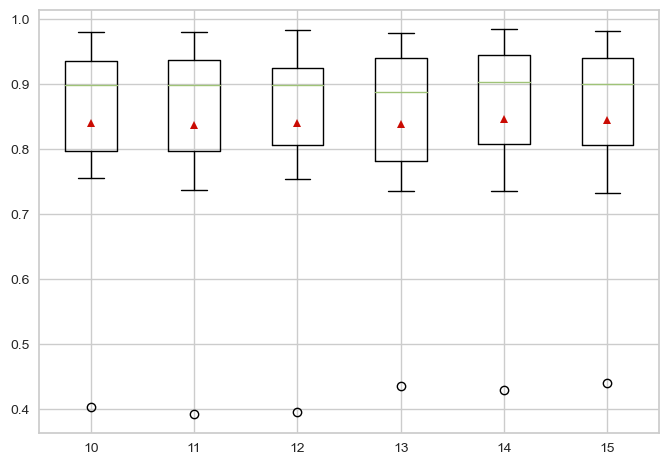

In [62]:
min_samples_leaf = [10, 11, 12, 13, 14, 15]
fonctions_models.regle_gradboost_minsamplesleaf(min_samples_leaf, X_train_log,
                                            y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>1 0.79489 (0.17854) 0.99642 (0.00062)
>2 0.82276 (0.17767) 0.99543 (0.00079)
>3 0.82389 (0.18997) 0.99373 (0.00114)
>4 0.82337 (0.19665) 0.99168 (0.00204)
>5 0.83688 (0.19477) 0.99048 (0.00213)


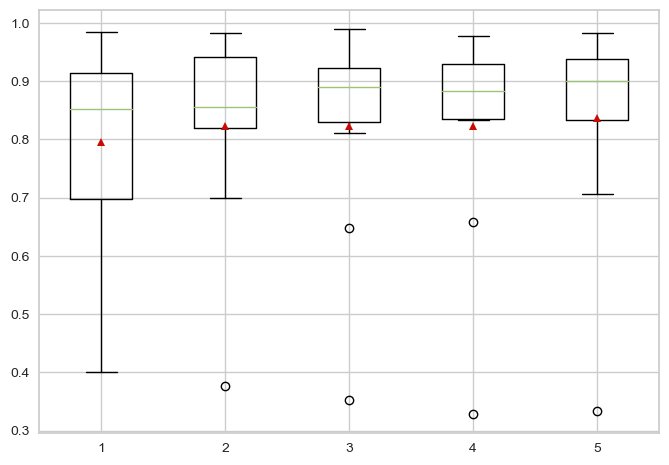

In [61]:
min_samples_leaf = [1, 2, 3, 4, 5]
fonctions_models.regle_gradboost_minsamplesleaf(min_samples_leaf, X_train_log,
                                            y_train_log)

**Constat :**

> - Meilleur résultat : **min_samples_leaf = 15**
> - Fourchette de recherche : min_samples_leaf = [13, 14, 15]

**Entrainement et prédictions pour l'ensemble des valeurs des hyperparamètres trouvées**

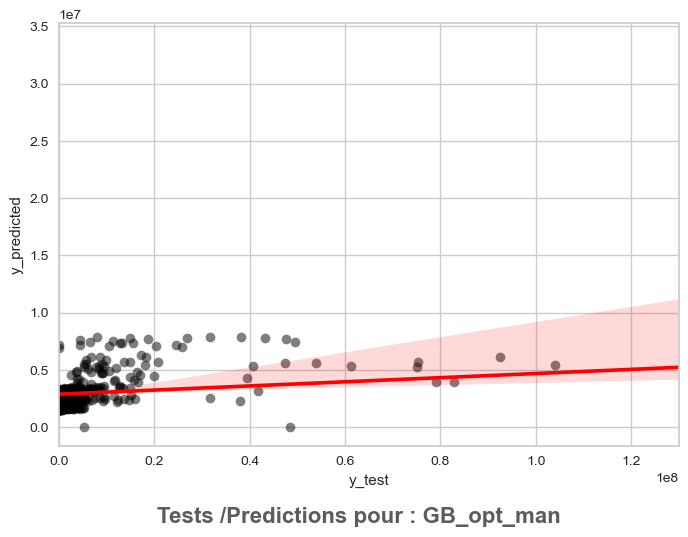

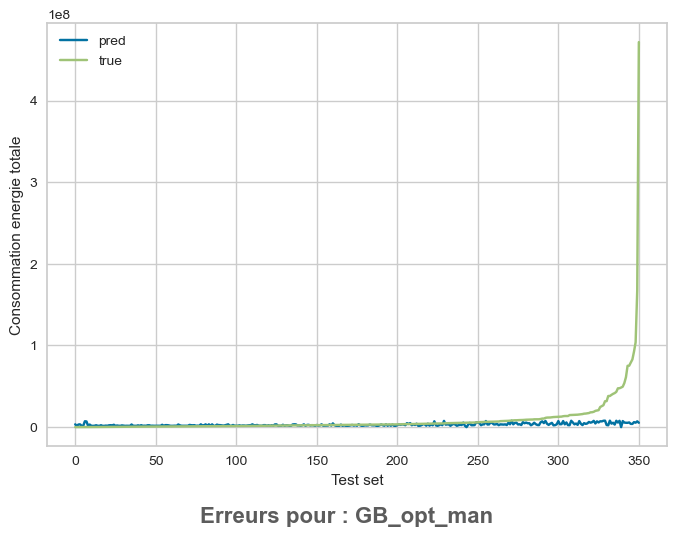

In [36]:
# Entrainement et prédictions pour l'ensemble des valeurs des hyperparamètres
# trouvées et conseiller par le guide utilisateur
model_gb_manuel = GradientBoostingRegressor(n_estimators=80,
                                            learning_rate = 0.03,
                                            max_depth = 1,
                                            min_samples_split = 7,
                                            min_samples_leaf = 15,
                                            max_features =9,
                                            random_state=seed
                                            )
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné 
# avec la variable cible transformée en log10 + 1
df_resultats_gb, y_pred_gb_man = fonctions_models.process_regression(model_gb_manuel,
                                                                 X_train_log, X_test_log,
                                                                 y_train_log, y_test_log,
                                                                 df_resultats_gb,
                                                                 'GB_opt_man')

## <span style='background :gold' >  Extreme GradientBoosting  </span>

### <span style='background : navajowhite' >  Influence des paramètres </span>

In [68]:
# Paramètres de base d'un algorthme GradientBoostRegressor
print('Les paramètres par défaut:\n')
xgbr_param = XGBRegressor(random_state=21)
pprint(xgbr_param.get_params())

Les paramètres par défaut:

{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'reg:squarederror',
 'predictor': None,
 'random_state': 21,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


In [69]:
# DataFrame sauvegardant les résultats pour les différents essais d'optimisation
df_resultats_xgb = pd.DataFrame(dtype='object')

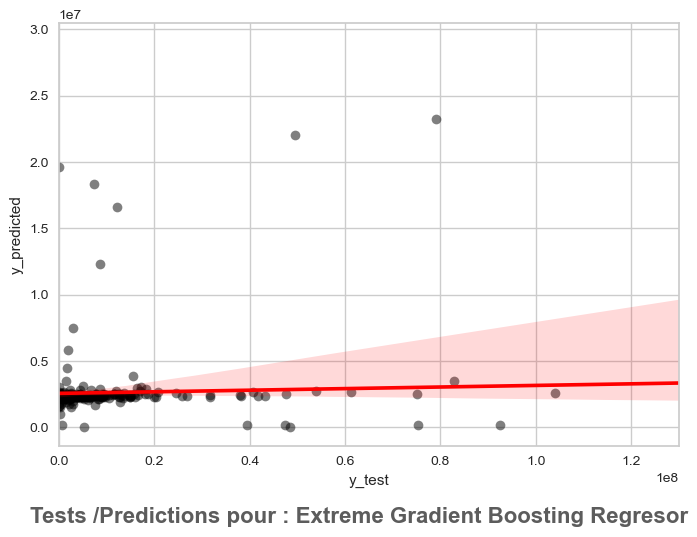

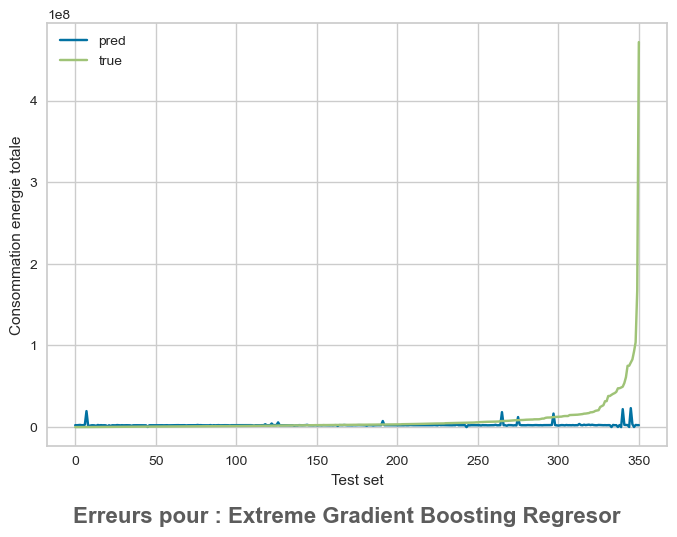

In [79]:
# 
# -----------------------------------------------------------------------
xgb =  XGBRegressor(n_estimators=100)
# BASELINE POUR COMPARAISON FINALE
df_resultats_xgb, y_pred = fonctions_models.process_regression(xgb,
                                                            X_train_log, X_test_log,
                                                            y_train_log, y_test_log,
                                                            df_resultats_xgb,
                                                            'Extreme Gradient Boosting Regresor')

### <span style='background : navajowhite' >  Découvrte des hyperparamètres </span>

**Hyperparamètre : n_estimators**

**n_estimators** int, default=100 - Le nombre d'étapes de boosting à exécuter. Le boosting de gradient est assez robuste à l'ajustement excessif, donc un grand nombre donne généralement de meilleures performances.

Hyperparam Test R2 +/- std Train R2 +/- std
>10 0.76813 (0.18044) 0.96287 (0.00255)
>50 0.80018 (0.17846) 0.99964 (0.00005)
>100 0.80003 (0.17849) 0.99997 (0.00001)
>500 0.79987 (0.17867) 1.00000 (0.00000)
>1000 0.79987 (0.17867) 1.00000 (0.00000)
>2000 0.79987 (0.17867) 1.00000 (0.00000)
>3000 0.79987 (0.17867) 1.00000 (0.00000)


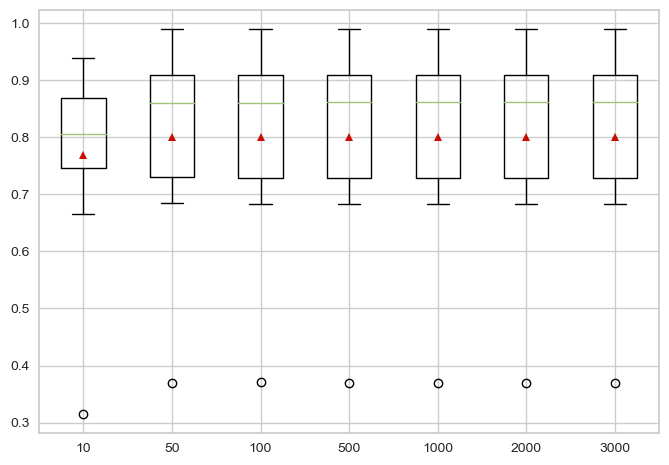

In [71]:
# Variables encodées et standardisées
n_estimators = [10, 50, 100, 500, 1000, 2000, 3000]
fonctions_models.regle_xgradboost_nestimators(
    n_estimators, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>80 0.80003 (0.17858) 0.99992 (0.00002)
>90 0.80005 (0.17853) 0.99995 (0.00001)
>100 0.80003 (0.17849) 0.99997 (0.00001)
>110 0.80002 (0.17855) 0.99998 (0.00000)
>120 0.79994 (0.17860) 0.99999 (0.00000)
>130 0.79990 (0.17863) 0.99999 (0.00000)
>140 0.79989 (0.17867) 0.99999 (0.00000)
>150 0.79987 (0.17866) 1.00000 (0.00000)


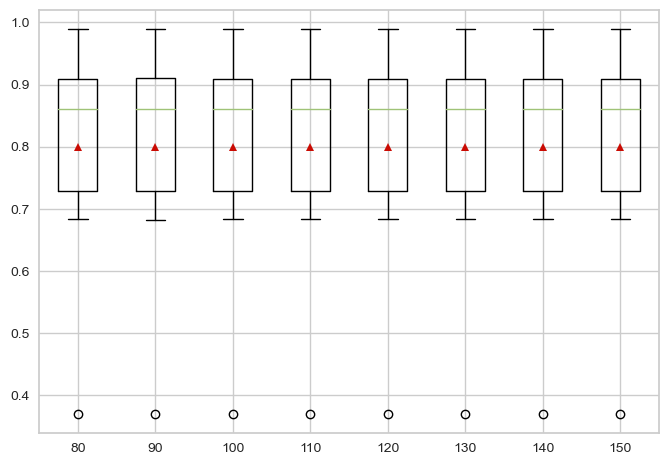

In [72]:
# Variables encodées et standardisées
n_estimators = [80, 90, 100, 110, 120, 130, 140, 150]
fonctions_models.regle_xgradboost_nestimators(
    n_estimators, X_train_log, y_train_log)

**Constat :**

Meilleur résultat : **n_estimators = 90**
Fourchette de recherche : n_estimators = [80, 90, 100]

**Hyperparamètre : learning_rate**

**learning_rate*** - float, default=0.1 - Le taux d'apprentissage réduit la contribution de chaque arbre par le taux d'apprentissage. Il existe un compromis entre le taux d'apprentissage et les n_estimators.



Hyperparam Test R2 +/- std Train R2 +/- std
>0.001 -33.74305 (21.38303) -26.18681 (1.39165)
>0.01 -4.88382 (3.61909) -3.50710 (0.23144)
>0.03 0.71369 (0.18675) 0.91304 (0.00478)
>0.05 0.81297 (0.17383) 0.99563 (0.00047)
>0.08 0.81652 (0.16343) 0.99886 (0.00013)
>0.1 0.81688 (0.16676) 0.99923 (0.00010)
>0.11 0.81249 (0.19197) 0.99935 (0.00008)
>0.12 0.81355 (0.18277) 0.99945 (0.00008)
>0.13 0.82443 (0.16593) 0.99952 (0.00008)
>0.14 0.82118 (0.16370) 0.99959 (0.00007)
>0.15 0.81342 (0.18270) 0.99966 (0.00005)
>0.2 0.80204 (0.19625) 0.99986 (0.00002)
>0.3 0.80003 (0.17849) 0.99997 (0.00001)


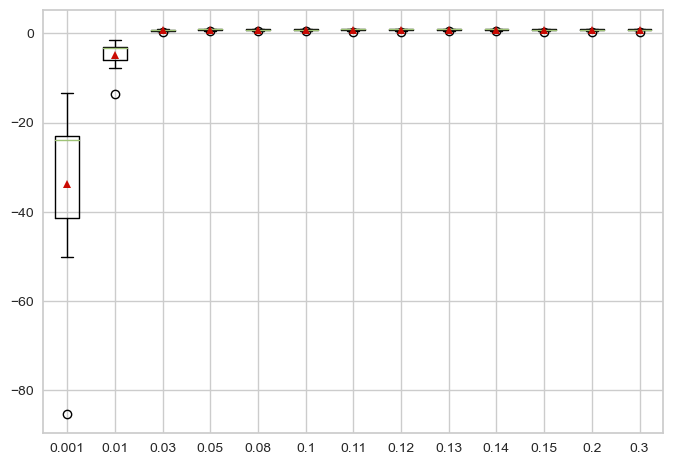

In [73]:
learning_rate = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.11, 0.12, 0.13, 0.14,
                 0.15, 0.2, 0.3]
fonctions_models.regle_xgradboost_learningrate(
    learning_rate, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **learning_rate** = 0.13
> - Fourchette de recherche : [0.11, 0.12, 0.13, 0.14]

**Hyperparamètre : max_depth**

**max_depth** - int, default=3 - Profondeur maximale des estimateurs de régression individuels. La profondeur maximale limite le nombre de nœuds dans l'arbre. Réglez ce paramètre pour obtenir les meilleures performances ; la meilleure valeur dépend de l'interaction des variables d'entrée.

Hyperparam Test R2 +/- std Train R2 +/- std
>1 0.84249 (0.13398) 0.93642 (0.00904)
>2 0.76763 (0.28163) 0.99127 (0.00218)
>3 0.80012 (0.20988) 0.99810 (0.00037)
>4 0.80065 (0.18505) 0.99949 (0.00007)
>5 0.79621 (0.17799) 0.99987 (0.00002)
>10 0.79481 (0.19232) 1.00000 (0.00000)


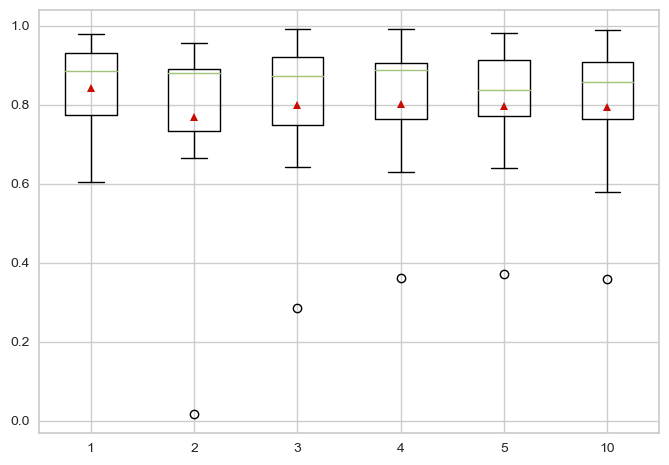

In [74]:
max_depth = [1, 2, 3, 4, 5, 10]
fonctions_models.regle_xgradboost_maxdepth(max_depth, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **max_depth** = 4 (valeur par défaut)
> - Fourchette de recherche : max_depth = [3, 4, 5]

**Entrainement et prédictions pour l'ensemble des valeurs des hyperparamètres trouvées**

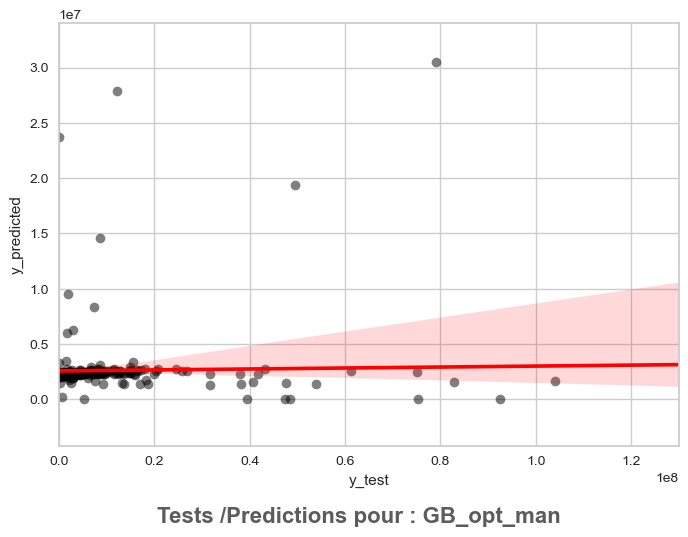

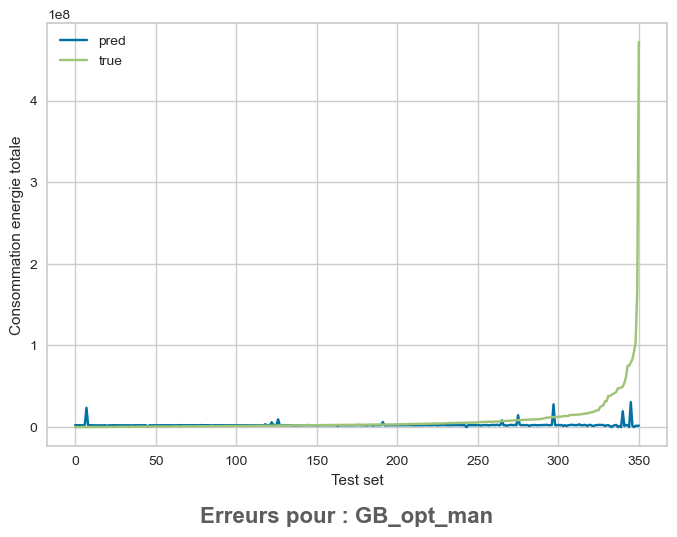

In [80]:
# Entrainement et prédictions pour l'ensemble des valeurs des hyperparamètres
# trouvées et conseiller par le guide utilisateur
model_xgb_manuel = XGBRegressor(n_estimators=90,
                                            learning_rate = 0.13,
                                            max_depth = 4,
                                            random_state=seed
                                            )
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné 
# avec la variable cible transformée en log10 + 1
df_resultats_xgb, y_pred_gb_man = fonctions_models.process_regression(model_xgb_manuel,
                                                                 X_train_log, X_test_log,
                                                                 y_train_log, y_test_log,
                                                                 df_resultats_xgb,
                                                                 'XGB_opt_man')

## <span style='background :gold' >  Extra Tree Regressor  </span>

### <span style='background : navajowhite' >  Influence des paramètres </span>

In [81]:
# Paramètres de base d'un algorthme GradientBoostRegressor
print('Les paramètres par défaut:\n')
etr_param = ExtraTreesRegressor(random_state=21)
pprint(etr_param.get_params())

Les paramètres par défaut:

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 21,
 'verbose': 0,
 'warm_start': False}


In [82]:
# DataFrame sauvegardant les résultats pour les différents essais d'optimisation
df_resultats_et = pd.DataFrame(dtype='object')

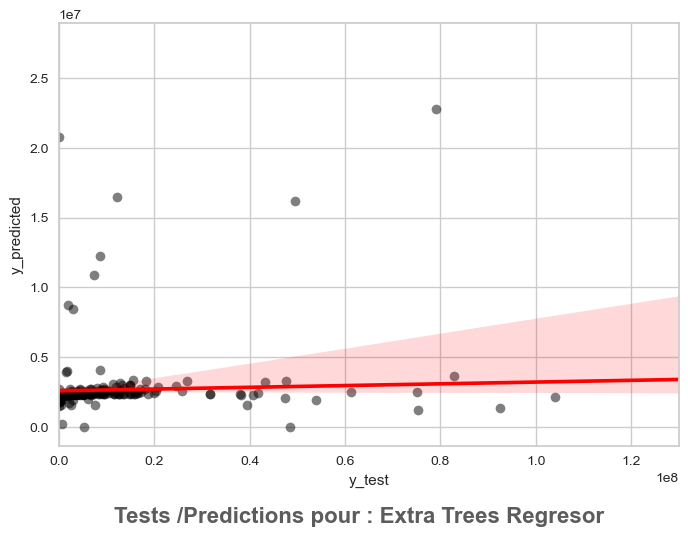

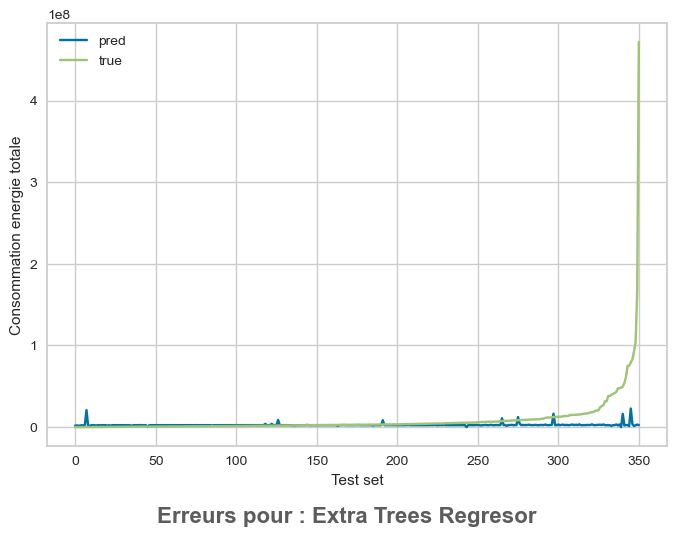

In [83]:
# 
# -----------------------------------------------------------------------
et =  ExtraTreesRegressor(n_estimators=100)
# BASELINE POUR COMPARAISON FINALE
df_resultats_et, y_pred = fonctions_models.process_regression(et,
                                                            X_train_log, X_test_log,
                                                            y_train_log, y_test_log,
                                                            df_resultats_et,
                                                            'Extra Trees Regressor')

### <span style='background : navajowhite' >  Découvrte des hyperparamètres </span>

**Hyperparamètre : n_estimators**

**n_estimators** int, default=100 - Le nombre d'arbres dans la forêt.

Hyperparam Test R2 +/- std Train R2 +/- std
>10 0.85425 (0.13944) 1.00000 (0.00000)
>50 0.86162 (0.13494) 1.00000 (0.00000)
>100 0.86021 (0.13466) 1.00000 (0.00000)
>500 0.86764 (0.12681) 1.00000 (0.00000)
>1000 0.86800 (0.12696) 1.00000 (0.00000)
>2000 0.86797 (0.12984) 1.00000 (0.00000)
>3000 0.86809 (0.13102) 1.00000 (0.00000)


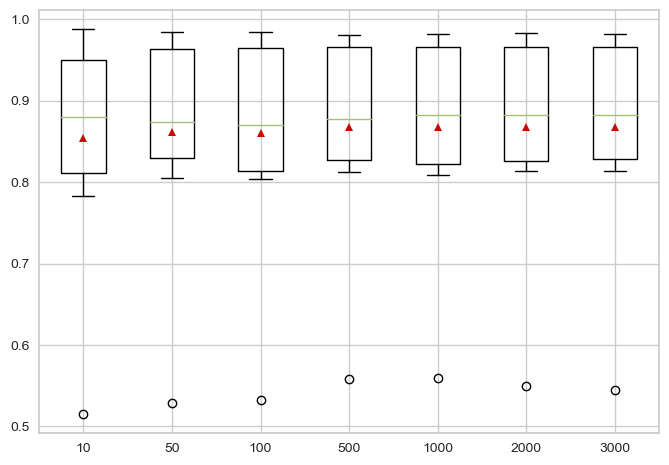

In [84]:
# Variables encodées et standardisées
n_estimators = [10, 50, 100, 500, 1000, 2000, 3000]
fonctions_models.regle_extratrees_nestimators(
    n_estimators, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>500 0.86764 (0.12681) 1.00000 (0.00000)
>600 0.86743 (0.12609) 1.00000 (0.00000)
>700 0.86697 (0.12746) 1.00000 (0.00000)
>800 0.86662 (0.12869) 1.00000 (0.00000)
>900 0.86732 (0.12771) 1.00000 (0.00000)


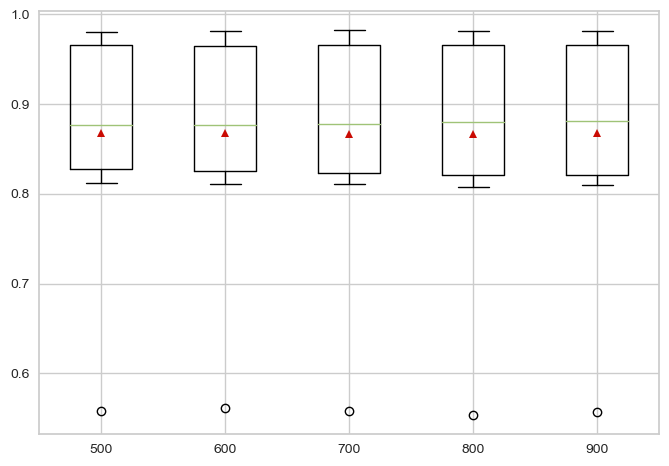

In [85]:
n_estimators = [500, 600, 700, 800, 900]
regle_extratrees_nestimators(
    n_estimators, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>490 0.86758 (0.12665) 1.00000 (0.00000)
>500 0.86764 (0.12681) 1.00000 (0.00000)
>510 0.86744 (0.12750) 1.00000 (0.00000)
>520 0.86698 (0.12825) 1.00000 (0.00000)
>530 0.86701 (0.12776) 1.00000 (0.00000)
>550 0.86727 (0.12747) 1.00000 (0.00000)
>560 0.86726 (0.12693) 1.00000 (0.00000)
>570 0.86700 (0.12666) 1.00000 (0.00000)
>580 0.86734 (0.12621) 1.00000 (0.00000)
>590 0.86768 (0.12586) 1.00000 (0.00000)


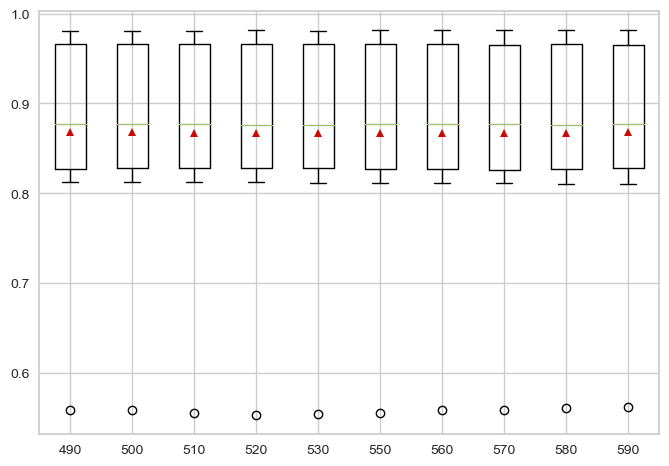

In [86]:
n_estimators = [490, 500, 510, 520, 530, 550, 560, 570, 580, 590]
fonctions_models.regle_extratrees_nestimators(
    n_estimators, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **n_estimators** = 590
> - Fourchette de recherche : n_estimators=[570, 580, 590]

**Hyperparamètre : max_features**

**max_features** {“auto”, “sqrt”, “log2”}, int or float, default=”auto” - Le nombre de caractéristiques à prendre en compte lors de la recherche du meilleur split

Hyperparam Test R2 +/- std Train R2 +/- std
>auto 0.86021 (0.13466) 1.00000 (0.00000)
>sqrt 0.82049 (0.08135) 1.00000 (0.00000)
>log2 0.77856 (0.07619) 1.00000 (0.00000)
>1 0.49906 (0.10011) 1.00000 (0.00000)
>2 0.64784 (0.09181) 1.00000 (0.00000)
>3 0.72806 (0.08709) 1.00000 (0.00000)
>4 0.77856 (0.07619) 1.00000 (0.00000)
>5 0.82049 (0.08135) 1.00000 (0.00000)
>6 0.83486 (0.08191) 1.00000 (0.00000)
>7 0.85319 (0.09505) 1.00000 (0.00000)
>8 0.84728 (0.11076) 1.00000 (0.00000)
>9 0.86736 (0.09066) 1.00000 (0.00000)
>10 0.86261 (0.11788) 1.00000 (0.00000)
>11 0.86674 (0.10871) 1.00000 (0.00000)
>12 0.86280 (0.11645) 1.00000 (0.00000)
>13 0.86249 (0.10007) 1.00000 (0.00000)
>14 0.86091 (0.11962) 1.00000 (0.00000)
>15 0.87209 (0.10357) 1.00000 (0.00000)
>16 0.86728 (0.11010) 1.00000 (0.00000)
>17 0.87021 (0.11089) 1.00000 (0.00000)
>18 0.87159 (0.10067) 1.00000 (0.00000)
>19 0.87388 (0.10708) 1.00000 (0.00000)
>20 0.86295 (0.11605) 1.00000 (0.00000)


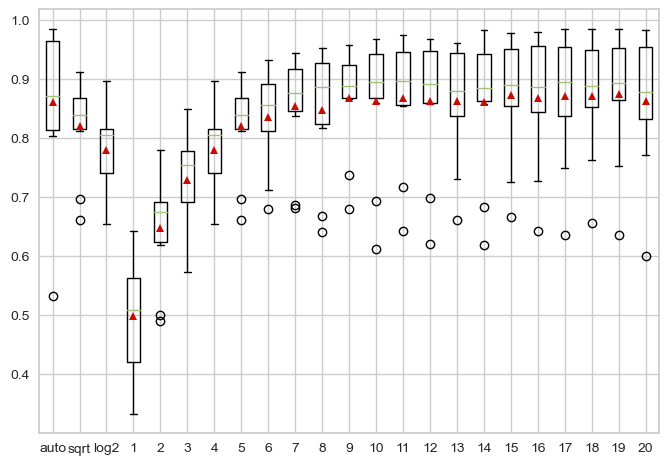

In [87]:
max_features = ['auto', 'sqrt', 'log2', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                12, 13, 14, 15, 16, 17, 18, 19, 20]
fonctions_models.regle_extratrees_maxfeatures(
    max_features, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **max_features** = 19
> - Fourchette de recherche : max_features': ['18','19','20'].

**Hyperparamètre : min_samples_split**

**min_samples_split** - int or float, default=2 - Le nombre minimum d'échantillons requis pour diviser un nœud interne.

Hyperparam Test R2 +/- std Train R2 +/- std
>2 0.86021 (0.13466) 1.00000 (0.00000)
>3 0.85719 (0.13730) 0.99929 (0.00025)
>4 0.85710 (0.14453) 0.99734 (0.00080)
>5 0.86630 (0.12626) 0.99406 (0.00150)
>6 0.86735 (0.12388) 0.98793 (0.00240)
>7 0.86961 (0.12270) 0.98366 (0.00302)
>8 0.86960 (0.12456) 0.97968 (0.00425)
>9 0.88253 (0.10126) 0.97406 (0.00365)
>10 0.88393 (0.10023) 0.96940 (0.00439)
>11 0.88269 (0.09836) 0.96629 (0.00482)
>12 0.88563 (0.09654) 0.96482 (0.00525)
>13 0.88461 (0.10018) 0.96355 (0.00574)
>14 0.88532 (0.09619) 0.96280 (0.00570)
>15 0.88496 (0.10006) 0.96293 (0.00608)
>16 0.88490 (0.09792) 0.96214 (0.00675)
>17 0.88600 (0.09813) 0.96168 (0.00589)
>18 0.88311 (0.09656) 0.96125 (0.00631)
>19 0.88648 (0.09580) 0.96053 (0.00658)
>20 0.88624 (0.09651) 0.95989 (0.00614)
>21 0.88922 (0.09790) 0.95880 (0.00627)
>22 0.89179 (0.09555) 0.95863 (0.00600)
>23 0.88983 (0.09938) 0.95736 (0.00617)
>24 0.88924 (0.09706) 0.95634 (0.00629)
>25 0.88703 (0.10004) 0.95549 (0.00636)
>26 

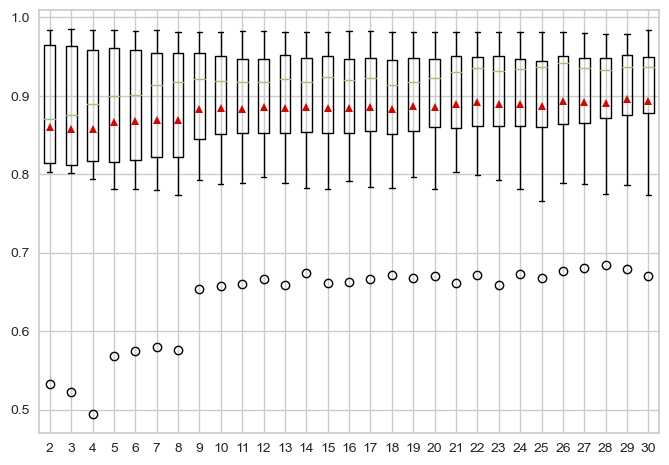

In [88]:
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                     17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
fonctions_models.regle_extratrees_minsamplessplit(
    min_samples_split, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **min_samples_split** = 29
> - Foruchette de recherche : min_samples_split = [26, 27, 28, 29, 30]

**Hyperparamètre : criterion**

**criterion** {“mse”, “mae”}, default=”mse” - Fonction permettant de mesurer la qualité d'un fractionnement. Les critères supportés sont "mse" pour l'erreur quadratique moyenne, qui est égale à la réduction de la variance comme critère de sélection des caractéristiques, et "mae" pour l'erreur absolue moyenne.

Hyperparam Test R2 +/- std Train R2 +/- std
>absolute_error 0.86883 (0.13281) 1.00000 (0.00000)
>squared_error 0.86021 (0.13466) 1.00000 (0.00000)
>friedman_mse 0.86160 (0.13321) 1.00000 (0.00000)


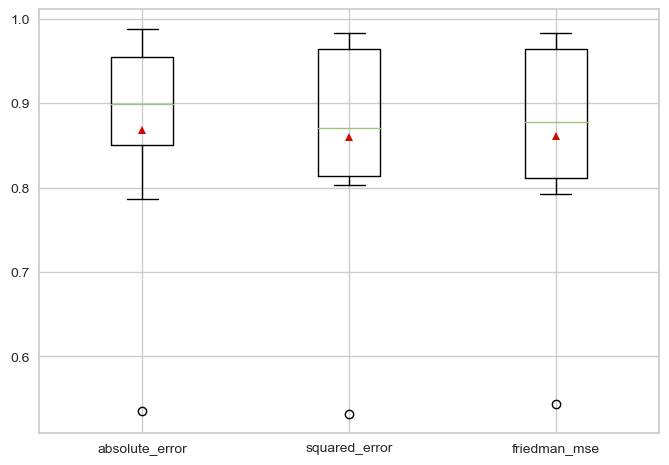

In [93]:
criterion = ['absolute_error', 'squared_error', 'friedman_mse']
fonctions_models.regle_extratrees_criterion(criterion, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **criterion** = 'absolute_error'
> - Foruchette de recherche : criterion = ['absolute_error', 'friedman_mae']

**Hyperparamètre : max_depth**

**max_depth** - int, default=None - La profondeur maximale de l'arbre. Si None, alors les noeuds sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent moins de min_samples_split échantillons.

Hyperparam Test R2 +/- std Train R2 +/- std
>5 0.84785 (0.12713) 0.97586 (0.00277)
>10 0.86102 (0.13599) 0.99853 (0.00018)
>20 0.86195 (0.13185) 1.00000 (0.00000)
>30 0.86030 (0.13467) 1.00000 (0.00000)
>40 0.86021 (0.13466) 1.00000 (0.00000)
>50 0.86021 (0.13466) 1.00000 (0.00000)
>60 0.86021 (0.13466) 1.00000 (0.00000)
>70 0.86021 (0.13466) 1.00000 (0.00000)
>80 0.86021 (0.13466) 1.00000 (0.00000)
>90 0.86021 (0.13466) 1.00000 (0.00000)
>100 0.86021 (0.13466) 1.00000 (0.00000)
>110 0.86021 (0.13466) 1.00000 (0.00000)
>120 0.86021 (0.13466) 1.00000 (0.00000)
>150 0.86021 (0.13466) 1.00000 (0.00000)


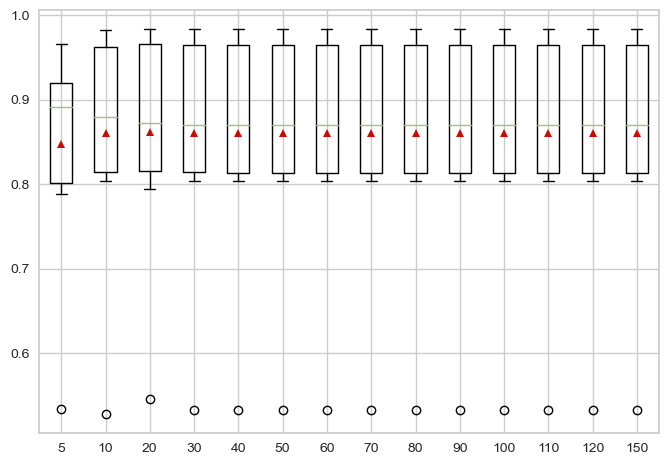

In [94]:
max_depth = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150]
fonctions_models.regle_extratrees_maxdepth(max_depth, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>7 0.85760 (0.13777) 0.99405 (0.00077)
>8 0.85727 (0.13938) 0.99630 (0.00049)
>9 0.85911 (0.13986) 0.99762 (0.00026)
>10 0.86102 (0.13599) 0.99853 (0.00018)
>11 0.86566 (0.12804) 0.99918 (0.00010)
>12 0.85890 (0.14068) 0.99960 (0.00006)
>13 0.86415 (0.13185) 0.99981 (0.00003)
>14 0.86593 (0.12685) 0.99992 (0.00001)


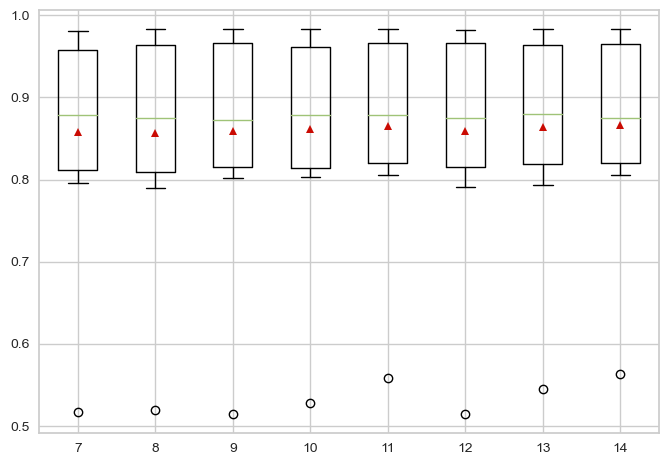

In [95]:
max_depth = [7, 8, 9, 10, 11, 12, 13, 14]
fonctions_models.regle_extratrees_maxdepth(max_depth, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **max_depth** = 14
> - Foruchette de recherche : max_depth = [12, 13, 14]

**Hyperparamètre : min_samples_leaf**

**min_samples_leaf** - int or float, default=1 - Le nombre minimum d'échantillons requis pour se trouver à un nœud de feuille.

Hyperparam Test R2 +/- std Train R2 +/- std
>1 0.86021 (0.13466) 1.00000 (0.00000)
>5 0.90058 (0.08738) 0.94449 (0.00453)
>10 0.90444 (0.08238) 0.92998 (0.00598)
>15 0.89763 (0.07666) 0.91714 (0.00601)
>20 0.80098 (0.09053) 0.83388 (0.05742)
>25 0.69778 (0.06897) 0.72497 (0.02813)
>30 0.54523 (0.11957) 0.57140 (0.05675)


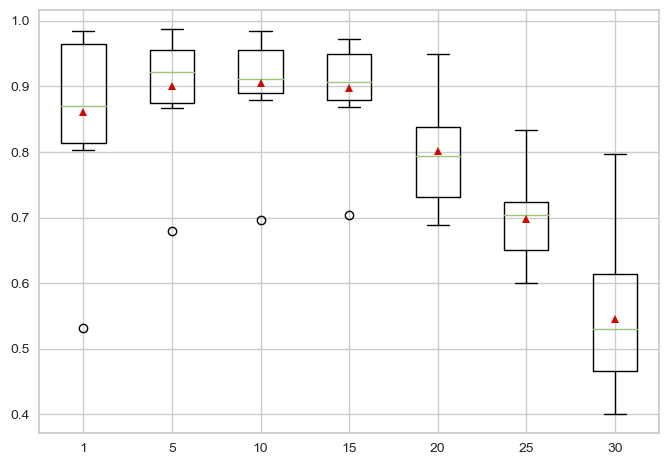

In [96]:
min_samples_leaf = [1, 5, 10, 15, 20, 25, 30]
fonctions_models.regle_extratrees_minsamplesleaf(min_samples_leaf, X_train_log,
                                             y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>6 0.90078 (0.08395) 0.93853 (0.00466)
>7 0.90308 (0.08380) 0.93573 (0.00518)
>8 0.90544 (0.08194) 0.93307 (0.00626)
>9 0.90576 (0.08183) 0.93086 (0.00597)
>10 0.90444 (0.08238) 0.92998 (0.00598)
>11 0.90321 (0.07924) 0.92799 (0.00522)
>12 0.90342 (0.07822) 0.92484 (0.00542)
>13 0.90028 (0.07712) 0.92259 (0.00585)


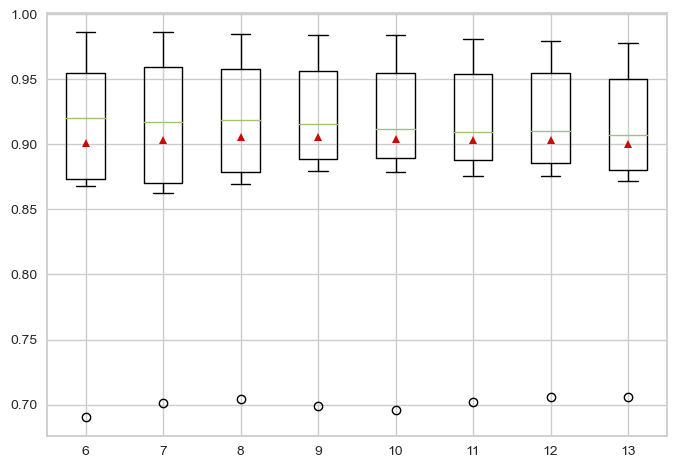

In [97]:
min_samples_leaf = [6, 7, 8, 9, 10, 11, 12, 13]
fonctions_models.regle_extratrees_minsamplesleaf(min_samples_leaf, X_train_log,
                                             y_train_log)

**Constat :**

> - Meilleur résultat : **min_samples_leaf** = 9
> - Fourchette de recherche : min_samples_leaf = [8,9,10,11]

**Hyperparamètre : max_leaf_nodes**

**max_leaf_nodes** - int, default=None - Faire croître les arbres avec max_leaf_nodes de la manière la plus efficace possible. Les meilleurs nœuds sont définis comme une réduction relative de l'impureté. Si None, le nombre de nœuds feuilles est illimité.

Hyperparam Test R2 +/- std Train R2 +/- std
>2 0.55490 (0.15082) 0.62022 (0.01183)
>10 0.82912 (0.13514) 0.96752 (0.00268)
>100 0.85444 (0.14535) 0.99901 (0.00015)
>1000 0.85426 (0.14515) 1.00000 (0.00000)
>5000 0.85426 (0.14515) 1.00000 (0.00000)


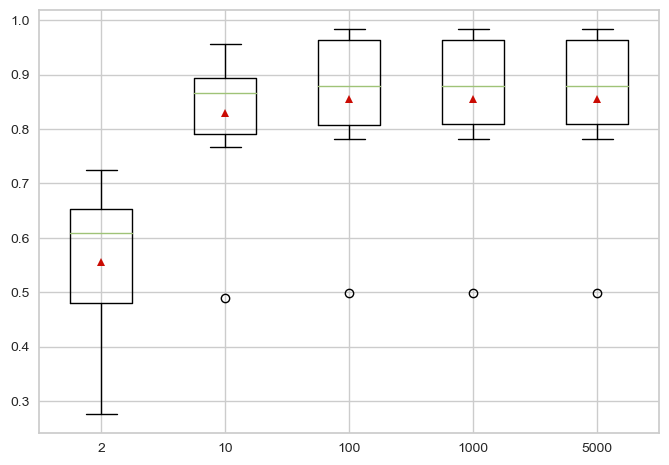

In [99]:
max_leaf_nodes = [2, 10, 100, 1000, 5000]
fonctions_models.regle_extratrees_maxleafnodes(max_leaf_nodes, X_train_log,
                                           y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>100 0.85444 (0.14535) 0.99901 (0.00015)
>300 0.85426 (0.14510) 0.99999 (0.00000)
>500 0.85426 (0.14514) 1.00000 (0.00000)


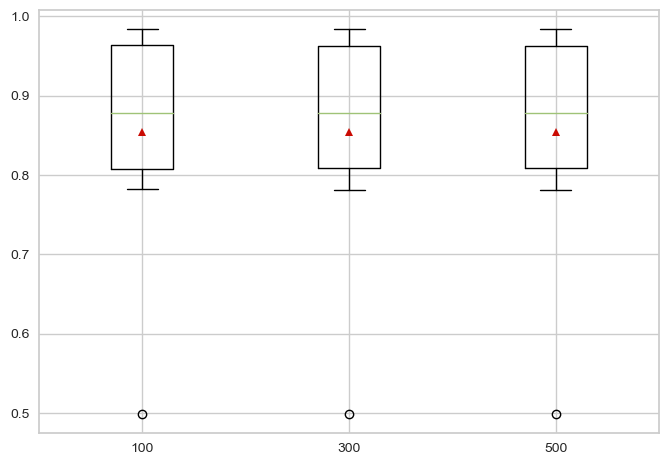

In [100]:
max_leaf_nodes = [100, 300, 500]
fonctions_models.regle_extratrees_maxleafnodes(max_leaf_nodes, X_train_log,
                                           y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>60 0.85444 (0.14511) 0.99729 (0.00037)
>70 0.85454 (0.14518) 0.99787 (0.00030)
>80 0.85447 (0.14541) 0.99835 (0.00024)
>90 0.85455 (0.14539) 0.99872 (0.00019)
>100 0.85444 (0.14535) 0.99901 (0.00015)
>110 0.85440 (0.14534) 0.99924 (0.00012)
>120 0.85433 (0.14527) 0.99941 (0.00010)
>130 0.85432 (0.14530) 0.99955 (0.00008)
>140 0.85428 (0.14527) 0.99965 (0.00007)
>150 0.85423 (0.14535) 0.99973 (0.00005)


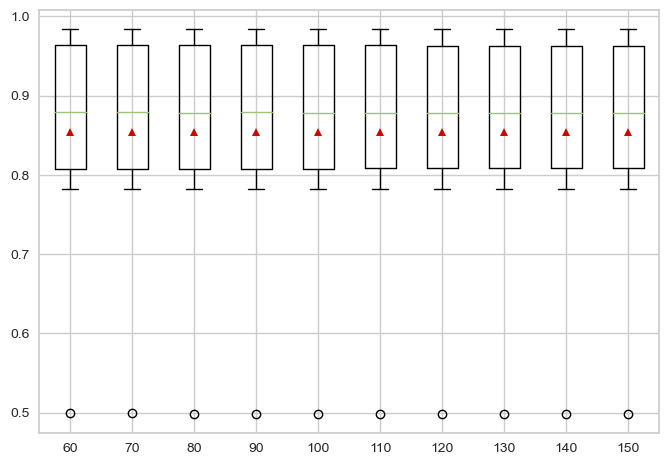

In [101]:
max_leaf_nodes = [60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
fonctions_models.regle_extratrees_maxleafnodes(max_leaf_nodes, X_train_log,
                                           y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>78 0.85447 (0.14540) 0.99826 (0.00025)
>79 0.85447 (0.14541) 0.99830 (0.00025)
>80 0.85447 (0.14541) 0.99835 (0.00024)
>81 0.85450 (0.14539) 0.99839 (0.00024)
>82 0.85451 (0.14538) 0.99843 (0.00023)
>83 0.85454 (0.14540) 0.99847 (0.00023)
>84 0.85454 (0.14541) 0.99850 (0.00022)
>85 0.85454 (0.14540) 0.99854 (0.00022)
>86 0.85454 (0.14540) 0.99858 (0.00021)
>87 0.85454 (0.14540) 0.99861 (0.00020)
>88 0.85456 (0.14542) 0.99865 (0.00020)
>89 0.85457 (0.14541) 0.99868 (0.00019)


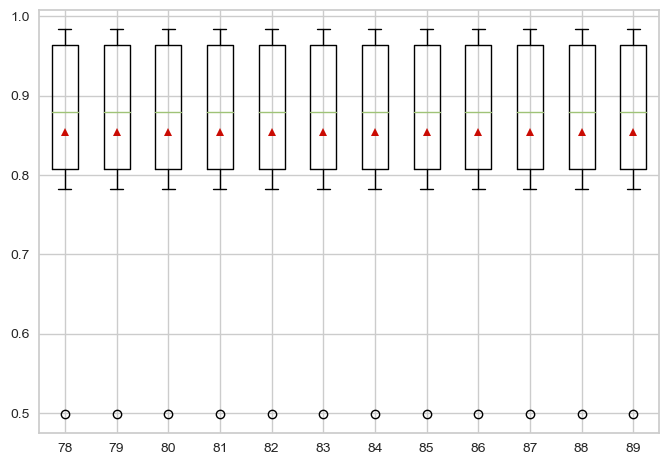

In [102]:
max_leaf_nodes = [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
fonctions_models.regle_extratrees_maxleafnodes(max_leaf_nodes, X_train_log,
                                           y_train_log)

**Constat :**

> - Meilleur résultat : **max_leaf_nodes** = 89
> - Foruchette de recherche : max_leaf_nodes = [84,85,86,87,88,89]

**Hyperparamètre : min_impurity_decrease**

**min_impurity_decrease** - float, default=0.0 - Un nœud sera divisé si cette division induit une diminution de l'impureté supérieure ou égale à cette valeur.

Hyperparam Test R2 +/- std Train R2 +/- std
>0.0 0.86021 (0.13466) 1.00000 (0.00000)
>0.01 0.84091 (0.12251) 0.97417 (0.00288)
>0.001 0.85655 (0.14305) 0.99308 (0.00067)
>0.0001 0.85581 (0.14174) 0.99735 (0.00033)
>1e-05 0.85859 (0.14382) 0.99985 (0.00001)


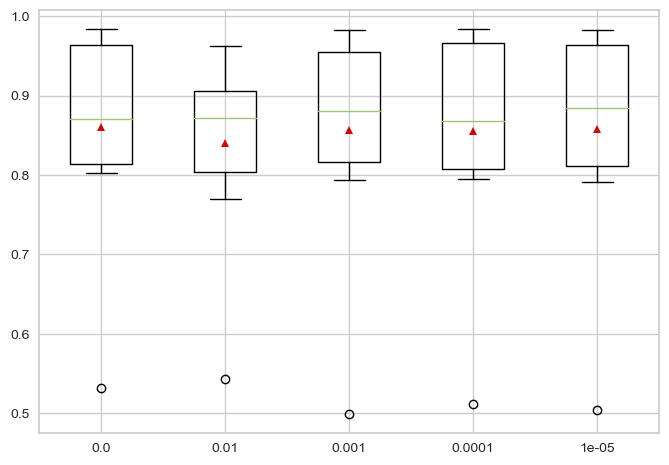

In [103]:
min_impurity_decrease = [0.0, 0.01, 0.001, 0.0001, 0.00001]
fonctions_models.regle_extratrees_minimpuritydecrease(min_impurity_decrease, X_train_log,
                                                  y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>0.0 0.86021 (0.13466) 1.00000 (0.00000)
>0.0001 0.85581 (0.14174) 0.99735 (0.00033)
>0.0002 0.85815 (0.13995) 0.99615 (0.00044)
>0.0003 0.85960 (0.14091) 0.99563 (0.00047)
>0.0004 0.85948 (0.14020) 0.99522 (0.00055)
>0.0005 0.85756 (0.14410) 0.99482 (0.00058)


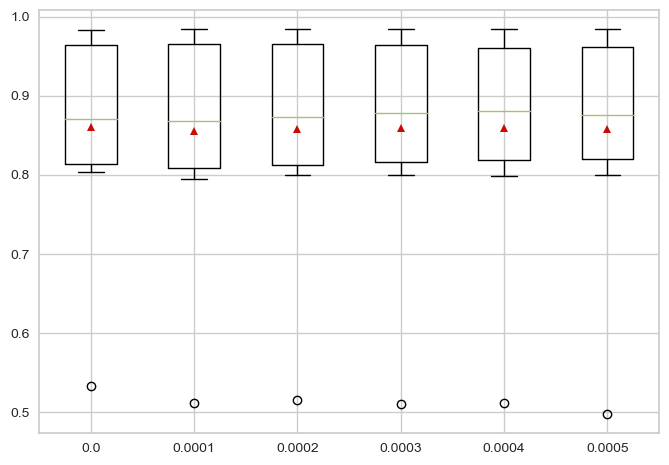

In [104]:
min_impurity_decrease = [0.0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
fonctions_models.regle_extratrees_minimpuritydecrease(min_impurity_decrease, X_train_log,
                                                  y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>0.00028 0.85990 (0.14105) 0.99573 (0.00048)
>0.00029 0.85932 (0.14143) 0.99569 (0.00045)
>0.0003 0.85960 (0.14091) 0.99563 (0.00047)
>0.00031 0.85913 (0.14007) 0.99559 (0.00047)
>0.00032 0.86028 (0.13503) 0.99555 (0.00048)
>0.00033 0.85834 (0.13583) 0.99551 (0.00048)


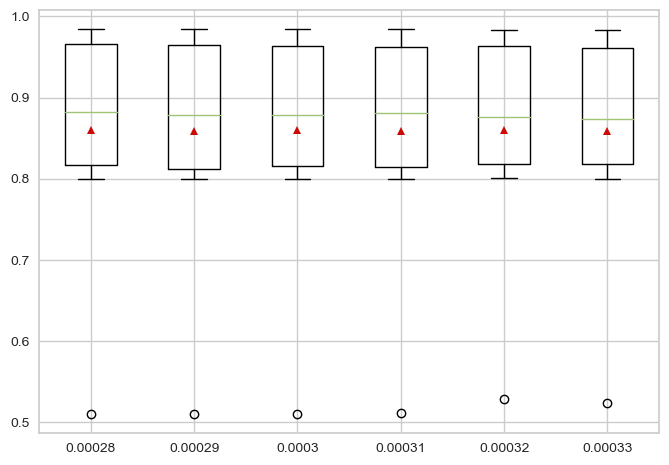

In [105]:
min_impurity_decrease = [0.00028, 0.00029, 0.0003, 0.00031, 0.00032, 0.00033]
fonctions_models.regle_extratrees_minimpuritydecrease(min_impurity_decrease, X_train_log,
                                                  y_train_log)

**Constat :**

> - Meilleur résultat : **min_impurity_decrease** = 0.00028
> - Fourchette de recherche : min_impurity_decrease = [0.00028,0.00029, 0.0003,0.00031]

**Hyperparamètre : bootstrap**

**bootstrap** - bool, default=False - Si les échantillons bootstrap sont utilisés lors de la construction des arbres. Si Faux, l'ensemble des données est utilisé pour construire chaque arbre.

Hyperparam Test R2 +/- std Train R2 +/- std
>True 0.88963 (0.11119) 0.98376 (0.00207)
>False 0.86021 (0.13466) 1.00000 (0.00000)


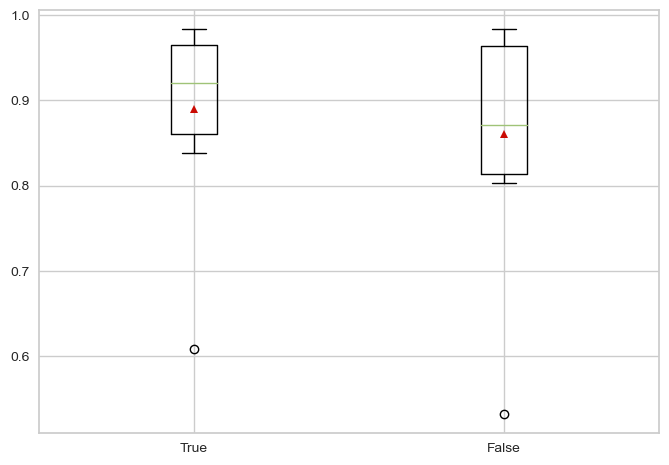

In [106]:
bootstrap = [True, False]
fonctions_models.regle_extratrees_bootstrap(bootstrap, X_train_log, y_train_log)

**Constat :**

> - Meilleur résultat : **bootstrap** = True.
> - Fourchette de recherche : bootstrap = [True, False]

**Hyperparamètre : max_samples**

**max_samples** - int or float, default=None - Si bootstrap est True, le nombre d'échantillons à tirer de X pour entraîner chaque estimateur de base.

Hyperparam Test R2 +/- std Train R2 +/- std
>0.001 -0.05454 (0.09446) -0.00796 (0.00995)
>0.25 0.89613 (0.08527) 0.94331 (0.00478)
>0.5 0.90239 (0.09228) 0.96187 (0.00355)
>0.75 0.89477 (0.09202) 0.97652 (0.00249)
>1 -0.05454 (0.09446) -0.00796 (0.00995)


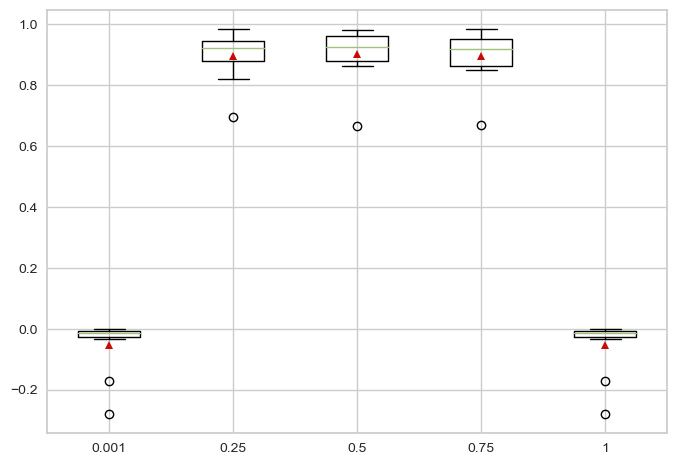

In [108]:
max_samples = [0.001, 0.25, 0.5, 0.75, 1]
fonctions_models.regle_extratrees_maxsamples(max_samples, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>0.42 0.89805 (0.09251) 0.95747 (0.00378)
>0.43 0.90067 (0.08717) 0.95777 (0.00343)
>0.44 0.90018 (0.08608) 0.95799 (0.00374)
>0.45 0.90323 (0.08608) 0.95887 (0.00332)
>0.46 0.90427 (0.08438) 0.95984 (0.00396)
>0.47 0.90269 (0.08373) 0.95972 (0.00347)
>0.48 0.90363 (0.08991) 0.96057 (0.00384)
>0.49 0.90317 (0.09021) 0.96125 (0.00371)
>0.5 0.90239 (0.09228) 0.96187 (0.00355)
>0.51 0.90021 (0.09695) 0.96279 (0.00393)
>0.52 0.90137 (0.09211) 0.96339 (0.00374)
>0.53 0.90099 (0.09346) 0.96374 (0.00354)
>0.54 0.90278 (0.08927) 0.96371 (0.00378)
>0.55 0.89930 (0.09300) 0.96432 (0.00379)


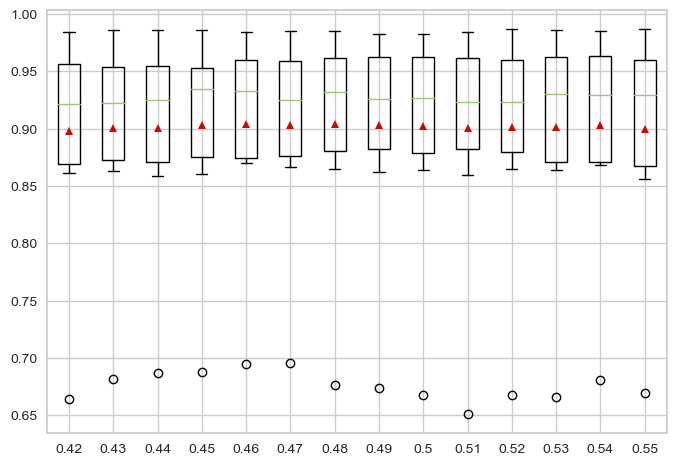

In [109]:
max_samples = [0.42, 0.43, 0.44, 0.45, 0.46, 0.47,
               0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55]
fonctions_models.regle_extratrees_maxsamples(max_samples, X_train_log, y_train_log)

**Constat** :

> - Meilleur résulat : **max_samples** = 0.46
> - Fourchette de recherche : max_samples = [0.42,0.43,0.44,0.45,0.46,0.47]

**Hyperparamètre : warm_start**

**warm_start** - bool, default=False - Lorsqu'elle est définie sur True, la solution de l'appel précédent à l'ajustement est réutilisée et d'autres estimateurs sont ajoutés à l'ensemble, sinon, une nouvelle forêt est ajustée.

Hyperparam Test R2 +/- std Train R2 +/- std
>False 0.86021 (0.13466) 1.00000 (0.00000)
>True 0.86021 (0.13466) 1.00000 (0.00000)


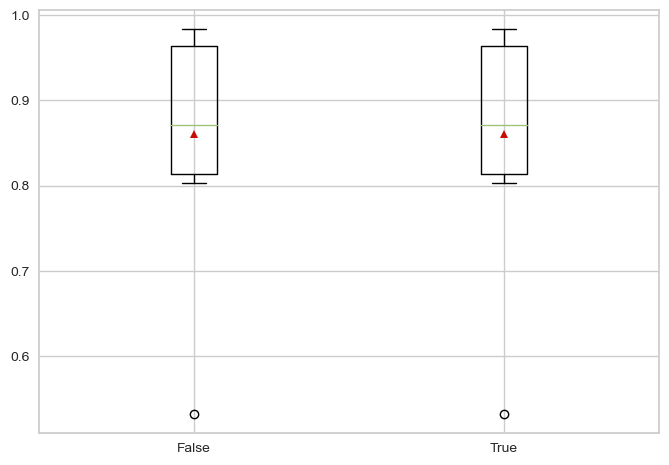

In [110]:
warm_start = [False, True]
fonctions_models.regle_extratrees_warm_start(warm_start, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **warm_start**: pas d'influence?
> - Fourchette de recherche : warm_start = [False, True]

**Hyperparamètre : ccp_alpha**

**ccp_alpha** - non-negative float, default=0.0 - Paramètre de complexité utilisé pour l'élagage minimal de complexité-coût. Le sous-arbre avec la plus grande complexité de coût qui est plus petite que ccp_alpha sera choisi. Par défaut, aucun élagage n'est effectué.

Hyperparam Test R2 +/- std Train R2 +/- std
>0.0 0.86021 (0.13466) 1.00000 (0.00000)
>0.001 0.85879 (0.13293) 0.99346 (0.00062)
>0.003 0.85469 (0.13037) 0.98982 (0.00073)
>0.005 0.85247 (0.12828) 0.98635 (0.00098)
>0.0075 0.84896 (0.12628) 0.98261 (0.00144)
>0.01 0.84406 (0.12485) 0.97936 (0.00148)
>0.015 0.83619 (0.12824) 0.97233 (0.00167)
>0.02 0.83440 (0.12226) 0.95962 (0.00361)
>0.025 0.82692 (0.12089) 0.94312 (0.00580)
>0.03 0.82527 (0.11564) 0.92352 (0.00745)
>0.035 0.81844 (0.10585) 0.90733 (0.01068)


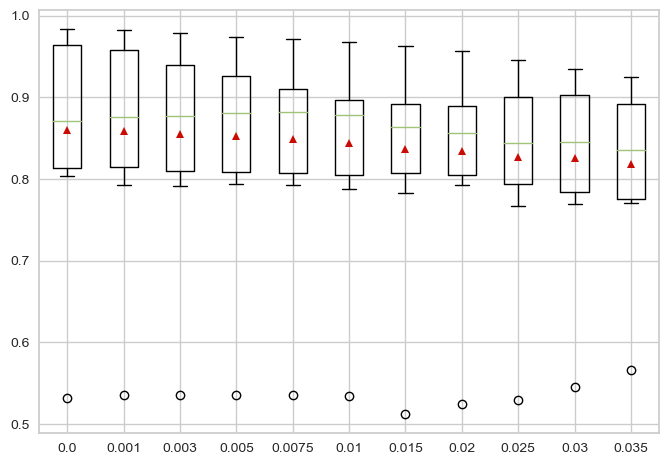

In [111]:
ccp_alpha = [0.0, 0.001, 0.003, 0.005, 0.0075,
             0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
fonctions_models.regle_extratrees_ccpalpha(ccp_alpha, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>0.0 0.86021 (0.13466) 1.00000 (0.00000)
>5e-05 0.86025 (0.13489) 0.99918 (0.00007)
>0.0001 0.86055 (0.13443) 0.99810 (0.00016)
>0.00015 0.86073 (0.13409) 0.99703 (0.00032)
>0.0002 0.86052 (0.13410) 0.99639 (0.00042)
>0.00025 0.86027 (0.13399) 0.99607 (0.00045)
>0.0003 0.86029 (0.13380) 0.99584 (0.00049)
>0.00035 0.86013 (0.13359) 0.99564 (0.00051)
>0.0004 0.85992 (0.13384) 0.99541 (0.00052)
>0.00045 0.85985 (0.13346) 0.99524 (0.00055)


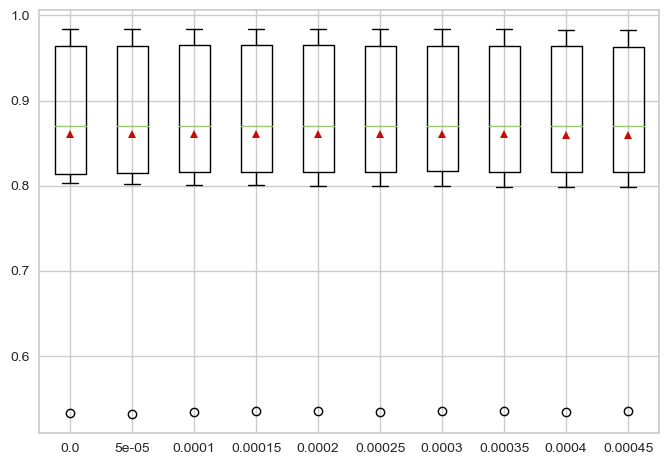

In [113]:
ccp_alpha = [0.0, 0.00005, 0.0001, 0.00015, 0.0002,
             0.00025, 0.0003, 0.00035, 0.0004, 0.00045]
fonctions_models.regle_extratrees_ccpalpha(ccp_alpha, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>0.00011 0.86057 (0.13436) 0.99785 (0.00019)
>0.00012 0.86061 (0.13433) 0.99760 (0.00024)
>0.00015 0.86073 (0.13409) 0.99703 (0.00032)
>0.0002 0.86052 (0.13410) 0.99639 (0.00042)
>0.00022 0.86029 (0.13440) 0.99624 (0.00043)
>0.00023 0.86007 (0.13424) 0.99617 (0.00044)


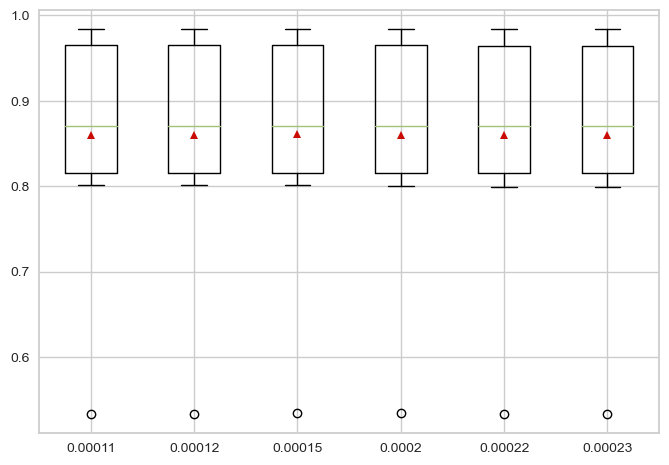

In [116]:
ccp_alpha = [0.00011, 0.00012, 0.00015, 0.0002, 0.00022, 0.00023]
fonctions_models.regle_extratrees_ccpalpha(ccp_alpha, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **ccp_alpha** = 0.00015
> - Fourchette de recherche : ccp_alpha = [0.00011,0.00012,0.00015,0.0002]

**Entrainement et prédictions pour l'ensemble des valeurs des hyperparamètres trouvées**

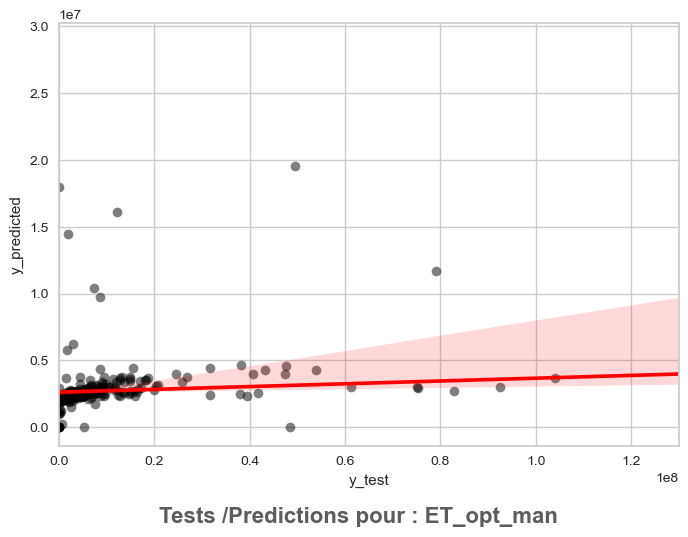

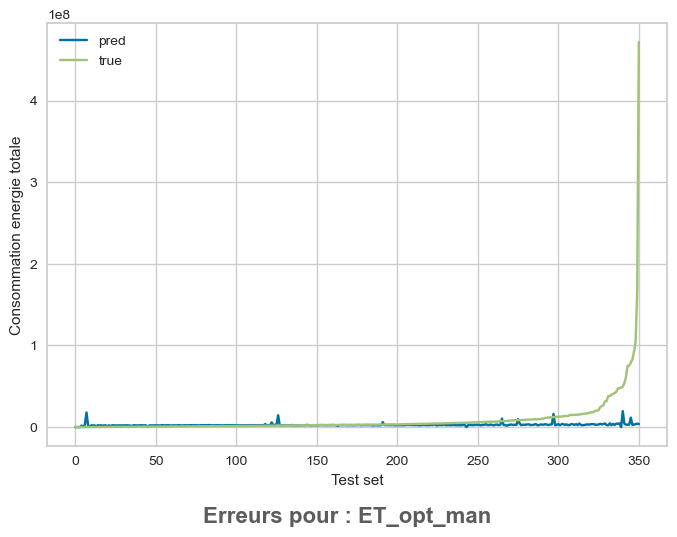

In [118]:
# Entrainement et prédictions pour l'ensemble des valeurs des hyperparamètres
# trouvées et conseiller par le guide utilisateur
model_et_manuel = ExtraTreesRegressor(n_estimators=590,
                                      min_samples_split=29,
                                      max_depth=14,
                                      max_features=19,
                                      random_state=seed
                                      )
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné 
# avec la variable cible transformée en log10 + 1
df_resultats_et, y_pred_et_man = fonctions_models.process_regression(model_et_manuel,
                                                                 X_train_log, X_test_log,
                                                                 y_train_log, y_test_log,
                                                                 df_resultats_et,
                                                                 'ET_opt_man')

## <span style='background :gold' >  Random Forest Regressor  </span>

### <span style='background : navajowhite' >  Influence des paramètres </span>

In [119]:
# Paramètres de base d'un algorthme GradientBoostRegressor
print('Les paramètres par défaut:\n')
rfr_param = RandomForestRegressor(random_state=21)
pprint(rfr_param.get_params())

Les paramètres par défaut:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 21,
 'verbose': 0,
 'warm_start': False}


In [120]:
# DataFrame sauvegardant les résultats pour les différents essais d'optimisation
df_resultats_rfr = pd.DataFrame(dtype='object')

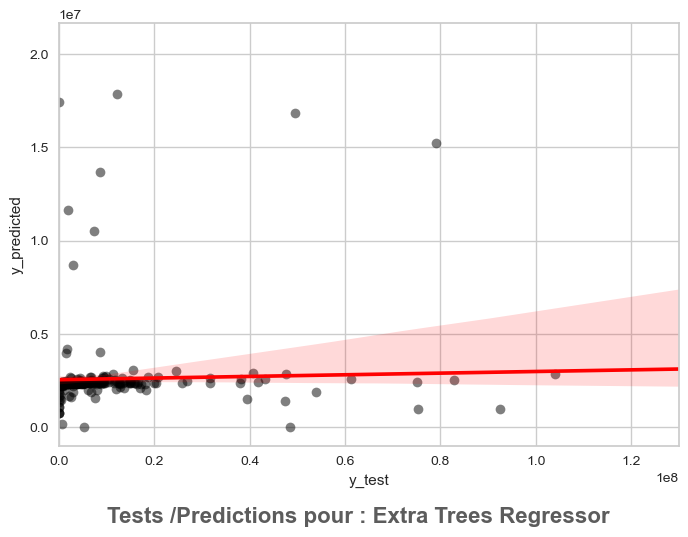

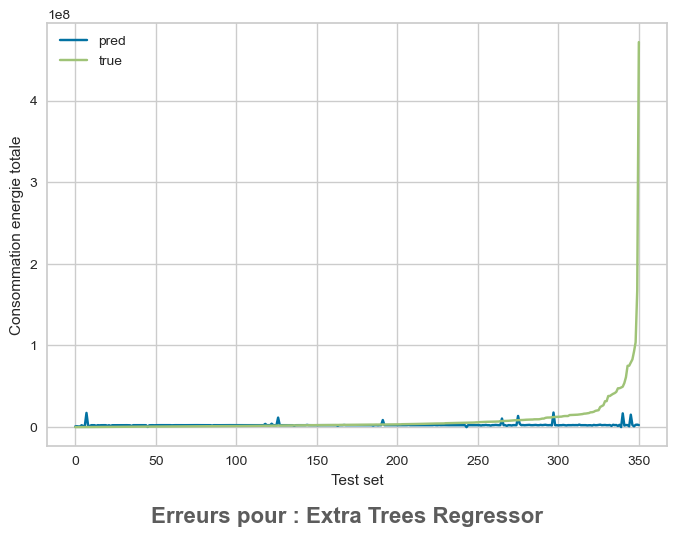

In [121]:
# 
# -----------------------------------------------------------------------
rfr =  RandomForestRegressor(n_estimators=100)
# BASELINE POUR COMPARAISON FINALE
df_resultats_rfr, y_pred = fonctions_models.process_regression(et,
                                                            X_train_log, X_test_log,
                                                            y_train_log, y_test_log,
                                                            df_resultats_rfr,
                                                            'Extra Trees Regressor')

### <span style='background : navajowhite' >  Découvrte des hyperparamètres </span>

**Hyperparamètre : n_estimators**

**n_estimators** int, default=100 - Le nombre d'arbres dans la forêt.

Hyperparam Test R2 +/- std Train R2 +/- std
>10 0.84028 (0.16259) 0.96766 (0.00659)
>50 0.86038 (0.13025) 0.97757 (0.00284)
>100 0.85757 (0.12311) 0.97892 (0.00215)
>500 0.85421 (0.12378) 0.98033 (0.00257)
>1000 0.85440 (0.12321) 0.98086 (0.00254)
>2000 0.85503 (0.12354) 0.98089 (0.00249)
>3000 0.85511 (0.12348) 0.98086 (0.00260)


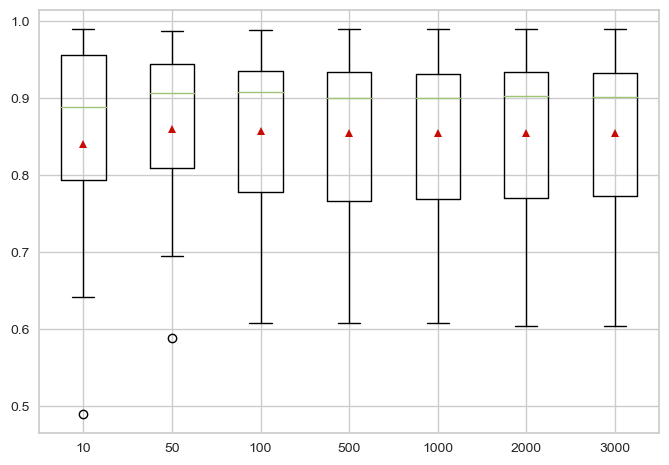

In [162]:
# Variables encodées et standardisées
n_estimators = [10, 50, 100, 500, 1000, 2000, 3000]
fonctions_models.regle_randomforest_nestimators(
    n_estimators, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>100 0.85757 (0.12311) 0.97892 (0.00215)
>200 0.85557 (0.12621) 0.98026 (0.00210)
>300 0.85593 (0.12309) 0.98043 (0.00232)
>400 0.85548 (0.12332) 0.98029 (0.00247)
>500 0.85421 (0.12378) 0.98033 (0.00257)


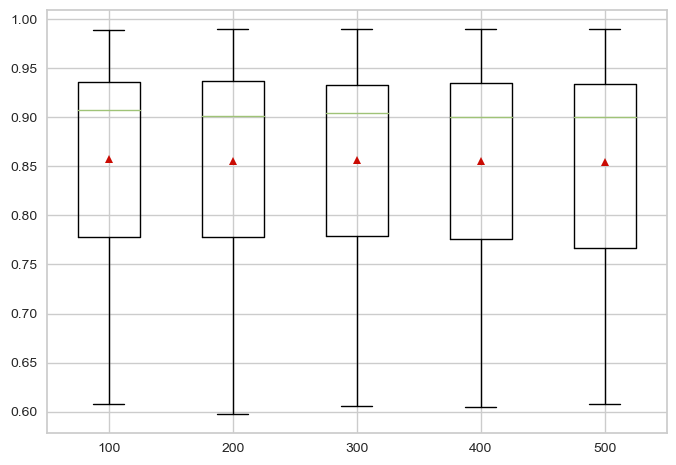

In [163]:
n_estimators = [100, 200, 300, 400, 500]
fonctions_models.regle_randomforest_nestimators(
    n_estimators, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>280 0.85583 (0.12371) 0.98043 (0.00243)
>290 0.85567 (0.12434) 0.98042 (0.00237)
>300 0.85593 (0.12309) 0.98043 (0.00232)
>310 0.85630 (0.12307) 0.98031 (0.00238)
>320 0.85616 (0.12321) 0.98038 (0.00238)
>330 0.85600 (0.12307) 0.98039 (0.00240)
>350 0.85611 (0.12330) 0.98039 (0.00242)
>360 0.85618 (0.12396) 0.98042 (0.00243)
>370 0.85622 (0.12359) 0.98041 (0.00245)
>380 0.85620 (0.12364) 0.98027 (0.00243)
>390 0.85625 (0.12303) 0.98032 (0.00246)


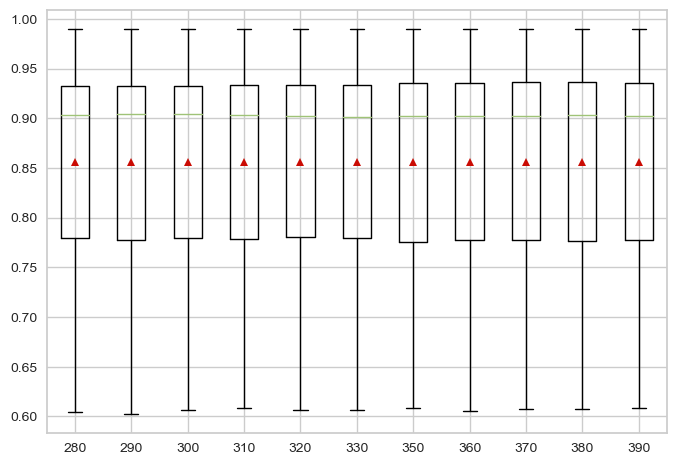

In [164]:
n_estimators = [280, 290, 300, 310, 320, 330, 350, 360, 370, 380, 390]
fonctions_models.regle_randomforest_nestimators(
    n_estimators, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **n_estimators** = 310
> - Fourchette de recherche : n_estimators=[290, 300, 310]

**Hyperparamètre : max_features**

**max_features** {“auto”, “sqrt”, “log2”}, int or float, default=”auto” - Le nombre de caractéristiques à prendre en compte lors de la recherche du meilleur split

Hyperparam Test R2 +/- std Train R2 +/- std
>auto 0.85757 (0.12311) 0.97892 (0.00215)
>sqrt 0.78837 (0.07530) 0.97137 (0.00173)
>log2 0.76345 (0.07121) 0.96751 (0.00164)
>1 0.48150 (0.05789) 0.93114 (0.00297)
>2 0.58027 (0.07665) 0.94769 (0.00141)
>3 0.68856 (0.07482) 0.95805 (0.00224)
>4 0.76345 (0.07121) 0.96751 (0.00164)
>5 0.78837 (0.07530) 0.97137 (0.00173)
>6 0.82016 (0.07925) 0.97428 (0.00196)
>7 0.83914 (0.06752) 0.97686 (0.00150)
>8 0.85229 (0.08109) 0.97918 (0.00178)
>9 0.85641 (0.09134) 0.97971 (0.00152)
>10 0.85809 (0.08471) 0.98121 (0.00166)
>11 0.86466 (0.09402) 0.98069 (0.00218)
>12 0.86850 (0.09042) 0.98132 (0.00151)
>13 0.86795 (0.09295) 0.98099 (0.00173)
>14 0.86814 (0.11021) 0.98105 (0.00182)
>15 0.86956 (0.10333) 0.98152 (0.00210)
>16 0.87220 (0.10311) 0.98158 (0.00204)
>17 0.86371 (0.10470) 0.98120 (0.00204)
>18 0.86461 (0.11454) 0.98050 (0.00235)
>19 0.86904 (0.11857) 0.98047 (0.00227)
>20 0.86362 (0.11665) 0.98078 (0.00228)


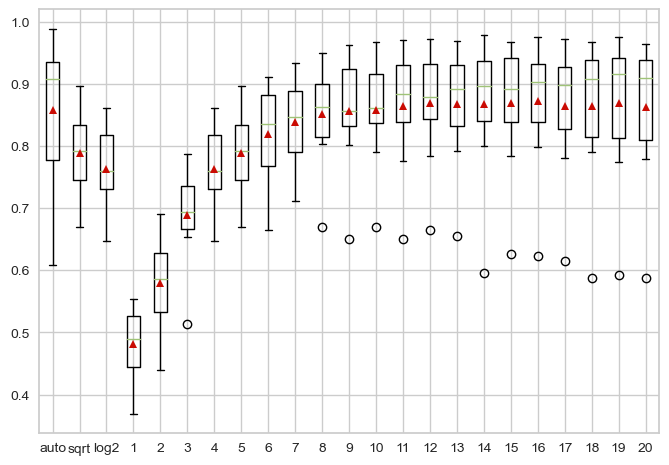

In [127]:
max_features = ['auto', 'sqrt', 'log2', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                12, 13, 14, 15, 16, 17, 18, 19, 20]
fonctions_models.regle_randomforest_maxfeatures(
    max_features, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **max_features** = 19
> - Fourchette de recherche : max_features': ['16','17','18','19','20']

**Hyperparamètre : min_samples_split**

**min_samples_split** - int or float, default=2 - Le nombre minimum d'échantillons requis pour diviser un nœud interne.

Hyperparam Test R2 +/- std Train R2 +/- std
>2 0.85757 (0.12311) 0.97892 (0.00215)
>3 0.85575 (0.12450) 0.97648 (0.00298)
>4 0.85333 (0.12643) 0.97309 (0.00392)
>5 0.85318 (0.12767) 0.97143 (0.00437)
>6 0.85261 (0.12814) 0.97041 (0.00483)
>7 0.85329 (0.12799) 0.96944 (0.00514)
>8 0.85328 (0.12798) 0.96909 (0.00530)
>9 0.85306 (0.12784) 0.96895 (0.00532)
>10 0.85315 (0.12804) 0.96888 (0.00532)
>11 0.85291 (0.12773) 0.96874 (0.00536)
>12 0.85288 (0.12723) 0.96847 (0.00537)
>13 0.85290 (0.12699) 0.96776 (0.00581)
>14 0.85252 (0.12791) 0.96635 (0.00625)
>15 0.85193 (0.12855) 0.96440 (0.00707)
>16 0.85243 (0.12907) 0.96155 (0.00832)
>17 0.85369 (0.12883) 0.95829 (0.00952)
>18 0.85478 (0.12801) 0.95489 (0.00952)
>19 0.85535 (0.12719) 0.95159 (0.00928)
>20 0.85730 (0.12493) 0.94834 (0.00912)
>21 0.85754 (0.12513) 0.94541 (0.00887)
>22 0.85803 (0.12601) 0.94379 (0.00903)
>23 0.85816 (0.12531) 0.94255 (0.00906)
>24 0.85829 (0.12540) 0.94209 (0.00927)
>25 0.85826 (0.12554) 0.94168 (0.00933)
>26 

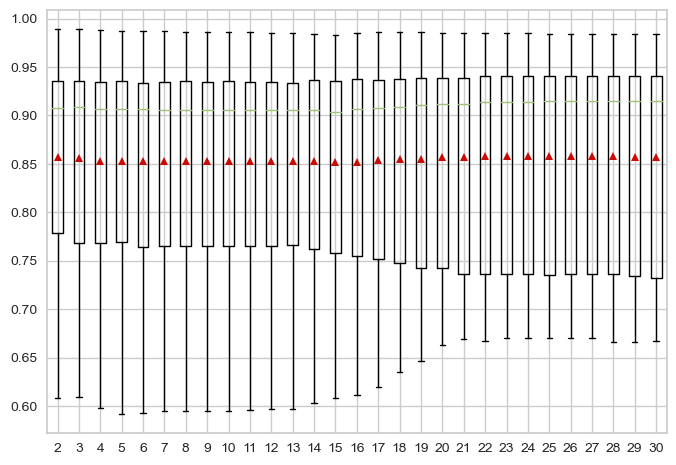

In [128]:
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                     17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
fonctions_models.regle_randomforest_minsamplessplit(
    min_samples_split, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **min_samples_split** = 27
> - Foruchette de recherche : min_samples_split = [25, 26, 27, 28, 29]

**Hyperparamètre : min_samples_leaf**

**min_samples_leaf** - int or float, default=1 - Le nombre minimum d'échantillons requis pour se trouver à un nœud de feuille.

Hyperparam Test R2 +/- std Train R2 +/- std
>1 0.85757 (0.12311) 0.97892 (0.00215)
>5 0.87630 (0.11958) 0.94161 (0.00633)
>10 0.86668 (0.12887) 0.92319 (0.00898)
>15 0.86941 (0.13471) 0.90355 (0.01391)
>20 0.84342 (0.14295) 0.86421 (0.01928)
>25 0.78587 (0.11241) 0.80664 (0.01886)
>30 0.72660 (0.09614) 0.75730 (0.01460)


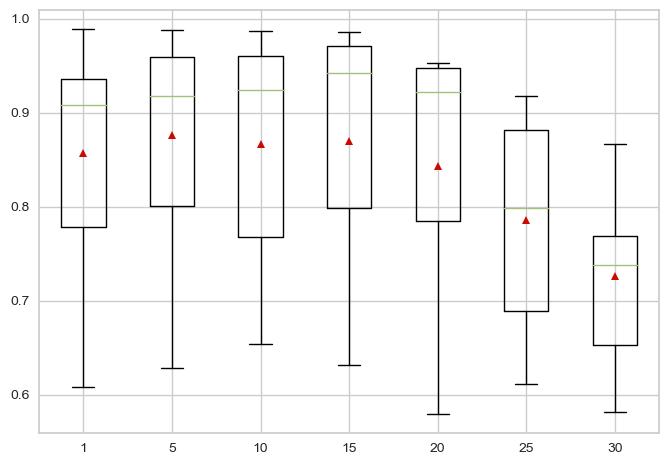

In [129]:
min_samples_leaf = [1, 5, 10, 15, 20, 25, 30]
fonctions_models.regle_randomforest_minsamplesleaf(min_samples_leaf, X_train_log,
                                             y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>1 0.85757 (0.12311) 0.97892 (0.00215)
>2 0.86008 (0.13706) 0.96604 (0.00396)
>3 0.86911 (0.13279) 0.95378 (0.00501)
>4 0.87188 (0.12989) 0.94588 (0.00614)
>5 0.87630 (0.11958) 0.94161 (0.00633)
>6 0.87555 (0.11947) 0.93811 (0.00691)
>7 0.87427 (0.12036) 0.93485 (0.00695)
>8 0.87073 (0.12328) 0.93078 (0.00790)


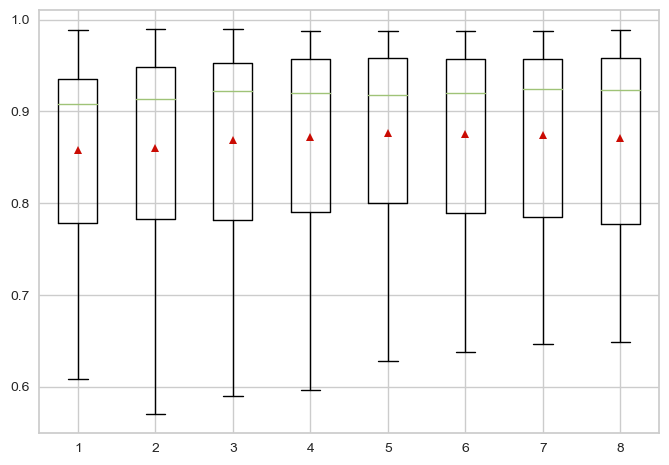

In [130]:
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8]
fonctions_models.regle_randomforest_minsamplesleaf(min_samples_leaf, X_train_log,
                                             y_train_log)

**Constat** :

> - Meilleur résultat : **min_samples_leaf** = 5
> - Fourchette de recherche : min_samples_leaf = [4,5,6,7]

**Hyperparamètre : min_impurity_decrease** 

**min_impurity_decrease** - float, default=0.0 - Un nœud sera divisé si cette division induit une diminution de l'impureté supérieure ou égale à cette valeur.

Hyperparam Test R2 +/- std Train R2 +/- std
>0.0 0.85757 (0.12311) 0.97892 (0.00215)
>0.01 0.83192 (0.12394) 0.94671 (0.00491)
>0.001 0.85718 (0.12176) 0.97281 (0.00254)
>0.0001 0.85811 (0.12272) 0.97749 (0.00225)
>1e-05 0.85755 (0.12311) 0.97884 (0.00213)


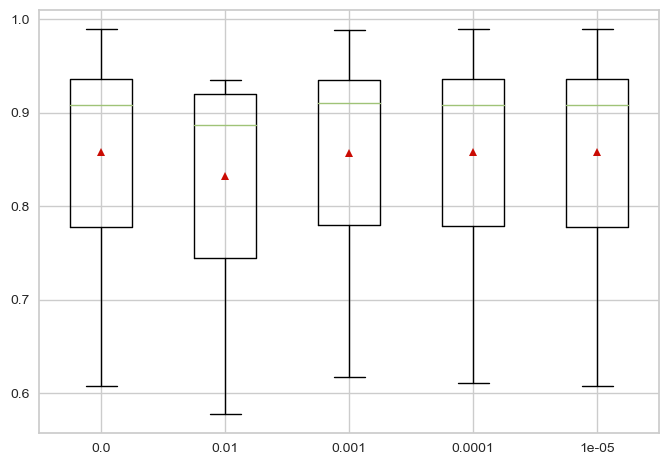

In [131]:
min_impurity_decrease = [0.0, 0.01, 0.001, 0.0001, 0.00001]
fonctions_models.regle_randomforest_minimpuritydecrease(min_impurity_decrease, X_train_log,
                                                  y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>0.0 0.85757 (0.12311) 0.97892 (0.00215)
>0.0001 0.85811 (0.12272) 0.97749 (0.00225)
>0.0002 0.85889 (0.12222) 0.97629 (0.00231)
>0.0003 0.85895 (0.12208) 0.97554 (0.00237)
>0.0004 0.85876 (0.12175) 0.97506 (0.00241)
>0.0005 0.85860 (0.12161) 0.97465 (0.00244)


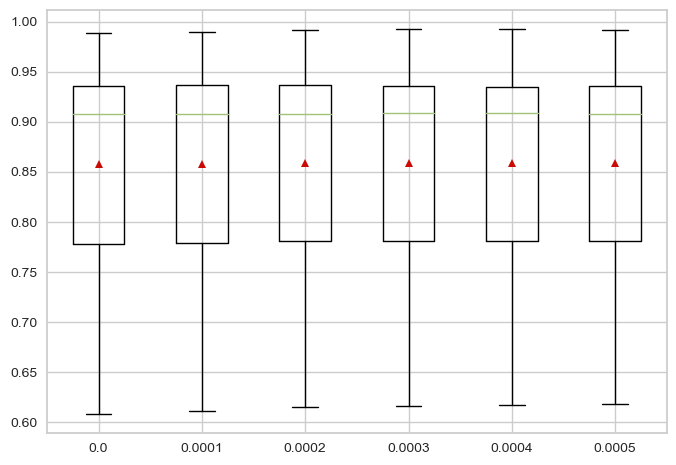

In [132]:
min_impurity_decrease = [0.0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
fonctions_models.regle_randomforest_minimpuritydecrease(min_impurity_decrease, X_train_log,
                                                  y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>0.00028 0.85885 (0.12215) 0.97569 (0.00235)
>0.00029 0.85888 (0.12219) 0.97561 (0.00236)
>0.0003 0.85895 (0.12208) 0.97554 (0.00237)
>0.00031 0.85901 (0.12206) 0.97548 (0.00237)
>0.00032 0.85907 (0.12200) 0.97543 (0.00237)
>0.00033 0.85906 (0.12192) 0.97536 (0.00238)


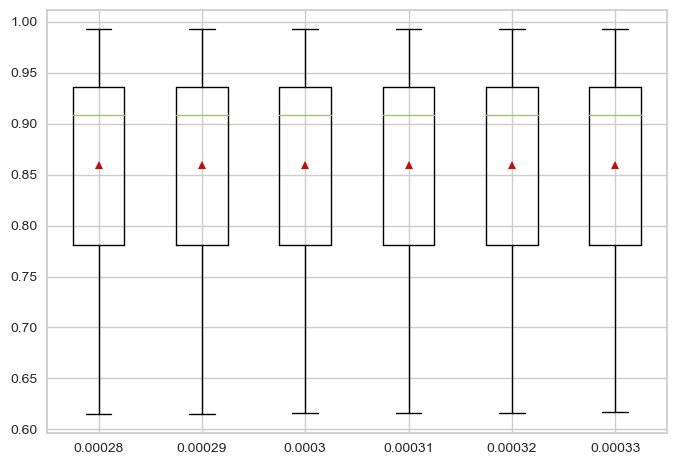

In [133]:
min_impurity_decrease = [0.00028, 0.00029, 0.0003, 0.00031, 0.00032, 0.00033]
fonctions_models.regle_randomforest_minimpuritydecrease(min_impurity_decrease, X_train_log,
                                                  y_train_log)

**Constat** :

> - Meilleur résultat : **min_impurity_decrease** = 0.00032
> - Fourchette de recherche : min_impurity_decrease = [0.0003,0.00031, 0.00032, 0.00033]

**Hyperparamètre : max_samples**

**max_samples** - int or float, default=None - Si bootstrap est True, le nombre d'échantillons à tirer de X pour entraîner chaque estimateur de base.

Hyperparam Test R2 +/- std Train R2 +/- std
>0.0011 -0.05454 (0.09446) -0.00796 (0.00995)
>0.25 0.89066 (0.09563) 0.93748 (0.00535)
>0.5 0.87911 (0.10586) 0.95532 (0.00430)
>0.75 0.86566 (0.11474) 0.96998 (0.00293)
>1 -0.05454 (0.09446) -0.00796 (0.00995)


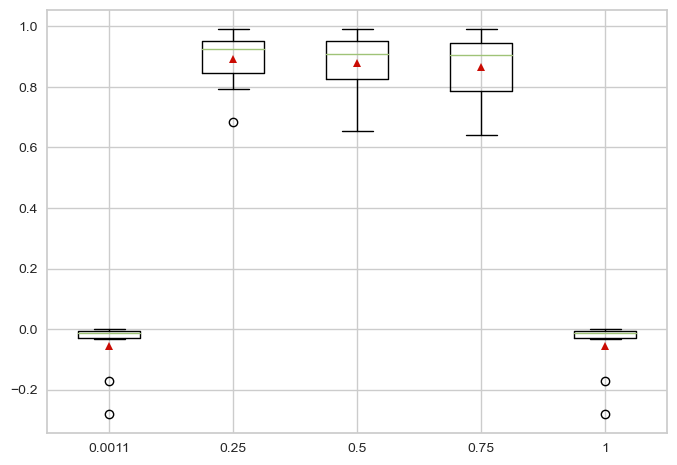

In [158]:
max_samples = [0.0011, 0.25, 0.5, 0.75, 1]
fonctions_models.regle_randomforest_maxsamples(max_samples, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>0.17 0.89438 (0.09615) 0.93013 (0.00611)
>0.18 0.89493 (0.09502) 0.93160 (0.00563)
>0.19 0.89524 (0.09349) 0.93279 (0.00530)
>0.2 0.89627 (0.09299) 0.93379 (0.00531)
>0.21 0.89448 (0.09510) 0.93461 (0.00549)
>0.22 0.89215 (0.09572) 0.93569 (0.00552)
>0.23 0.89266 (0.09478) 0.93672 (0.00564)
>0.24 0.89299 (0.09346) 0.93714 (0.00528)
>0.25 0.89066 (0.09563) 0.93748 (0.00535)
>0.26 0.88957 (0.09552) 0.93828 (0.00515)
>0.27 0.88875 (0.09785) 0.93895 (0.00543)
>0.28 0.88556 (0.10095) 0.93977 (0.00528)
>0.29 0.88560 (0.10247) 0.94061 (0.00541)
>0.3 0.88412 (0.10379) 0.94120 (0.00534)


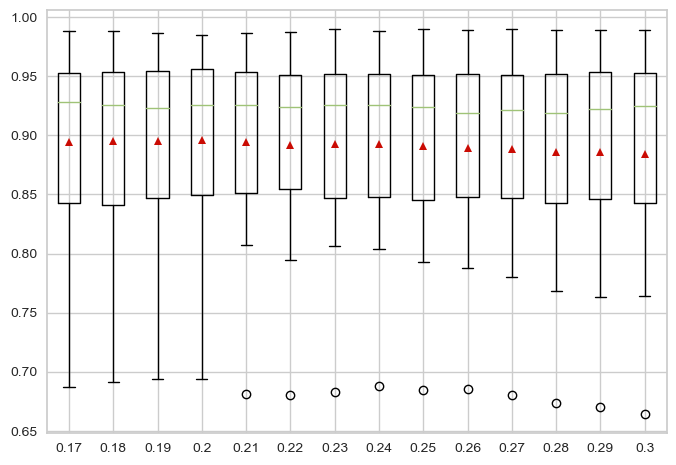

In [159]:
max_samples = [0.17, 0.18, 0.19, 0.2, 0.21, 0.22,
               0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3]
fonctions_models.regle_randomforest_maxsamples(max_samples, X_train_log, y_train_log)

**Constat** :

> - Meilleur résulat : **max_samples** = 0.2
> - Fourchette de recherche : max_samples = [0.17,0.18,0.19,0.2,0.25]

**Hyperparamètre : max_leaf_nodes**

**max_leaf_nodes** - int, default=None - Faire croître les arbres avec max_leaf_nodes de la manière la plus efficace possible. Les meilleurs nœuds sont définis comme une réduction relative de l'impureté. Si None, le nombre de nœuds feuilles est illimité.

Hyperparam Test R2 +/- std Train R2 +/- std
>2 0.49736 (0.24360) 0.64078 (0.01785)
>10 0.84636 (0.12514) 0.96378 (0.00428)
>100 0.85374 (0.12692) 0.97889 (0.00223)
>1000 0.85385 (0.12681) 0.97900 (0.00221)
>5000 0.85385 (0.12681) 0.97900 (0.00221)


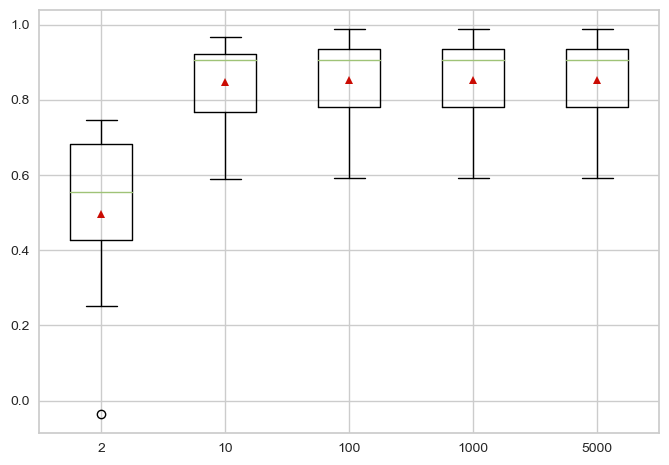

In [136]:
max_leaf_nodes = [2, 10, 100, 1000, 5000]
fonctions_models.regle_randomforest_maxleafnodes(max_leaf_nodes, X_train_log,
                                           y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>1000 0.85385 (0.12681) 0.97900 (0.00221)
>3000 0.85385 (0.12681) 0.97900 (0.00221)
>5000 0.85385 (0.12681) 0.97900 (0.00221)


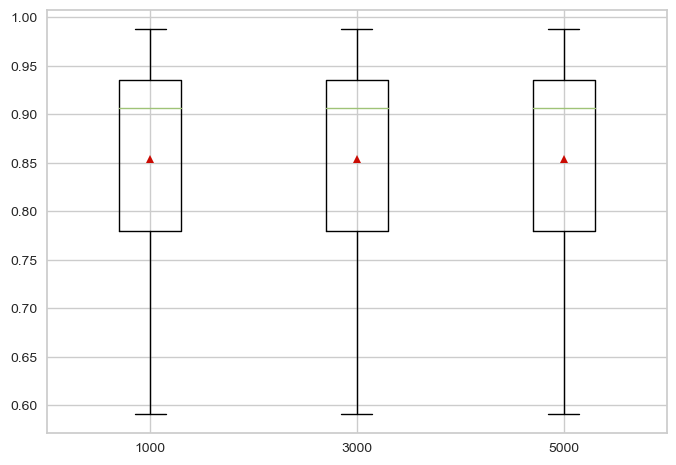

In [138]:
max_leaf_nodes = [1000, 3000, 5000]
fonctions_models.regle_randomforest_maxleafnodes(max_leaf_nodes, X_train_log,
                                           y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>600 0.85385 (0.12681) 0.97900 (0.00221)
>700 0.85385 (0.12681) 0.97900 (0.00221)
>800 0.85385 (0.12681) 0.97900 (0.00221)
>900 0.85385 (0.12681) 0.97900 (0.00221)
>1000 0.85385 (0.12681) 0.97900 (0.00221)
>1100 0.85385 (0.12681) 0.97900 (0.00221)
>1200 0.85385 (0.12681) 0.97900 (0.00221)
>1300 0.85385 (0.12681) 0.97900 (0.00221)
>1400 0.85385 (0.12681) 0.97900 (0.00221)
>1500 0.85385 (0.12681) 0.97900 (0.00221)


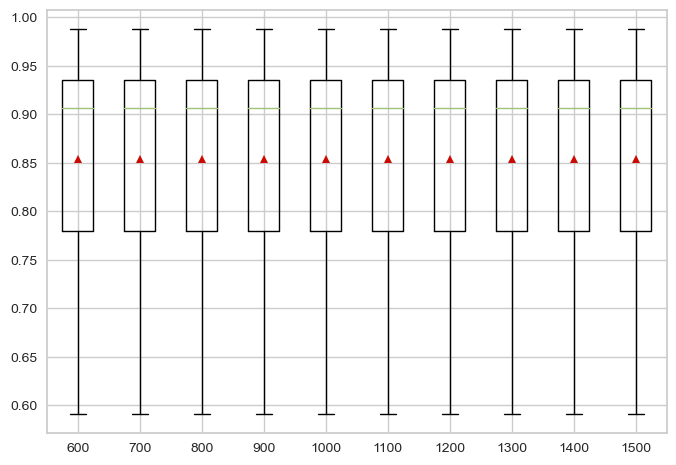

In [139]:
max_leaf_nodes = [600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
fonctions_models.regle_randomforest_maxleafnodes(max_leaf_nodes, X_train_log,
                                           y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>60 0.85403 (0.12697) 0.97826 (0.00230)
>70 0.85386 (0.12695) 0.97855 (0.00227)
>80 0.85374 (0.12696) 0.97873 (0.00225)
>90 0.85374 (0.12694) 0.97884 (0.00224)
>100 0.85374 (0.12692) 0.97889 (0.00223)
>200 0.85383 (0.12681) 0.97899 (0.00221)
>300 0.85384 (0.12681) 0.97900 (0.00221)
>400 0.85384 (0.12681) 0.97900 (0.00221)
>500 0.85385 (0.12681) 0.97900 (0.00221)
>600 0.85385 (0.12681) 0.97900 (0.00221)


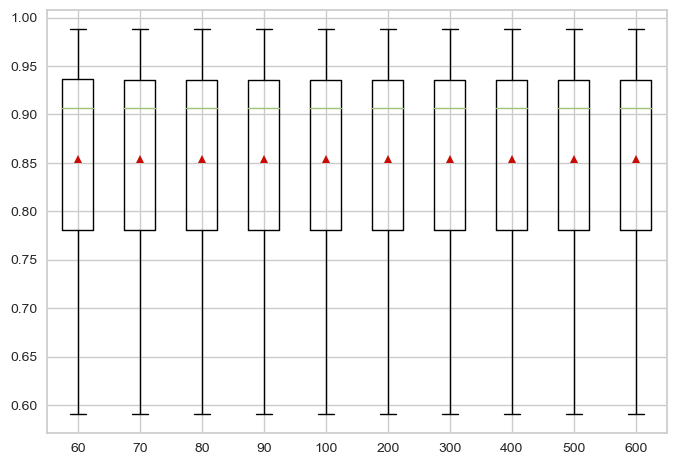

In [140]:
max_leaf_nodes = [60, 70, 80, 90, 100, 200, 300, 400, 500, 600]
fonctions_models.regle_randomforest_maxleafnodes(max_leaf_nodes, X_train_log,
                                           y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>500 0.85385 (0.12681) 0.97900 (0.00221)
>510 0.85385 (0.12681) 0.97900 (0.00221)
>530 0.85385 (0.12681) 0.97900 (0.00221)
>550 0.85385 (0.12681) 0.97900 (0.00221)
>560 0.85385 (0.12681) 0.97900 (0.00221)
>570 0.85385 (0.12681) 0.97900 (0.00221)
>580 0.85385 (0.12681) 0.97900 (0.00221)
>590 0.85385 (0.12681) 0.97900 (0.00221)
>600 0.85385 (0.12681) 0.97900 (0.00221)


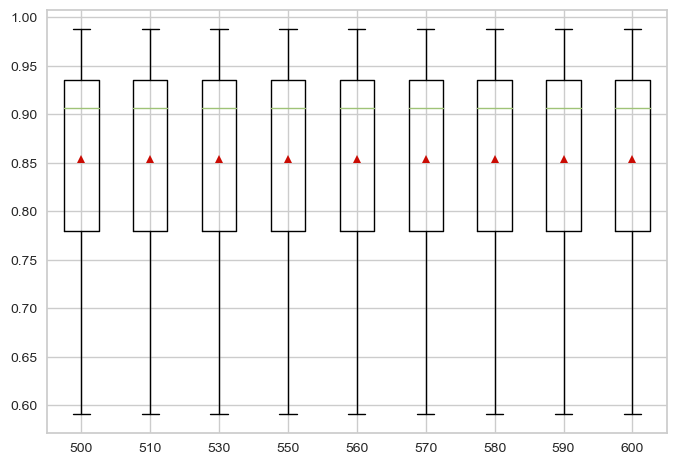

In [141]:
max_leaf_nodes = [500, 510, 530, 550, 560, 570, 580, 590, 600]
fonctions_models.regle_randomforest_maxleafnodes(max_leaf_nodes, X_train_log,
                                           y_train_log)

**Constat** :

> - Meilleur résultat : **max_leaf_nodes** = 500
> - Foruchette de recherche : max_leaf_nodes = [480,490,500,510,520,530]

**Hyperparamètre : 'max_features**

**max_features** {“auto”, “sqrt”, “log2”}, int or float, default=”auto” - Le nombre de caractéristiques à prendre en compte lors de la recherche du meilleur split

Hyperparam Test R2 +/- std Train R2 +/- std
>auto 0.85757 (0.12311) 0.97892 (0.00215)
>sqrt 0.78837 (0.07530) 0.97137 (0.00173)
>log2 0.76345 (0.07121) 0.96751 (0.00164)
>1 0.48150 (0.05789) 0.93114 (0.00297)
>2 0.58027 (0.07665) 0.94769 (0.00141)
>3 0.68856 (0.07482) 0.95805 (0.00224)
>4 0.76345 (0.07121) 0.96751 (0.00164)
>5 0.78837 (0.07530) 0.97137 (0.00173)
>6 0.82016 (0.07925) 0.97428 (0.00196)
>7 0.83914 (0.06752) 0.97686 (0.00150)
>8 0.85229 (0.08109) 0.97918 (0.00178)
>9 0.85641 (0.09134) 0.97971 (0.00152)
>10 0.85809 (0.08471) 0.98121 (0.00166)
>11 0.86466 (0.09402) 0.98069 (0.00218)
>12 0.86850 (0.09042) 0.98132 (0.00151)
>13 0.86795 (0.09295) 0.98099 (0.00173)
>14 0.86814 (0.11021) 0.98105 (0.00182)
>15 0.86956 (0.10333) 0.98152 (0.00210)
>16 0.87220 (0.10311) 0.98158 (0.00204)
>17 0.86371 (0.10470) 0.98120 (0.00204)
>18 0.86461 (0.11454) 0.98050 (0.00235)
>19 0.86904 (0.11857) 0.98047 (0.00227)
>20 0.86362 (0.11665) 0.98078 (0.00228)


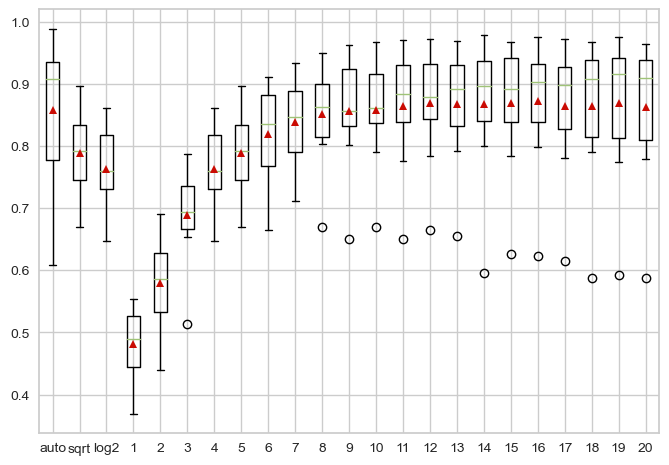

In [142]:
max_features = ['auto', 'sqrt', 'log2', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                12, 13, 14, 15, 16, 17, 18, 19, 20]
fonctions_models.regle_randomforest_maxfeatures(
    max_features, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **max_features** = 16
> - Foruchette de recherche : max_features = [14, 15, 16, 17, 18]

**Hyperparamètre : max_depth**

**max_depth** - int, default=None - La profondeur maximale de l'arbre. Si None, alors les noeuds sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent moins de min_samples_split échantillons.

Hyperparam Test R2 +/- std Train R2 +/- std
>5 0.85697 (0.12327) 0.96799 (0.00367)
>10 0.85772 (0.12263) 0.97879 (0.00218)
>20 0.85761 (0.12314) 0.97891 (0.00215)
>30 0.85757 (0.12311) 0.97892 (0.00215)
>40 0.85757 (0.12311) 0.97892 (0.00215)
>50 0.85757 (0.12311) 0.97892 (0.00215)
>60 0.85757 (0.12311) 0.97892 (0.00215)
>70 0.85757 (0.12311) 0.97892 (0.00215)
>80 0.85757 (0.12311) 0.97892 (0.00215)
>90 0.85757 (0.12311) 0.97892 (0.00215)
>100 0.85757 (0.12311) 0.97892 (0.00215)
>110 0.85757 (0.12311) 0.97892 (0.00215)
>120 0.85757 (0.12311) 0.97892 (0.00215)
>150 0.85757 (0.12311) 0.97892 (0.00215)


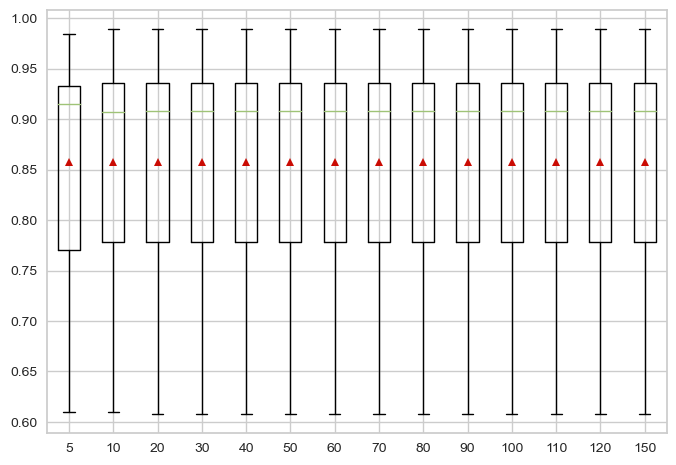

In [155]:
max_depth = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150]
fonctions_models.regle_randomforest_maxdepth(max_depth, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>7 0.85860 (0.12187) 0.97655 (0.00251)
>8 0.85806 (0.12246) 0.97795 (0.00228)
>9 0.85818 (0.12275) 0.97856 (0.00218)
>10 0.85772 (0.12263) 0.97879 (0.00218)
>11 0.85767 (0.12313) 0.97886 (0.00217)
>12 0.85771 (0.12283) 0.97888 (0.00215)
>13 0.85758 (0.12274) 0.97889 (0.00214)
>14 0.85768 (0.12291) 0.97889 (0.00216)


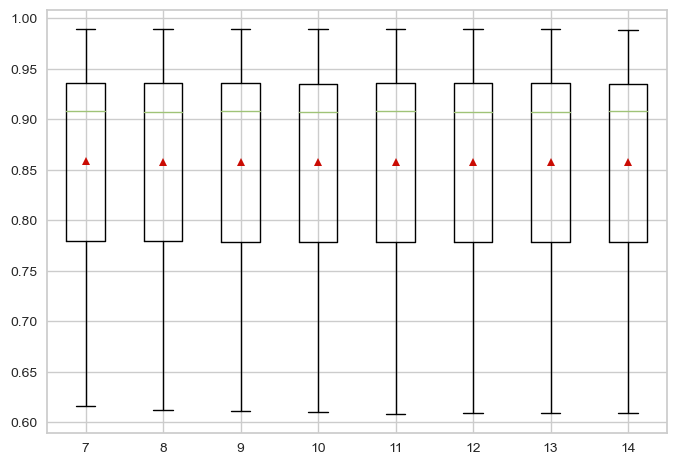

In [156]:
max_depth = [7, 8, 9, 10, 11, 12, 13, 14]
fonctions_models.regle_randomforest_maxdepth(max_depth, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **max_depth** = 9
> - Foruchette de recherche : max_depth = [8, 9, 10]

**Hyperparamètre : criterion**

**criterion** {“mse”, “mae”}, default=”mse” - Fonction permettant de mesurer la qualité d'un fractionnement. Les critères supportés sont "mse" pour l'erreur quadratique moyenne, qui est égale à la réduction de la variance comme critère de sélection des caractéristiques, et "mae" pour l'erreur absolue moyenne.

Hyperparam Test R2 +/- std Train R2 +/- std
>absolute_error 0.86134 (0.13316) 0.98030 (0.00201)
>squared_error 0.85757 (0.12311) 0.97892 (0.00215)
>friedman_mse 0.85799 (0.12145) 0.97894 (0.00209)


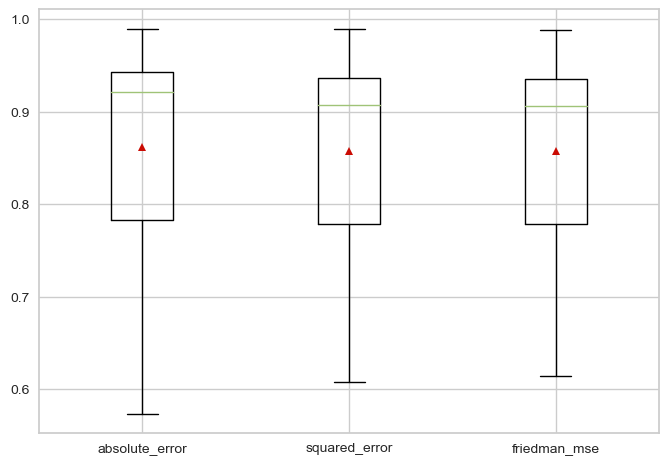

In [147]:
criterion = ['absolute_error', 'squared_error', 'friedman_mse']
fonctions_models.regle_randomforest_criterion(criterion, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **criterion** = 'absolute_error'
> - Foruchette de recherche : criterion = ['absolute_error', 'squared_error']

**Hyperparamètre : ccp_alpha**

**ccp_alpha** - non-negative float, default=0.0 - Paramètre de complexité utilisé pour l'élagage minimal de complexité-coût. Le sous-arbre avec la plus grande complexité de coût qui est plus petite que ccp_alpha sera choisi. Par défaut, aucun élagage n'est effectué.

Hyperparam Test R2 +/- std Train R2 +/- std
>0.0 0.85757 (0.12311) 0.97892 (0.00215)
>0.001 0.85714 (0.12173) 0.97283 (0.00257)
>0.003 0.85236 (0.12130) 0.96885 (0.00269)
>0.005 0.85004 (0.12291) 0.96528 (0.00328)
>0.0075 0.84183 (0.12118) 0.95613 (0.00406)
>0.01 0.83415 (0.12211) 0.94892 (0.00427)
>0.015 0.83074 (0.12293) 0.94314 (0.00493)
>0.02 0.82977 (0.12375) 0.93922 (0.00612)
>0.025 0.83198 (0.11602) 0.93252 (0.00753)
>0.03 0.82331 (0.12050) 0.92153 (0.00774)
>0.035 0.79770 (0.12190) 0.90017 (0.00908)


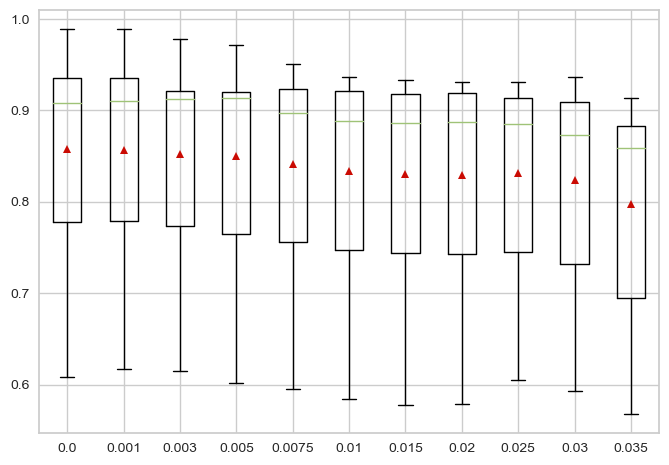

In [148]:
ccp_alpha = [0.0, 0.001, 0.003, 0.005, 0.0075,
             0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
fonctions_models.regle_randomforest_ccpalpha(ccp_alpha, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>0.0 0.85757 (0.12311) 0.97892 (0.00215)
>5e-05 0.85770 (0.12316) 0.97832 (0.00220)
>0.0001 0.85797 (0.12270) 0.97764 (0.00222)
>0.00015 0.85832 (0.12261) 0.97704 (0.00224)
>0.0002 0.85875 (0.12222) 0.97649 (0.00228)
>0.00025 0.85900 (0.12217) 0.97601 (0.00233)
>0.0003 0.85897 (0.12218) 0.97565 (0.00235)
>0.00035 0.85897 (0.12190) 0.97532 (0.00240)
>0.0004 0.85890 (0.12181) 0.97511 (0.00241)
>0.00045 0.85866 (0.12184) 0.97491 (0.00243)


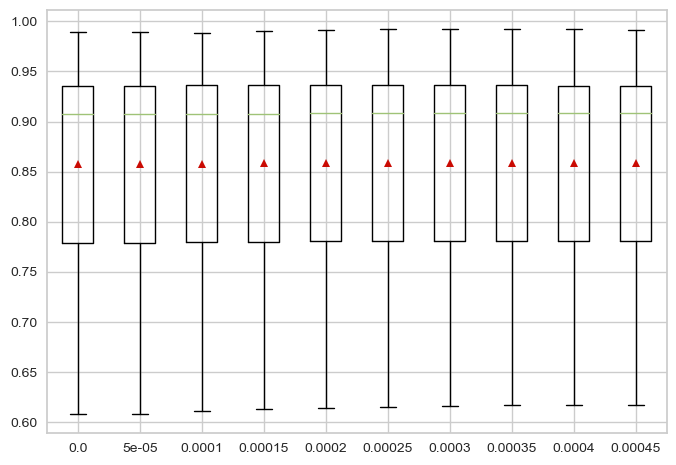

In [149]:
ccp_alpha = [0.0, 0.00005, 0.0001, 0.00015, 0.0002,
             0.00025, 0.0003, 0.00035, 0.0004, 0.00045]
regle_randomforest_ccpalpha(ccp_alpha, X_train_log, y_train_log)

Hyperparam Test R2 +/- std Train R2 +/- std
>0.00028 0.85893 (0.12219) 0.97581 (0.00233)
>0.00029 0.85890 (0.12226) 0.97573 (0.00233)
>0.0003 0.85897 (0.12218) 0.97565 (0.00235)
>0.00031 0.85902 (0.12214) 0.97558 (0.00236)
>0.00032 0.85902 (0.12205) 0.97552 (0.00237)
>0.00033 0.85902 (0.12198) 0.97545 (0.00237)


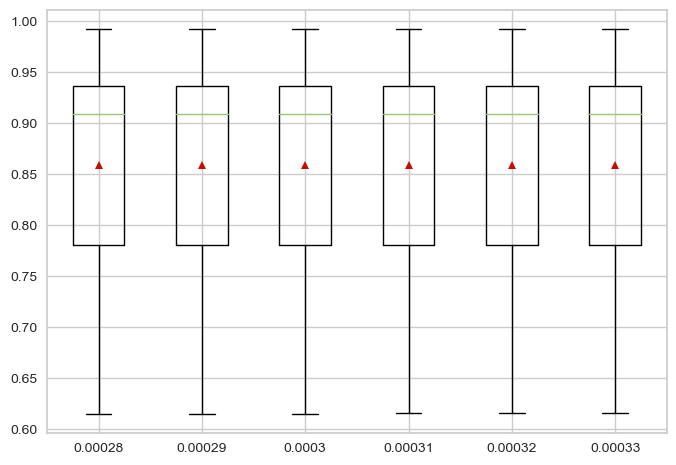

In [150]:
ccp_alpha = [0.00028, 0.00029, 0.0003, 0.00031, 0.00032, 0.00033]
fonctions_models.regle_randomforest_ccpalpha(ccp_alpha, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **ccp_alpha** = 0.00031
> - Fourchette de recherche : ccp_alpha = [0.00027,0.00028,0.00029,0.0003,0.00031,0.0003]

**Hyperparamètre : boostrap**

**bootstrap** - bool, default=False - Si les échantillons bootstrap sont utilisés lors de la construction des arbres. Si Faux, l'ensemble des données est utilisé pour construire chaque arbre.

Hyperparam Test R2 +/- std Train R2 +/- std
>True 0.85757 (0.12311) 0.97892 (0.00215)
>False 0.71722 (0.25564) 1.00000 (0.00000)


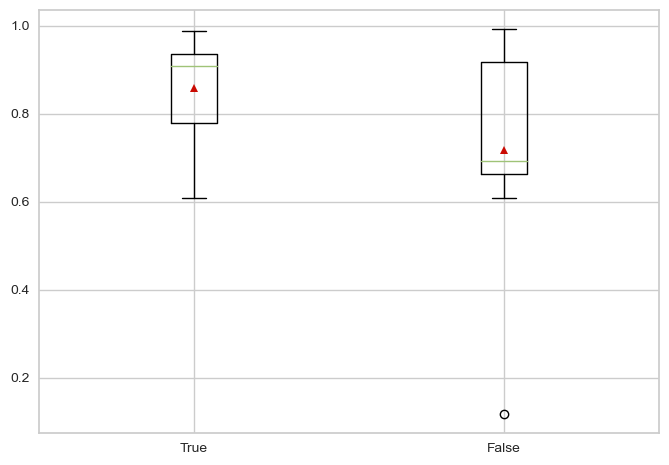

In [151]:
bootstrap = [True, False]
fonctions_models.regle_randomforest_bootstrap(bootstrap, X_train_log, y_train_log)

**Constat** :

> - Meilleur résultat : **bootstrap** = True.
> - Fourchette de recherche : bootstrap = [True, False]

**Entrainement et prédictions pour l'ensemble des valeurs des hyperparamètres trouvées**

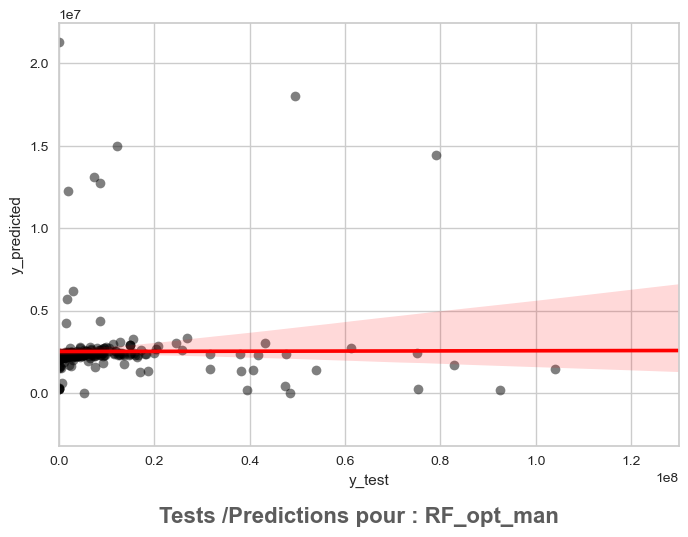

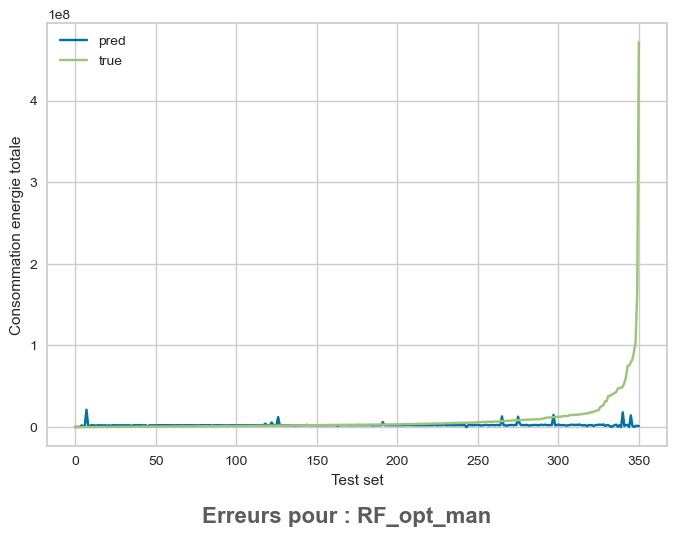

In [166]:
# Entrainement et prédictions pour l'ensemble des valeurs des hyperparamètres
# trouvées et conseiller par le guide utilisateur
model_et_manuel = RandomForestRegressor(n_estimators=310,
                                      min_samples_split=16,
                                      max_depth=9,
                                      max_features=19,
                                      random_state=seed
                                      )
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné 
# avec la variable cible transformée en log10 + 1
df_resultats_rfr, y_pred_et_man = fonctions_models.process_regression(model_et_manuel,
                                                                 X_train_log, X_test_log,
                                                                 y_train_log, y_test_log,
                                                                 df_resultats_rfr,
                                                                 'RF_opt_man')

In [28]:
# Target 'TotalGHGEmissions' non transformée
df_comp = fonctions_models.comparer_baseline_regressors(X_train_log_Co2, y_train_log_Co2)
df_comp.style.hide_index()

Exécution terminée - Modèle : dum_mean
Exécution terminée - Modèle : dum_med
Exécution terminée - Modèle : lin
Exécution terminée - Modèle : ridge
Exécution terminée - Modèle : lasso
Exécution terminée - Modèle : en
Exécution terminée - Modèle : svr
Exécution terminée - Modèle : br
Exécution terminée - Modèle : hr
Exécution terminée - Modèle : omp
Exécution terminée - Modèle : lars
Exécution terminée - Modèle : knr
Exécution terminée - Modèle : dt
Exécution terminée - Modèle : ada
Exécution terminée - Modèle : xgb
Exécution terminée - Modèle : sgd
Exécution terminée - Modèle : rfr
Exécution terminée - Modèle : etr
Exécution terminée - Modèle : cat
Exécution terminée - Modèle : gbr
Exécution terminée - Modèle : bag


# <span style='background :lightgreen' > 6. Optimisation des 3 algorithmes les plus performants sur les variables cibles  </span>


## <span style='background :lightblue' > 6.1 Influence des paramètres  </span>

In [37]:
# Dictionnaire des Random Search, et GridSearch pour conserver tous les résultats
randomCV_search_results = {}
gridCV_search_results = {}

In [40]:
# Distribution des indices train/validation pour obtenir des jeux train/validation.
# Divise le jeu de données en k partitions
kf = KFold(n_splits=4)

In [41]:
# Dictionnaires de résultats
y_pred = {}
rmse = {}
mae = {}
final_model = {}

In [42]:
# Pipeline pour les variables numériques
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ('attribs_combined', fonctions_models.CombinedAttributesAdder()), # Feature engineering
    ('std_scaler', StandardScaler()), # Normalisation des données
    ])

# Pipeline pour les variables catégorielles
cat_pipeline = Pipeline(steps=[
    ('target', TargetEncoder()),
    ('std_scaler', StandardScaler()), # Normalisation des données
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ])

# Pipeline pour les variables booléennes
add_bool_pipeline = Pipeline([
    ('bool_energy', fonctions_models.AddBooleanEnergyType()) # Les types sont converties en variables booléennes
])

In [43]:
# Labelize les variables catégorielles et les ajoute aux variables numériques transformés
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, cols_num),
        ("energyType", add_bool_pipeline, list_energy_type),
        ("cat", cat_pipeline, cols_cat)
    ])


**Modèles candidats pour le variable consommation d'énergie (SiteEnergyUseWNLog)**

In [44]:
# Modèles à hyper-paramétriser

regressors_vc1 = {
                'Gradient Boosting': GradientBoostingRegressor(random_state=42),
                'Random Forest': RandomForestRegressor(random_state=42),
                'XGBoosting': XGBRegressor(random_state=42)
}

**Modèles candidats pour le variable emissions Co2 (TotalGHGEmissionsLog)**

In [45]:
# Modèles à hyper-paramétriser

regressors_vc2 = {
                'Gradient Boosting': GradientBoostingRegressor(random_state=42),
                'Extra Forest': ExtraTreesRegressor(random_state=42),
                'XGBoosting': XGBRegressor(random_state=42)
}

In [46]:
# Hyperparamères pour les modèles ensemblistes d'arbres de regression
param_grid_reg_tree = {
    'preprocess__num__imputer__strategy': ['mean', 'median'],# Méthode d'imputation des variables numériques
    'preprocess__cat__imputer__strategy': ['mean', 'median', 'most_frequent'] # Méthode d'imputation des variables catégorielles
}

# Ajout du paramètre learning rate pour le Gradient Boosting
param_grid_gb = param_grid_reg_tree.copy()
param_grid_gb["regressor__n_estimators"] = [80, 90, 100]
param_grid_gb["regressor__max_features"] = [8, 9, 10, 11]
param_grid_gb["regressor__learning_rate"] =  [0.11, 0.12, 0.13, 0.14]
param_grid_gb["regressor__max_depth"] = [1, 2, 3]
param_grid_gb['regressor__min_samples_leaf'] =  [13, 14, 15]
param_grid_gb["regressor__min_samples_split"] = [5, 6, 7, 8, 9]


#Hyparamètres pour le Extreme Gradient Boosting
param_grid_xgb = param_grid_reg_tree.copy()
param_grid_xgb["regressor__n_estimators"] = [80, 90, 100]
param_grid_xgb["regressor__max_depth"] = [3, 4, 5]
param_grid_xgb["regressor__learning_rate"] =  [0.11, 0.12, 0.13, 0.14]


#Hyperparamètres pour le Random Forest
param_grid_rf = param_grid_reg_tree.copy()
param_grid_rf["regressor__n_estimators"] = [290, 300, 310]  
param_grid_rf["regressor__max_features"] = [14, 15, 16, 17, 18]
param_grid_rf["regressor__max_leaf_nodes"] = [480,490,500,510,520,530]
param_grid_rf["regressor__min_impurity_decrease"] = [0.0003,0.00031, 0.00032, 0.00033]
param_grid_rf["regressor__min_samples_leaf"] = [4,5,6,7]
param_grid_rf["regressor__min_samples_split"] = [25, 26, 27, 28, 29]
param_grid_rf["regressor__ccp_alpha"] = [0.00027,0.00028,0.00029,0.0003,0.00031,0.0003]
#param_grid_rf["boostrap"] = True


#Hyperparamètre pour l'Extra Forest
param_grid_ef = param_grid_reg_tree.copy()
param_grid_ef["regressor__n_estimators"] = [570, 580, 590]
param_grid_ef["regressor__max_features"] = [18, 19, 20]
param_grid_ef["regressor__min_samples_split"] = [26, 27, 28, 29, 30]
param_grid_ef["regressor__min_impurity_decrease"] = [0.00028,0.00029, 0.0003,0.00031]
param_grid_ef["regressor__min_samples_leaf"] = [8,9,10,11]
param_grid_ef["regressor__max_leaf_nodes"] = [84,85,86,87,88,89]
param_grid_ef["regressor__min_samples_split"] = [26, 27, 28, 29, 30]
param_grid_ef["regressor__min_samples_leaf"] = [1, 2, 3, 4, 5, 6, 10]
#param_grid_ef["boostrap"] = True



# Dictionnaire de grille de paramètres
param_grid = {'Gradient Boosting': param_grid_gb,
              'XGBoosting': param_grid_xgb,
              'Extra Forest' : param_grid_ef,
              'Random Forest' :  param_grid_rf
             }

In [47]:
# Hyperparamères pour les modèles ensemblistes d'arbres de regression
param_grid_reg_tree = {
    'preprocess__num__imputer__strategy': ['mean', 'median'],# Méthode d'imputation des variables numériques
    'preprocess__cat__imputer__strategy': ['mean', 'median', 'most_frequent'] # Méthode d'imputation des variables catégorielles
}    


# Ajout du paramètre learning rate pour le Gradient Boosting
param_grid_gb = param_grid_reg_tree.copy()
param_grid_gb["regressor__n_estimators"] = [80, 90, 100]
param_grid_gb["regressor__max_features"] = [8, 9, 10]
param_grid_gb["regressor__learning_rate"] =  [0.12, 0.13, 0.14]
param_grid_gb["regressor__max_depth"] = [1, 2, 3]
param_grid_gb['regressor__min_samples_leaf'] =  [13, 14, 15]
param_grid_gb["regressor__min_samples_split"] = [6, 7, 8, 9]


#Hyparamètres pour le Extreme Gradient Boosting
param_grid_xgb = param_grid_reg_tree.copy()
param_grid_xgb["regressor__n_estimators"] = [80, 90, 100]
param_grid_xgb["regressor__max_depth"] = [3, 4, 5]
param_grid_xgb["regressor__learning_rate"] =  [0.12, 0.13, 0.14]


#Hyperparamètres pour le Random Forest
param_grid_rf = param_grid_reg_tree.copy()
param_grid_rf["regressor__n_estimators"] = [300, 310]  
param_grid_rf["regressor__max_features"] = [15, 16, 17]
param_grid_rf["regressor__min_samples_leaf"] = [4,5,6]
param_grid_rf["regressor__min_samples_split"] = [26, 27, 28]


#Hyperparamètre pour l'Extra Forest
param_grid_ef = param_grid_reg_tree.copy()
param_grid_ef["regressor__n_estimators"] = [570, 580, 590]
param_grid_ef["regressor__max_features"] = [18, 19, 20]
param_grid_ef["regressor__min_samples_split"] = [28, 29, 30]
param_grid_ef["regressor__min_samples_leaf"] = [8, 9, 10]



# Dictionnaire de grille de paramètres
param_grid_grd_CV = {'Gradient Boosting': param_grid_gb,
              'Random Forest': param_grid_reg_tree,
              'XGBoosting': param_grid_xgb,
              'Extra Forest' : param_grid_ef
             }

## <span style='background :lightblue' > 6.2  Etude des 3 algorithmes sur la variable consommation d'énergie en log </span>

### <span style='background : navajowhite' > 6.2.1  RandomizedSearchCV - Recherche sur grille aléatoire avec validation croisée (variable consommation d'énergie en log) </span>

Gradient Boosting
Paramètres du meilleur modèle (RandomizedSearchCV) : 

	 -  regressor__n_estimators : 80
	 -  regressor__min_samples_split : 7
	 -  regressor__min_samples_leaf : 15
	 -  regressor__max_features : 8
	 -  regressor__max_depth : 2
	 -  regressor__learning_rate : 0.11
	 -  preprocess__num__imputer__strategy : median
	 -  preprocess__cat__imputer__strategy : most_frequent

Résultats :

	 - r2 score (RandomizedSearchCV) sur le jeu d'entrainement : 0.923
	 - Mean of RMSE(RandomizedSearchCV) : 0.942
	 - Ecart-type(RandomizedSearchCV) : 0.215
	 - Coefficient de variation(RandomizedSearchCV) : 22.81 % 

Random Forest
Paramètres du meilleur modèle (RandomizedSearchCV) : 

	 -  regressor__n_estimators : 300
	 -  regressor__min_samples_split : 29
	 -  regressor__min_samples_leaf : 4
	 -  regressor__min_impurity_decrease : 0.00033
	 -  regressor__max_leaf_nodes : 510
	 -  regressor__max_features : 14
	 -  regressor__ccp_alpha : 0.00027
	 -  preprocess__num__imputer__strategy : mean

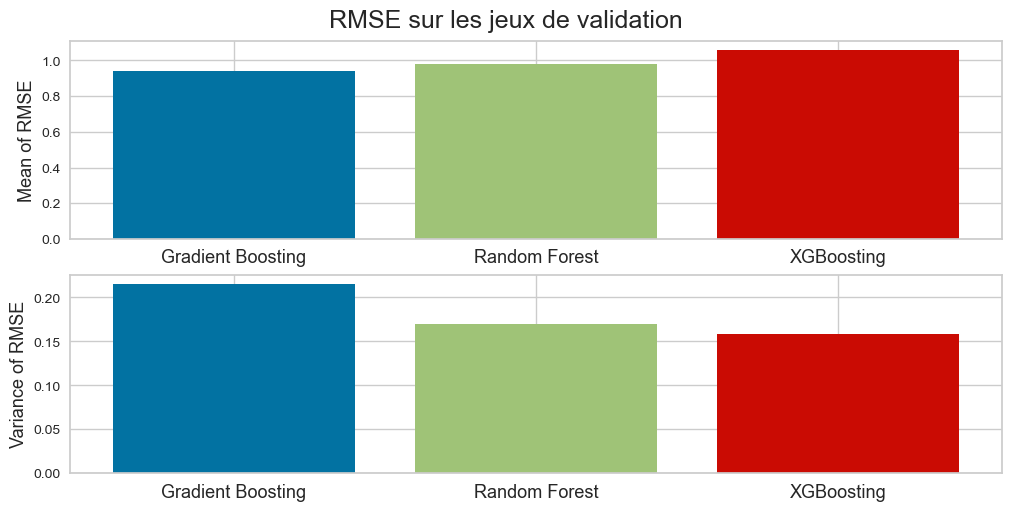

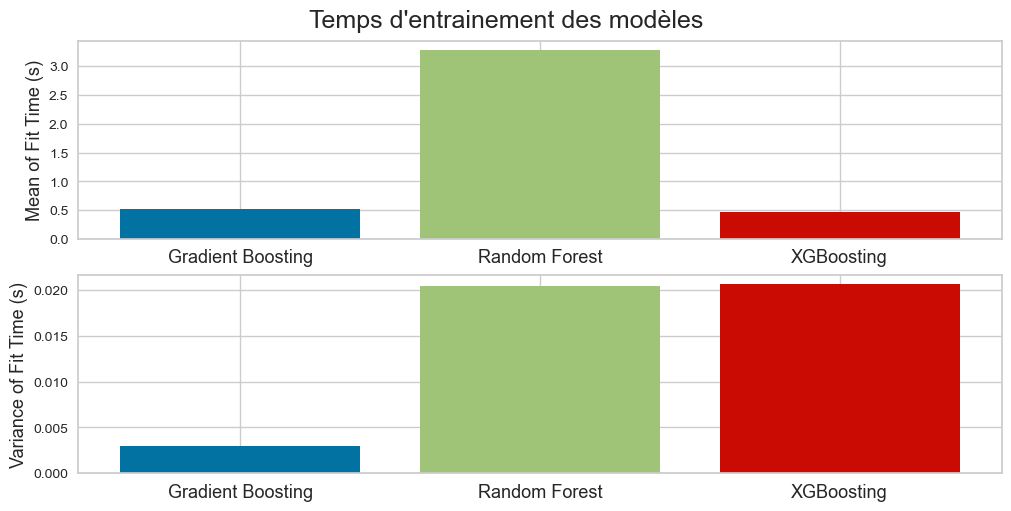

In [50]:
# Selection du meilleur modèle (Randomized Search CV)
randomCV_search_results["SiteEnergyUseWNLog"] = fonctions_models.randomCV_search(regressors_vc1, 
                                               full_pipeline,
                                               param_grid,
                                               X_train_log,
                                               y_train_log)

Le modèle Gradient Boosting est celui qui donne les meilleurs résultats en terme de RMSE,et pour son temps d'entrainement avec la méthode Random Search CV.

In [51]:
final_model["SiteEnergyUseWNLog"] = randomCV_search_results["SiteEnergyUseWNLog"]['Gradient Boosting'].best_estimator_

### <span style='background : navajowhite' > 6.2.2 GridSearchCV - Recherche sur grille aléatoire avec validation croisée (variable consommation d'énergie en log) </span>

Gradient Boosting
Paramètres du meilleur modèle (GridSearchCV) : 

	 -  preprocess__cat__imputer__strategy : mean
	 -  preprocess__num__imputer__strategy : mean
	 -  regressor__learning_rate : 0.12
	 -  regressor__max_depth : 2
	 -  regressor__max_features : 8
	 -  regressor__min_samples_leaf : 15
	 -  regressor__min_samples_split : 6
	 -  regressor__n_estimators : 80

Résultats :

	 - r2 score (GridSearchCV) sur le jeu d'entrainement : 0.932
	 - Mean of RMSE(GridSearchCV) : 0.942
	 - Ecart-type(GridSearchCV) : 0.211
	 - Coefficient de variation(GridSearchCV) : 22.37 % 

Random Forest
Paramètres du meilleur modèle (GridSearchCV) : 

	 -  preprocess__cat__imputer__strategy : mean
	 -  preprocess__num__imputer__strategy : mean

Résultats :

	 - r2 score (GridSearchCV) sur le jeu d'entrainement : 0.977
	 - Mean of RMSE(GridSearchCV) : 1.086
	 - Ecart-type(GridSearchCV) : 0.130
	 - Coefficient de variation(GridSearchCV) : 11.94 % 

XGBoosting
Paramètres du meilleur modèle (GridSearchCV) : 

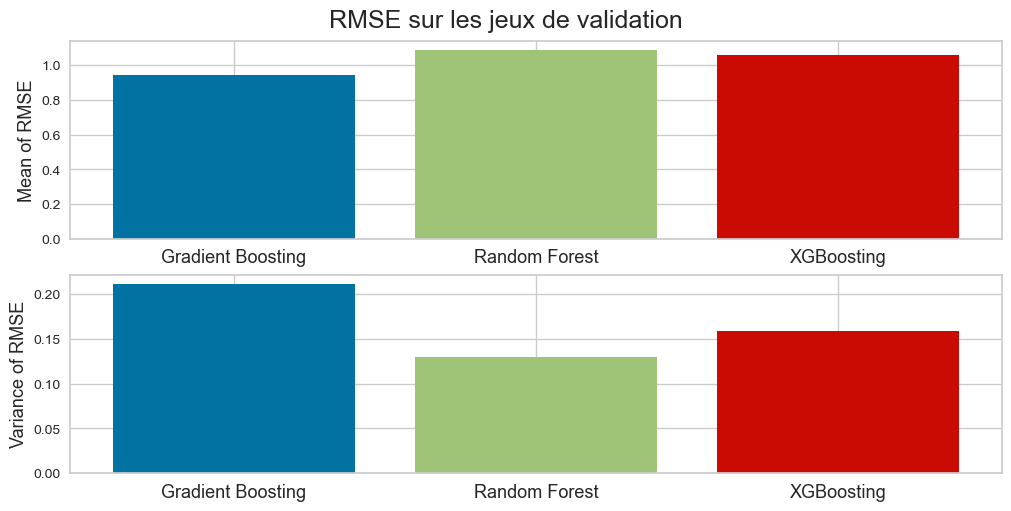

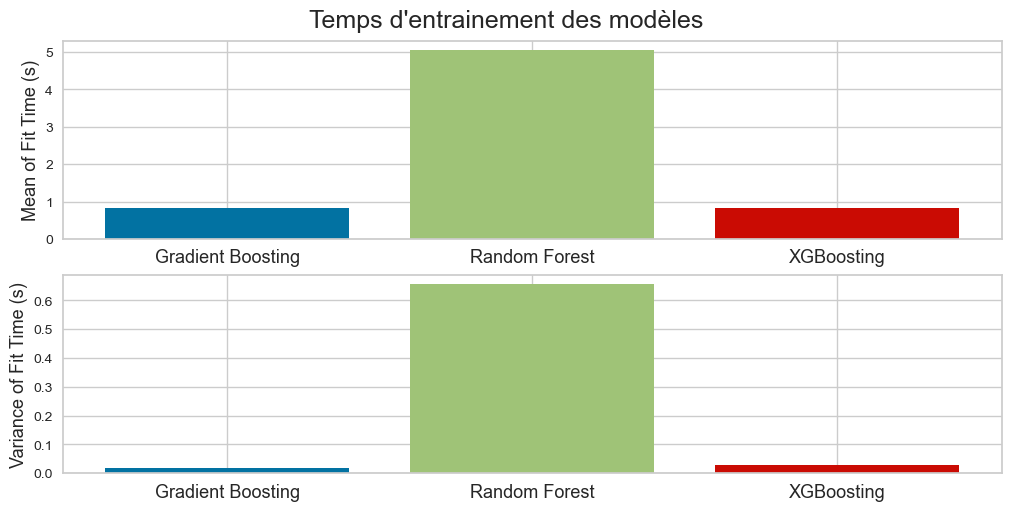

In [52]:
# Selection du meilleur modèle(Grid Search CV)
gridCV_search_results["SiteEnergyUseWNLog"] = fonctions_models.gridCV_search(regressors_vc1, 
                                               full_pipeline,
                                               param_grid_grd_CV,
                                               X_train_log,
                                               y_train_log)

In [53]:
final_model["SiteEnergyUseWNLog"] = gridCV_search_results["SiteEnergyUseWNLog"]['Gradient Boosting'].best_estimator_

## <span style='background :lightblue' > 6.3  Etude des 3 algorithmes sur la variable émissions Co2 en log </span>

In [54]:
# Analyse de la target 'TotalGHGEmissions' transformée en logarithme
y_log_Co2 = data_prepro['TotalGHGEmissionsLog']
y_log_Co2.shape

(1755,)

- **Target 'TotalGHGEmissionsLog' (Target TotalGHGEmissions transformée en log10 + 1)**

In [55]:
# Découpage du jeu de données en train set et test set cilble transformée
X_train_log_Co2, X_test_log_Co2, y_train_log_Co2, y_test_log_Co2 = train_test_split(
    X, y_log_Co2, test_size=0.2, random_state=seed)
print(f'X_train_log_Co2 : {X_train_log_Co2.shape} - X_test_log_Co2 : {X_test_log_Co2.shape}')
print(f'y_train_log_Co2 : {y_train_log_Co2.shape} - y_test_log_Co2 : {y_test_log_Co2.shape}')

X_train_log_Co2 : (1404, 29) - X_test_log_Co2 : (351, 29)
y_train_log_Co2 : (1404,) - y_test_log_Co2 : (351,)


- **Mise en place du pipeline (variables catégorielles, et numériques)**  

In [56]:
# Pipeline pour les variables numériques
num_pipeline_Co2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ('attribs_combined', fonctions_models.CombinedAttributesAdder()), # Feature engineering
    ('std_scaler', StandardScaler()), # Normalisation des données
    ])

# Pipeline pour les variables catégorielles
cat_pipeline_Co2 = Pipeline(steps=[
    ('target', TargetEncoder()),
    ('std_scaler', StandardScaler()), # Normalisation des données
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ])

# Pipeline pour les variables énergétiques (ajout des prédictions)
energy_pipeline = Pipeline([
    # Les consommations d'énergies sont prédites
    ('bool_energy', fonctions_models.AddEnergyTypePredicted(list_energy_type)) 
])

# Pipeline de transformation des variables pour la prédiction du Co2
full_pipeline_co2 = ColumnTransformer([
        ("num", num_pipeline_Co2, cols_num),
        #("energyType", energy_pipeline, list(X_train_log_Co2.columns)),
        ("energyType", add_bool_pipeline, list_energy_type),
        ("cat", cat_pipeline_Co2, cols_cat),
    ])

### <span style='background : navajowhite' > 6.3.1   RandomizedSearchCV - Recherche sur grille aléatoire avec validation croisée (variable d'émissions Co2 en log) </span>

Gradient Boosting
Paramètres du meilleur modèle (RandomizedSearchCV) : 

	 -  regressor__n_estimators : 100
	 -  regressor__min_samples_split : 8
	 -  regressor__min_samples_leaf : 14
	 -  regressor__max_features : 8
	 -  regressor__max_depth : 1
	 -  regressor__learning_rate : 0.11
	 -  preprocess__num__imputer__strategy : mean
	 -  preprocess__cat__imputer__strategy : most_frequent

Résultats :

	 - r2 score (RandomizedSearchCV) sur le jeu d'entrainement : 0.928
	 - Mean of RMSE(RandomizedSearchCV) : 0.470
	 - Ecart-type(RandomizedSearchCV) : 0.024
	 - Coefficient de variation(RandomizedSearchCV) : 5.10 % 

Extra Forest
Paramètres du meilleur modèle (RandomizedSearchCV) : 

	 -  regressor__n_estimators : 580
	 -  regressor__min_samples_split : 30
	 -  regressor__min_samples_leaf : 10
	 -  regressor__min_impurity_decrease : 0.0003
	 -  regressor__max_leaf_nodes : 87
	 -  regressor__max_features : 18
	 -  preprocess__num__imputer__strategy : median
	 -  preprocess__cat__imputer__strate

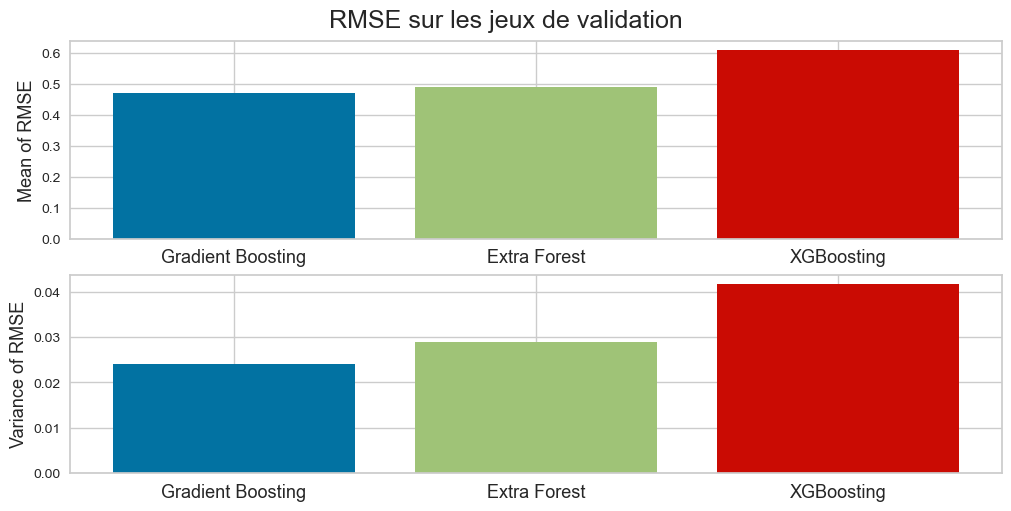

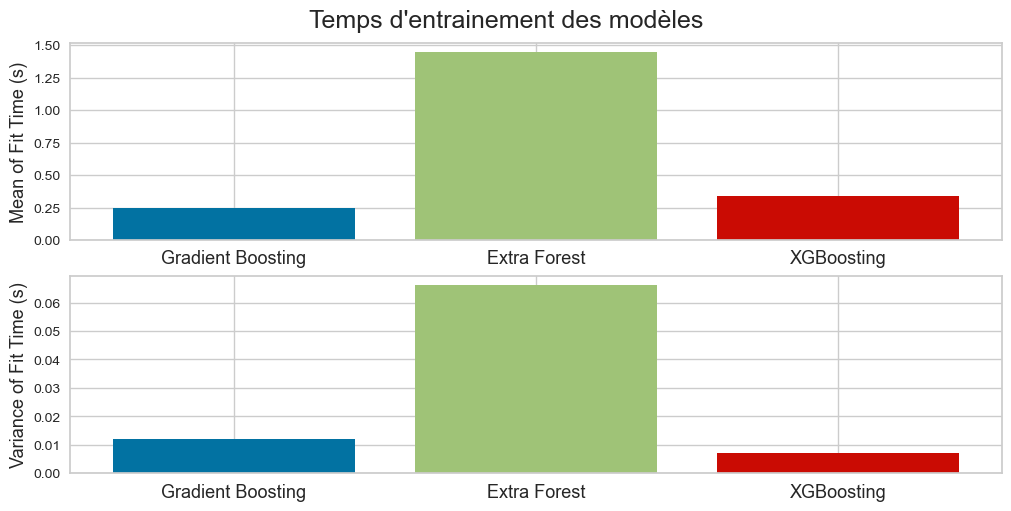

In [57]:
# Selection du meilleur modèle
randomCV_search_results["TotalGHGEmissionsLog"] = fonctions_models.randomCV_search(regressors_vc2, 
                                                     full_pipeline_co2,
                                                     param_grid,
                                                     X_train_log_Co2,
                                                     y_train_log_Co2)

Le meilleur modèle est l'Extra Forest avec la RMSE. En revanche, sa durée d'entrainement se situe légèrement au-dessus de la moyenne.

In [58]:
# Conservation du meilleur modèle pour la prédiction des gaz à effet de serre
final_model["TotalGHGEmissionsLog"] = randomCV_search_results["TotalGHGEmissionsLog"]["Gradient Boosting"].best_estimator_

### <span style='background : navajowhite' > 6.3.2 GridSearchCV - Recherche sur grille aléatoire avec validation croisée (variable émisions Co2 en log) </span>

Gradient Boosting
Paramètres du meilleur modèle (GridSearchCV) : 

	 -  preprocess__cat__imputer__strategy : mean
	 -  preprocess__num__imputer__strategy : mean
	 -  regressor__learning_rate : 0.12
	 -  regressor__max_depth : 1
	 -  regressor__max_features : 8
	 -  regressor__min_samples_leaf : 14
	 -  regressor__min_samples_split : 6
	 -  regressor__n_estimators : 90

Résultats :

	 - r2 score (GridSearchCV) sur le jeu d'entrainement : 0.927
	 - Mean of RMSE(GridSearchCV) : 0.471
	 - Ecart-type(GridSearchCV) : 0.024
	 - Coefficient de variation(GridSearchCV) : 5.16 % 

Extra Forest
Paramètres du meilleur modèle (GridSearchCV) : 

	 -  preprocess__cat__imputer__strategy : mean
	 -  preprocess__num__imputer__strategy : mean
	 -  regressor__max_features : 18
	 -  regressor__min_samples_leaf : 10
	 -  regressor__min_samples_split : 30
	 -  regressor__n_estimators : 590

Résultats :

	 - r2 score (GridSearchCV) sur le jeu d'entrainement : 0.952
	 - Mean of RMSE(GridSearchCV) : 0.489
	 - Ec

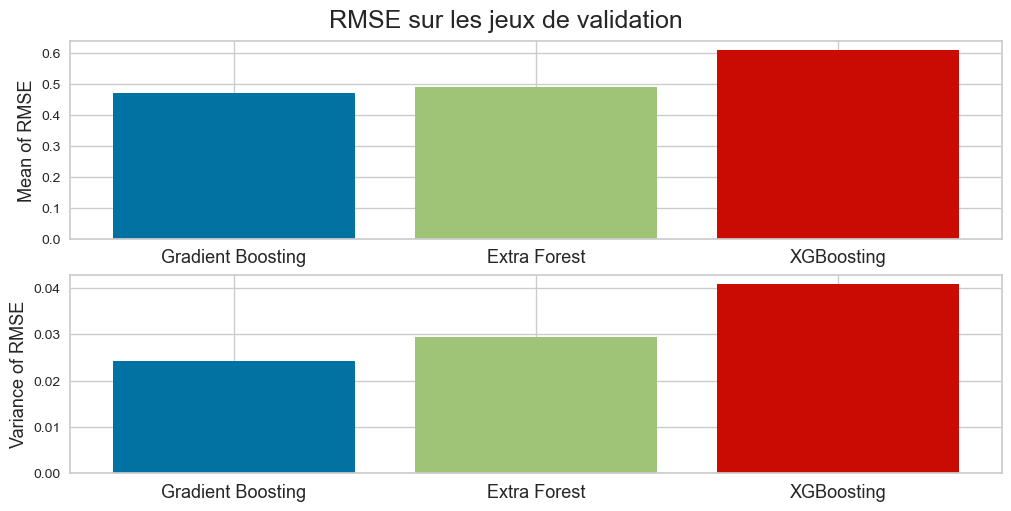

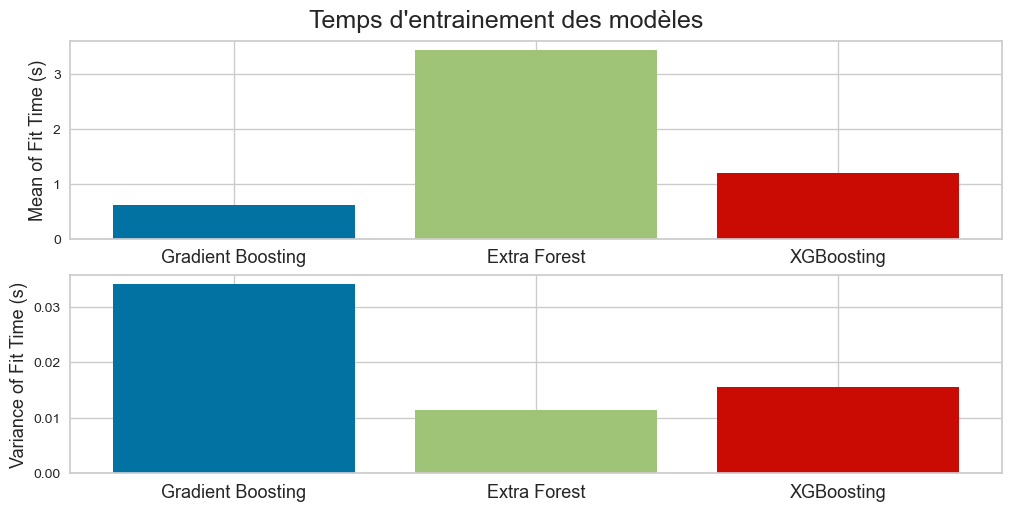

In [59]:
# Selection du meilleur modèle(Grid Search CV)
gridCV_search_results["TotalGHGEmissionsLog"] = fonctions_models.gridCV_search(regressors_vc2, 
                                               full_pipeline_co2,
                                               param_grid_grd_CV,
                                               X_train_log_Co2,
                                               y_train_log_Co2)

In [60]:
final_model["TotalGHGEmissionsLog"] = gridCV_search_results["TotalGHGEmissionsLog"]["Gradient Boosting"].best_estimator_

**Affichage graphique des termes d'erreurs et prédictions des modèles optimisés sur les 2 variables cibles**

## <span style='background :lightblue' > 6.4  Modèle GradientBoostingRegressor Optimisé(variable 'SiteEnergyUseWNLog') </span>

In [61]:
# Création d'un dataframe stockant les résultats des algorithmes les plus
# performants pour nos variables cibles

df_best_models = pd.DataFrame(dtype='object')

In [62]:
# Encodage des données de consommation d'énergie transformée en log10
target_encoder = TargetEncoder()
X_train_log[cols_cat] = target_encoder.fit_transform(
    X_train_log[cols_cat], y_train_log)
X_test_log[cols_cat] = target_encoder.transform(X_test_log[cols_cat])

In [63]:
# Jeu de la target de consommation d'énergie transformée en log10
scaler_rob = RobustScaler()
X_train_log[cols_num] = scaler_rob.fit_transform(
    X_train_log[cols_num].copy(deep=True))
X_test_log[cols_num] = scaler_rob.transform(
    X_test_log[cols_num].copy(deep=True))

In [129]:
# Modèle GradientGBoosting optimisé
# Instanciation du modèle optimisé (de la méthode Randomized Search CV)


gb_optimise_rnd_v1 = GradientBoostingRegressor(n_estimators=80, max_features = 8, max_depth = 2, min_samples_split = 15, min_samples_leaf = 15,  \
                                        learning_rate = 0.11)

# Entraînement du modèle
gb_optimise_rnd_v1.fit(X_train_log, y_train_log)

GradientBoostingRegressor(learning_rate=0.11, max_depth=2, max_features=8,
                          min_samples_leaf=15, min_samples_split=15,
                          n_estimators=80)

In [138]:
# Modèle GradientBoosting optimisé
# Instanciation du modèle optimisé (de la méthode Grid Search CV)


gb_optimise_grd_v1 = GradientBoostingRegressor(n_estimators=80, max_features = 8, max_depth = 2, min_samples_split = 6, min_samples_leaf = 15,\
                                        learning_rate = 0.12)


# Entraînement du modèle
gb_optimise_grd_v1.fit(X_train_log, y_train_log)

GradientBoostingRegressor(learning_rate=0.11, max_depth=1, max_features=8,
                          min_samples_leaf=14, min_samples_split=8)

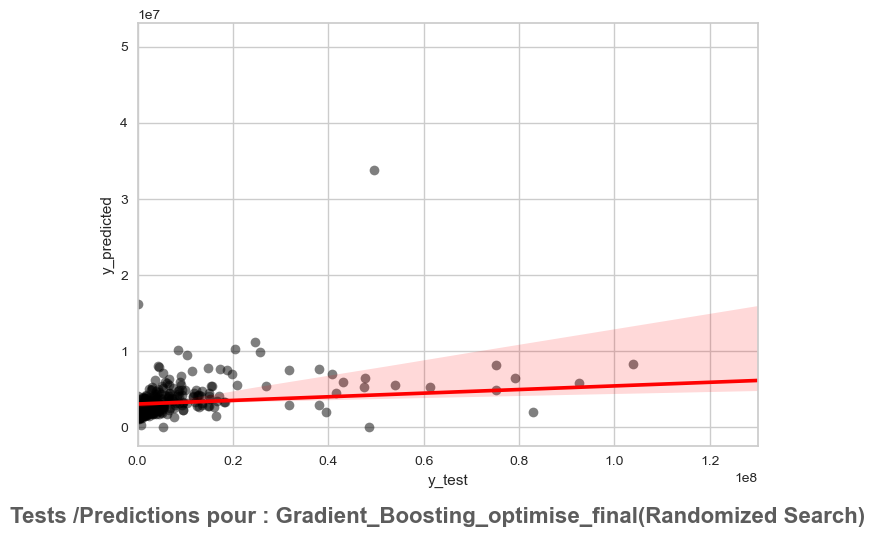

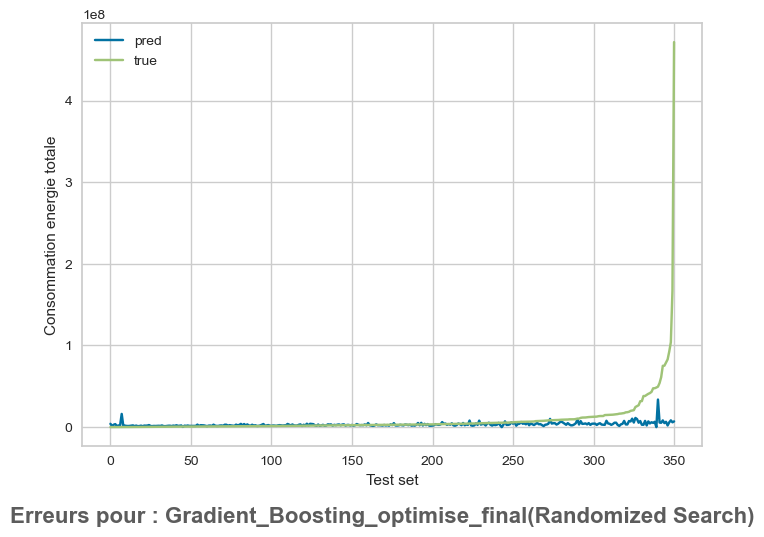

In [66]:
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné (Randomized Search)
# avec la variable cible transformée

df_best_models, y_pred_gb_optimise_rnd = fonctions_models.process_regression(gb_optimise_rnd_v1,
                                                                        X_train_log, X_test_log,
                                                                         y_train_log, y_test_log,
                                                                        df_best_models,
                                                                        'Gradient_Boosting_optimise_final(Randomized Search)')

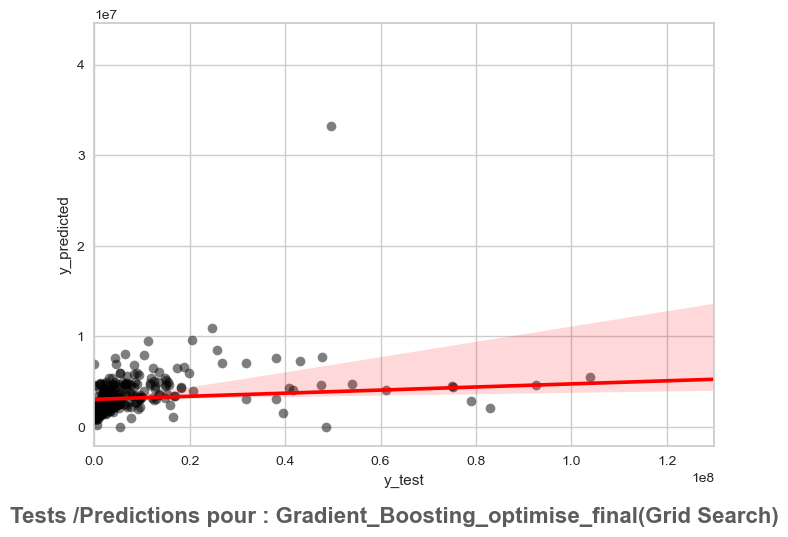

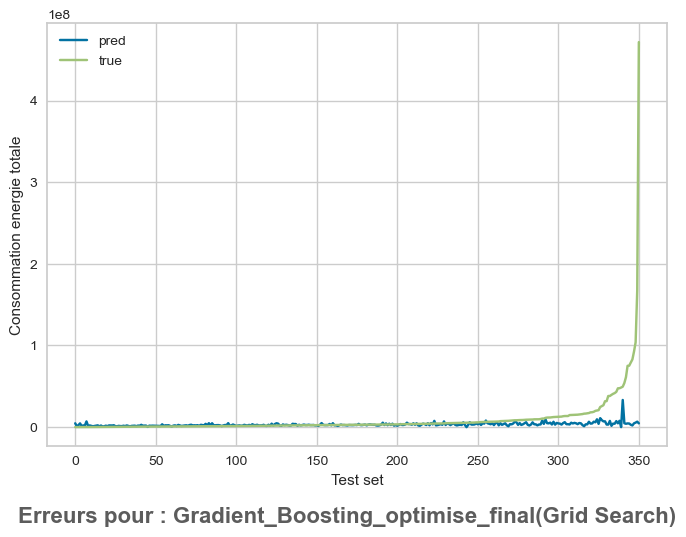

In [67]:
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné (Grid Search)
# avec la variable cible transformée

df_best_models, y_pred_gb_optimise_grd = fonctions_models.process_regression(gb_optimise_grd_v1,
                                                                        X_train_log, X_test_log,
                                                                         y_train_log, y_test_log,
                                                                        df_best_models,
                                                                        'Gradient_Boosting_optimise_final(Grid Search)')

## <span style='background :lightblue' > 6.5  Modèle Gradient Boosting Regressor Optimisé (variable 'TotalGHGEmissionsLog') </span>

In [68]:
# Encodage des données de consommation d'énergie transformée en log10
target_encoder = TargetEncoder()
X_train_log_Co2[cols_cat] = target_encoder.fit_transform(
    X_train_log_Co2[cols_cat], y_train_log_Co2)
X_test_log_Co2[cols_cat] = target_encoder.transform(X_test_log_Co2[cols_cat])

In [69]:
# Jeu de la target de consommation d'énergie transformée en log10
scaler_rob = RobustScaler()
X_train_log_Co2[cols_num] = scaler_rob.fit_transform(
    X_train_log_Co2[cols_num].copy(deep=True))
X_test_log_Co2[cols_num] = scaler_rob.transform(
    X_test_log_Co2[cols_num].copy(deep=True))

In [70]:
# Modèle GradientBoostingRegressor optimisé (méthode Randomiezd Search CV)
# Instanciation du modèle optimisé


gb_optimise_rnd_v2 = GradientBoostingRegressor(n_estimators=100, min_samples_split = 8, min_samples_leaf = 14, max_features = 8, \
                                              max_depth = 1, learning_rate = 0.11)



# Entraînement du modèle
gb_optimise_rnd_v2.fit(X_train_log_Co2, y_train_log_Co2)        
        

GradientBoostingRegressor(learning_rate=0.11, max_depth=1, max_features=8,
                          min_samples_leaf=14, min_samples_split=8)

In [72]:
# Modèle GradientBoostingRegressor optimisé (méthode Grid Search CV)
# Instanciation du modèle optimisé


gb_optimise_grd_v2 = GradientBoostingRegressor(n_estimators=90, min_samples_split = 6, min_samples_leaf = 14, max_features = 8, \
                                  max_depth = 1, learning_rate = 0.12)
        

# Entraînement du modèle
gb_optimise_grd_v2.fit(X_train_log_Co2, y_train_log_Co2)        
        

GradientBoostingRegressor(learning_rate=0.12, max_depth=1, max_features=8,
                          min_samples_leaf=14, min_samples_split=6,
                          n_estimators=90)

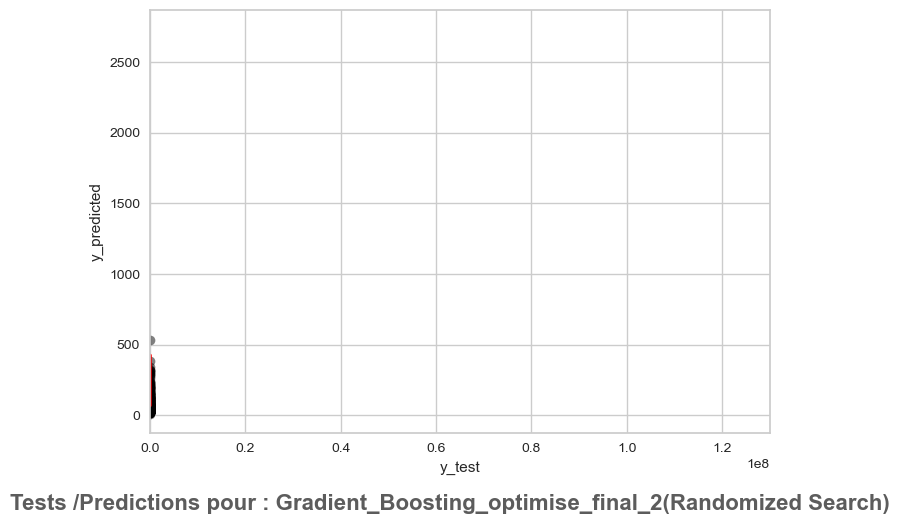

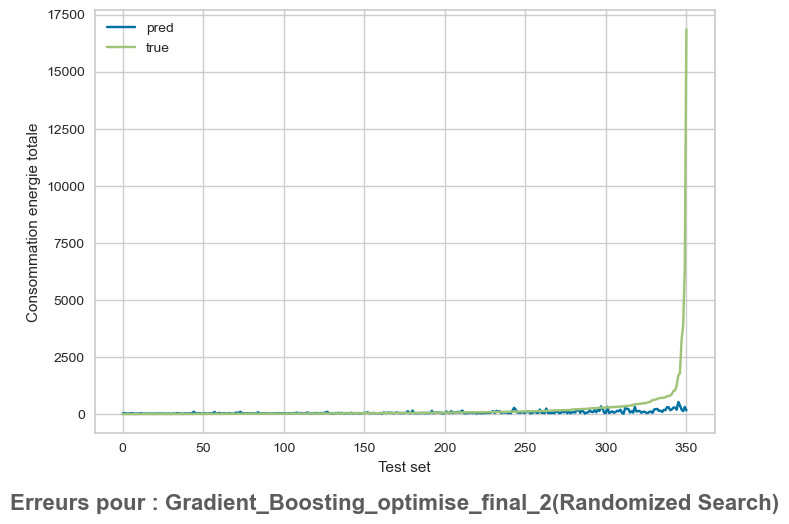

In [74]:
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné 
# avec la variable cible transformée

df_best_models, y_pred_gb_optimise_rnd = fonctions_models.process_regression(gb_optimise_rnd_v2,
                                                                        X_train_log_Co2, X_test_log_Co2,
                                                                         y_train_log_Co2, y_test_log_Co2,
                                                                        df_best_models,
                                                                        'Gradient_Boosting_optimise_final_2(Randomized Search)')

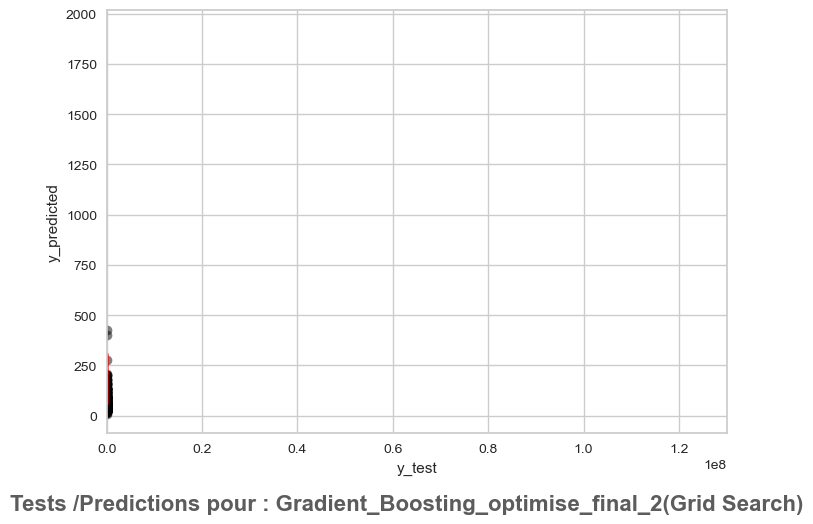

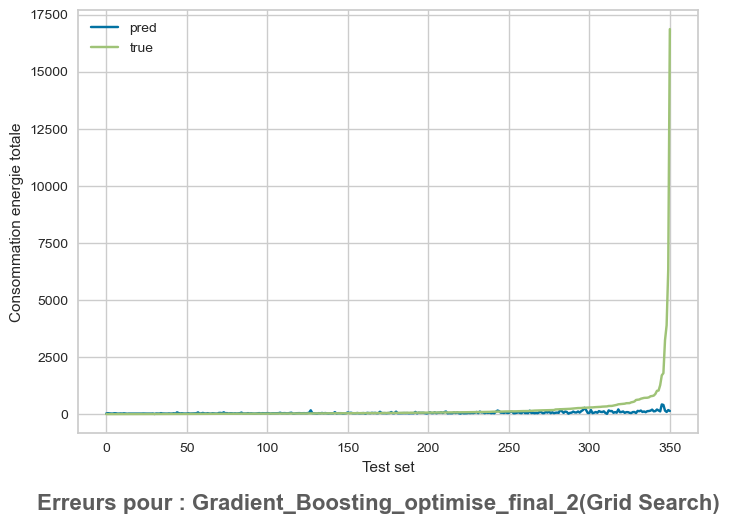

In [76]:
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné (Grid Search)
# avec la variable cible transformée

df_best_models, y_pred_ef_optimise_grd = fonctions_models.process_regression(gb_optimise_grd_v2,
                                                                        X_train_log_Co2, X_test_log_Co2,
                                                                         y_train_log_Co2, y_test_log_Co2,
                                                                        df_best_models,
                                                                        'Gradient_Boosting_optimise_final_2(Grid Search)')

## <span style='background :lightblue' > 6.6  Etude des 3 algorithmes avec la variable 'ENERGYSTARscore' </span>

In [86]:
# Variable 'ENERGYSTARScore' à ajouter
cols_energystar = 'ENERGYSTARScore'

# Liste des variables numériques pour la prédiction du Co2
cols_num_Co2 = cols_num.copy()

# Liste des variables catégoriques pour la prédiction du Co2
cols_cat_Co2 = cols_cat.copy()
cols_cat_Co2.append(cols_energystar)

In [87]:
# Variables quantitatives
cols_num_Co2 = data.select_dtypes(include=[np.number]).columns.to_list()
# Suppression des variables cibles
del cols_num_Co2[0:5]
cols_num_Co2

['CouncilDistrictCode',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'OtherFuelUse(kBtu)',
 'Longitude',
 'Latitude',
 'ZipCode',
 'lat_long_bin',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'TauxThirdtUseGFA',
 'BuildingAge']

In [88]:
# Matrice X
X_log_Co2 = data_prepro[cols_cat_Co2+cols_num_Co2]
X_log_Co2.shape

(1755, 30)

In [89]:
# Analyse de la target 'SiteEnergyUseWNLog' transformée en logarithme
y_log_Co2 = data_prepro['TotalGHGEmissionsLog']
y_log_Co2.shape

(1755,)

- **Target 'TotalGHGEmissionsLog' (Target TotalGHGEmissions transformée en log10 + 1)**

In [90]:
# Découpage du jeu de données en train set et test set cilble transformée
X_train_log_Co2, X_test_log_Co2, y_train_log_Co2, y_test_log_Co2 = train_test_split(
    X_log_Co2, y_log_Co2, test_size=0.2, random_state=seed)
print(f'X_train_log_Co2 : {X_train_log_Co2.shape} - X_test_log_Co2 : {X_test_log_Co2.shape}')
print(f'y_train_log_Co2 : {y_train_log_Co2.shape} - y_test_log_Co2 : {y_test_log_Co2.shape}')

X_train_log_Co2 : (1404, 30) - X_test_log_Co2 : (351, 30)
y_train_log_Co2 : (1404,) - y_test_log_Co2 : (351,)


In [98]:
# Encodage des données de consommation d'énergie transformée en log10
target_encoder = TargetEncoder()
X_train_log_Co2[cols_cat] = target_encoder.fit_transform(
    X_train_log_Co2[cols_cat], y_train_log_Co2)
X_test_log_Co2[cols_cat] = target_encoder.transform(X_test_log_Co2[cols_cat])

In [83]:
# Jeu de la target de consommation d'énergie transformée en log10
scaler_rob = RobustScaler()
X_train_log_Co2[cols_num] = scaler_rob.fit_transform(
    X_train_log_Co2[cols_num].copy(deep=True))
X_test_log_Co2[cols_num] = scaler_rob.transform(
    X_test_log_Co2[cols_num].copy(deep=True))

In [91]:
# Pipeline pour les variables numériques
num_pipeline_Co2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ('attribs_combined', fonctions_models.CombinedAttributesAdder()), # Feature engineering
    ('std_scaler', StandardScaler()), # Normalisation des données
    ])

# Pipeline pour les variables catégorielles
cat_pipeline_Co2 = Pipeline(steps=[
    ('target', TargetEncoder()),
    ('std_scaler', StandardScaler()), # Normalisation des données
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ])

# Pipeline pour les variables énergétiques (ajout des prédictions)
energy_pipeline = Pipeline([
    # Les consommations d'énergies sont prédites
    ('bool_energy', fonctions_models.AddEnergyTypePredicted(list_energy_type + ['SiteEnergyUse(kBtu)'])) 
])

# Pipeline de transformation des variables pour la prédiction du Co2
full_pipeline_co2 = ColumnTransformer([
        ("num", num_pipeline_Co2, cols_num_Co2),
        #("energyType", energy_pipeline, list(X_train_log_Co2.columns)),
        ("energyType", add_bool_pipeline, list_energy_type),
        ("cat", cat_pipeline_Co2, cols_cat_Co2),
    ])

### <span style='background : navajowhite' > 6.6.1   RandomizedSearchCV - Recherche sur grille aléatoire avec validation croisée (variable d'émissions Co2 en log ajouté de la variable ENERGYStarScore) </span>

Gradient Boosting
Paramètres du meilleur modèle (RandomizedSearchCV) : 

	 -  regressor__n_estimators : 80
	 -  regressor__min_samples_split : 7
	 -  regressor__min_samples_leaf : 14
	 -  regressor__max_features : 8
	 -  regressor__max_depth : 1
	 -  regressor__learning_rate : 0.12
	 -  preprocess__num__imputer__strategy : median
	 -  preprocess__cat__imputer__strategy : median

Résultats :

	 - r2 score (RandomizedSearchCV) sur le jeu d'entrainement : 0.922
	 - Mean of RMSE(RandomizedSearchCV) : 0.463
	 - Ecart-type(RandomizedSearchCV) : 0.024
	 - Coefficient de variation(RandomizedSearchCV) : 5.20 % 

Extra Forest
Paramètres du meilleur modèle (RandomizedSearchCV) : 

	 -  regressor__n_estimators : 580
	 -  regressor__min_samples_split : 30
	 -  regressor__min_samples_leaf : 10
	 -  regressor__min_impurity_decrease : 0.0003
	 -  regressor__max_leaf_nodes : 87
	 -  regressor__max_features : 18
	 -  preprocess__num__imputer__strategy : median
	 -  preprocess__cat__imputer__strategy : m

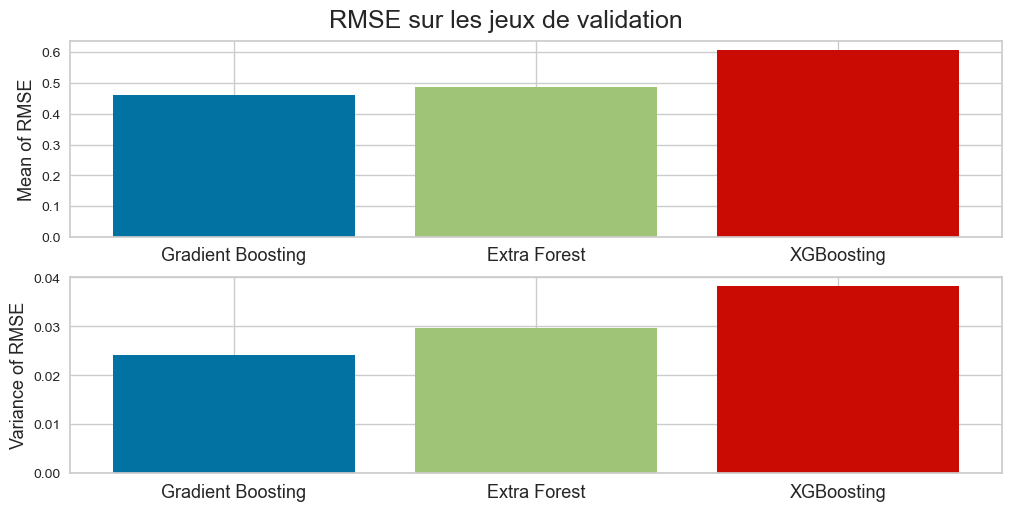

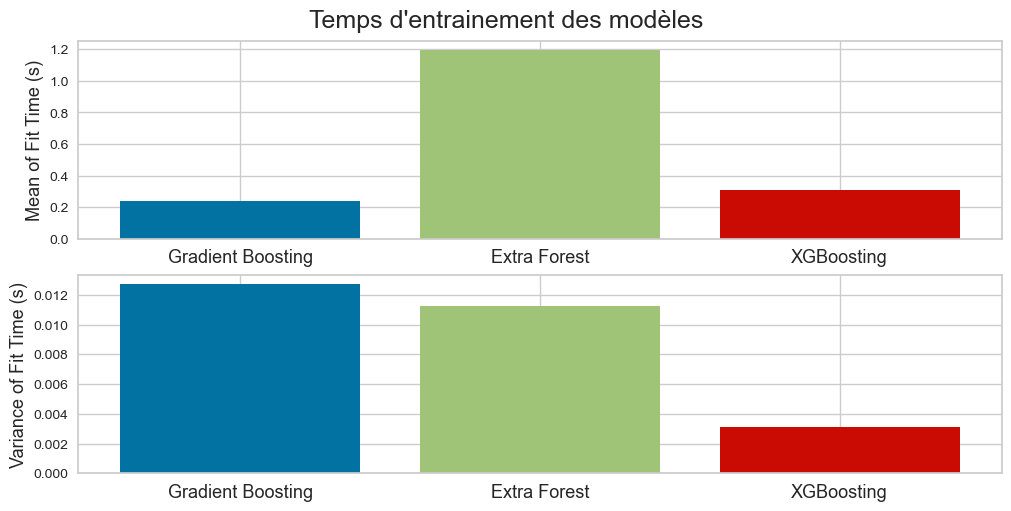

In [92]:
# Selection du meilleur modèle
randomCV_search_results["TotalGHGEmissionsLog"] = fonctions_models.randomCV_search(regressors_vc2, 
                                                     full_pipeline_co2,
                                                     param_grid,
                                                     X_train_log_Co2,
                                                     y_train_log_Co2)

In [93]:
final_model["TotalGHGEmissionsLog"] = randomCV_search_results["TotalGHGEmissionsLog"]["Extra Forest"].best_estimator_

### <span style='background : navajowhite' > 6.6.2   GridSearchCV - Recherche sur grille aléatoire avec validation croisée (variable d'émissions Co2 en log ajouté de la variable ENERGYStarScore) </span>

Gradient Boosting
Paramètres du meilleur modèle (GridSearchCV) : 

	 -  preprocess__cat__imputer__strategy : mean
	 -  preprocess__num__imputer__strategy : mean
	 -  regressor__learning_rate : 0.12
	 -  regressor__max_depth : 1
	 -  regressor__max_features : 8
	 -  regressor__min_samples_leaf : 14
	 -  regressor__min_samples_split : 6
	 -  regressor__n_estimators : 80

Résultats :

	 - r2 score (GridSearchCV) sur le jeu d'entrainement : 0.922
	 - Mean of RMSE(GridSearchCV) : 0.463
	 - Ecart-type(GridSearchCV) : 0.024
	 - Coefficient de variation(GridSearchCV) : 5.20 % 

Extra Forest
Paramètres du meilleur modèle (GridSearchCV) : 

	 -  preprocess__cat__imputer__strategy : mean
	 -  preprocess__num__imputer__strategy : mean
	 -  regressor__max_features : 18
	 -  regressor__min_samples_leaf : 10
	 -  regressor__min_samples_split : 30
	 -  regressor__n_estimators : 590

Résultats :

	 - r2 score (GridSearchCV) sur le jeu d'entrainement : 0.952
	 - Mean of RMSE(GridSearchCV) : 0.484
	 - Ec

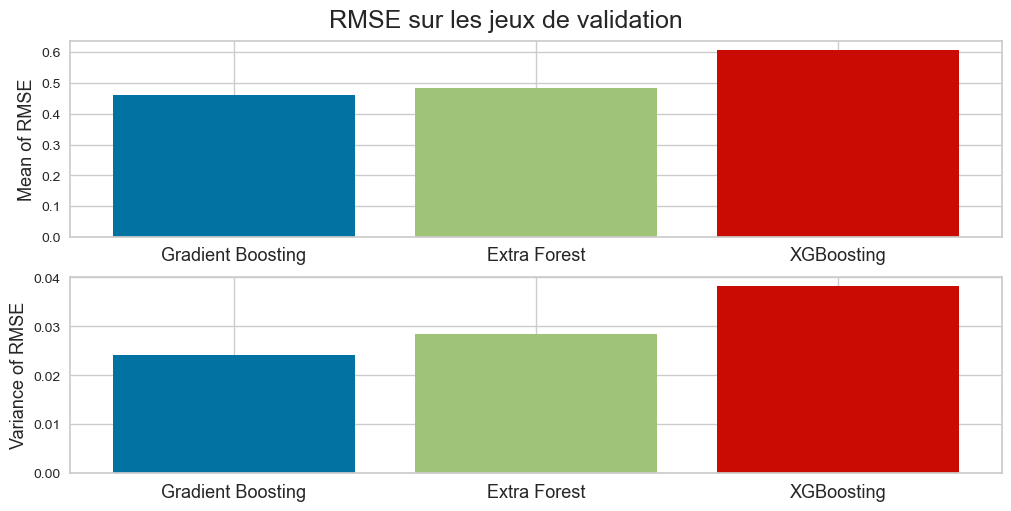

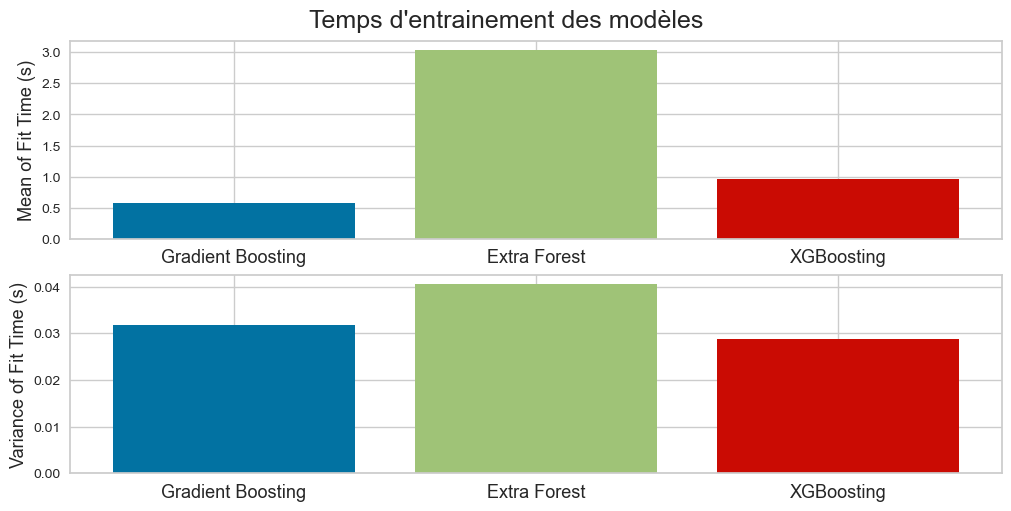

In [94]:
# Selection du meilleur modèle
gridCV_search_results["TotalGHGEmissionsLog"] = fonctions_models.gridCV_search(regressors_vc2, 
                                                     full_pipeline_co2,
                                                     param_grid_grd_CV,
                                                     X_train_log_Co2,
                                                     y_train_log_Co2)

In [96]:
final_model["TotalGHGEmissionsLog"] = gridCV_search_results["TotalGHGEmissionsLog"]["Gradient Boosting"].best_estimator_

## <span style='background :lightblue' > 6.7 Modèle GradientBoostingRegressor Optimisé(variable 'TotalGHGEmissionsLog') avec la variable 'ENERGYScore'  </span>

In [99]:
# Modèle GradientBoosting optimisé
# Instanciation du modèle optimisé (Randomized Search CV)


gb_optimise_rnd__v2md = GradientBoostingRegressor(n_estimators=80,  min_samples_split = 7, min_samples_leaf = 14, \
                                          max_features = 8, max_depth = 1, learning_rate = 0.12)

        
# Entraînement du modèle
gb_optimise_rnd__v2md.fit(X_train_log_Co2, y_train_log_Co2)

GradientBoostingRegressor(learning_rate=0.12, max_depth=1, max_features=8,
                          min_samples_leaf=14, min_samples_split=7,
                          n_estimators=80)

In [100]:
# Modèle GradientBoosting optimisé
# Instanciation du modèle optimisé (Grid Search CV)


gb_optimise_grd__v2md = GradientBoostingRegressor(n_estimators= 80, min_samples_split = 6, min_samples_leaf = 14, \
                                          max_features = 8, max_depth = 1, learning_rate = 0.12)

        
# Entraînement du modèle
gb_optimise_grd__v2md.fit(X_train_log_Co2, y_train_log_Co2)

GradientBoostingRegressor(learning_rate=0.12, max_depth=1, max_features=8,
                          min_samples_leaf=14, min_samples_split=6,
                          n_estimators=80)

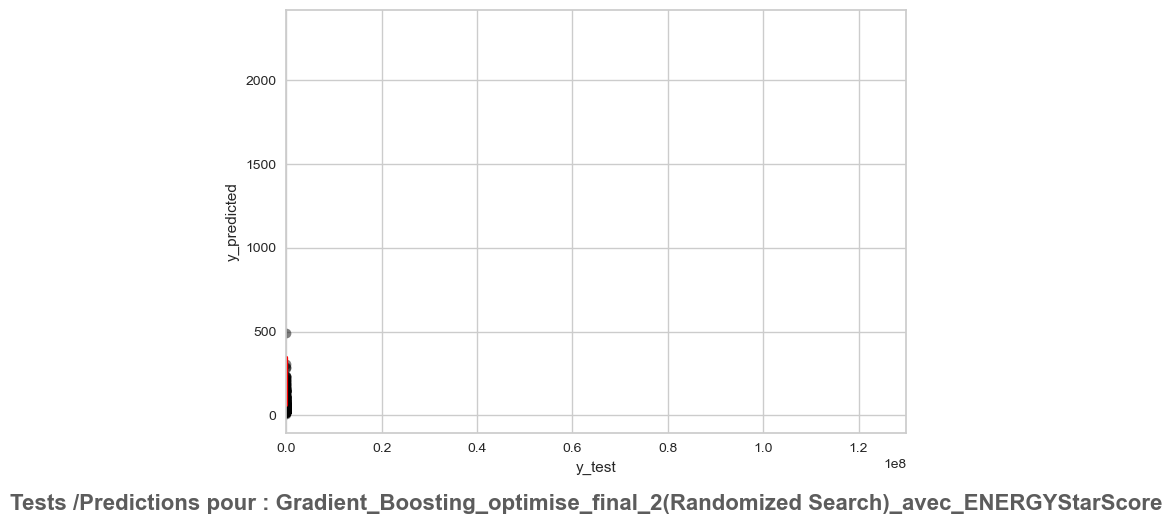

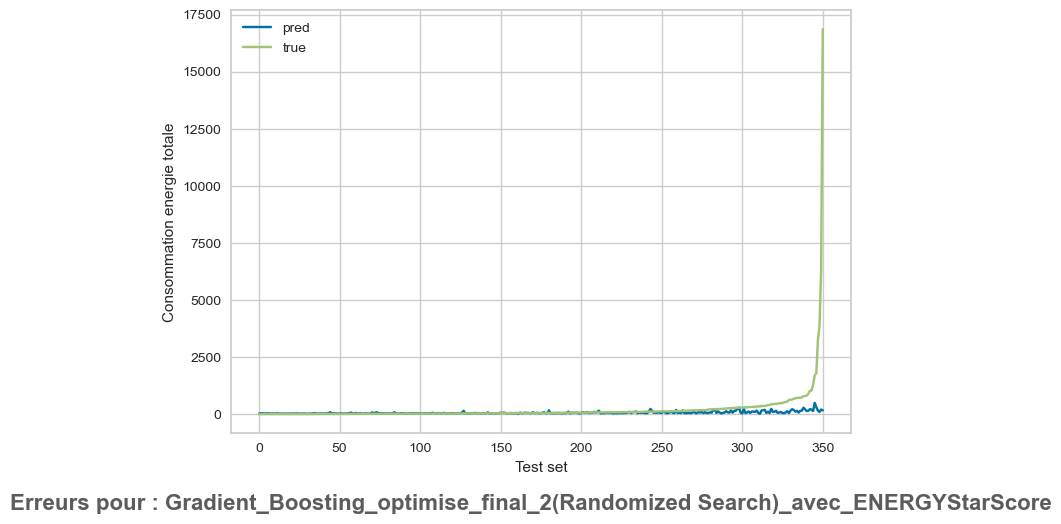

In [101]:
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné avec l'ajout de la variable ENERGYStarScore
# avec la variable cible transformée (Randomized Search)

df_best_models, y_pred_gb_optimise_rnd_md = fonctions_models.process_regression(gb_optimise_rnd__v2md,
                                                                        X_train_log_Co2, X_test_log_Co2,
                                                                         y_train_log_Co2, y_test_log_Co2,
                                                                        df_best_models,
                                                                        'Gradient_Boosting_optimise_final_2(Randomized Search)_avec_ENERGYStarScore')

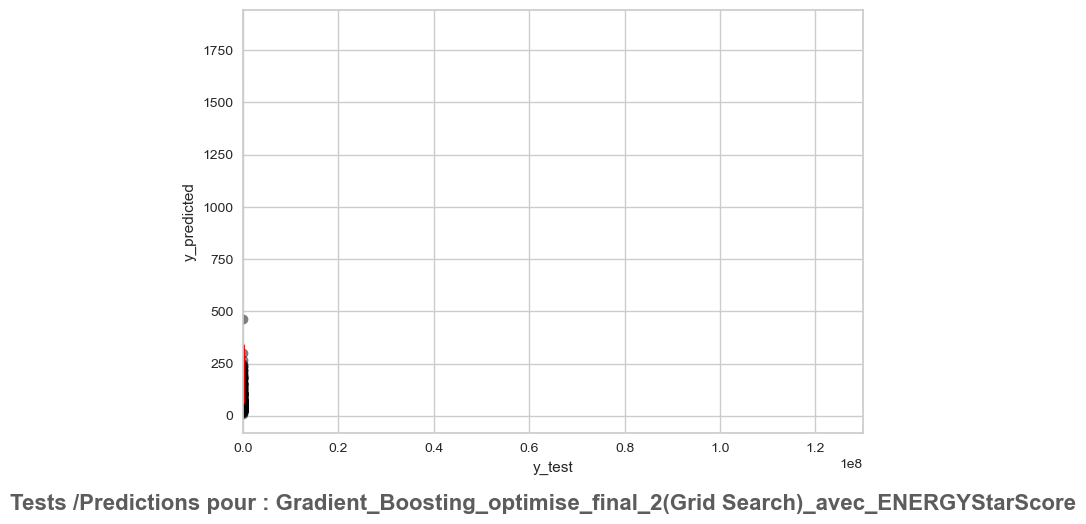

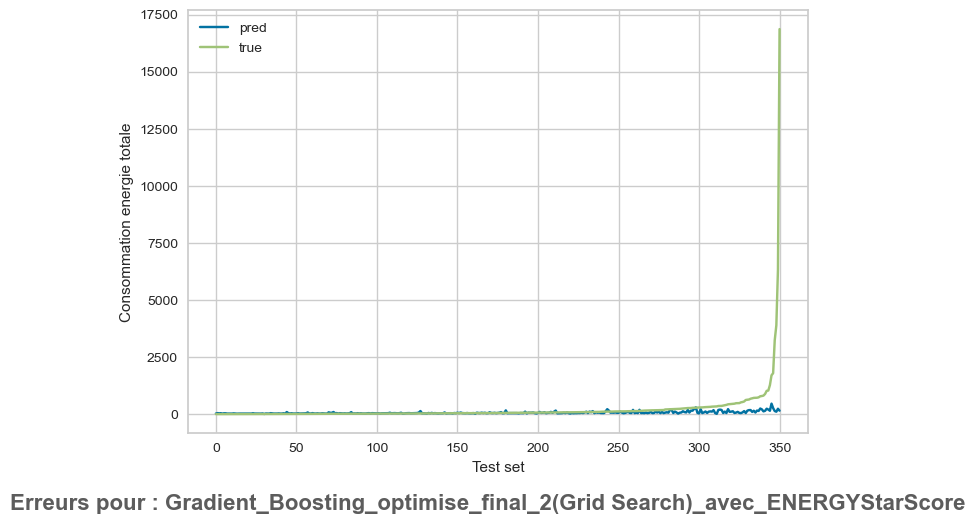

In [102]:
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné avec l'ajout de la variable ENERGYStarScore
# avec la variable cible transformée (Grid Search)

df_best_models, y_pred_ef_optimise_grd_md = fonctions_models.process_regression(gb_optimise_grd__v2md,
                                                                        X_train_log_Co2, X_test_log_Co2,
                                                                         y_train_log_Co2, y_test_log_Co2,
                                                                        df_best_models,
                                                                        'Gradient_Boosting_optimise_final_2(Grid Search)_avec_ENERGYStarScore')

## <span style='background :lightblue' > 6.8 Importance des variables  </span>

**Variables d'importances sur les variables cibles (avec la variable ENERGYStarScore)**

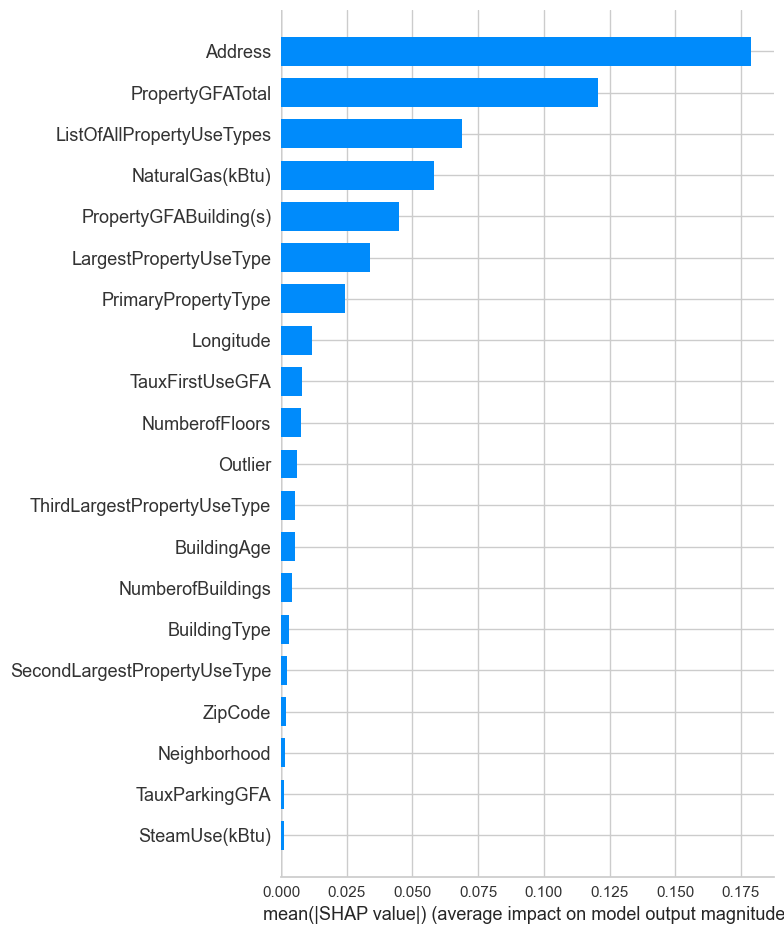

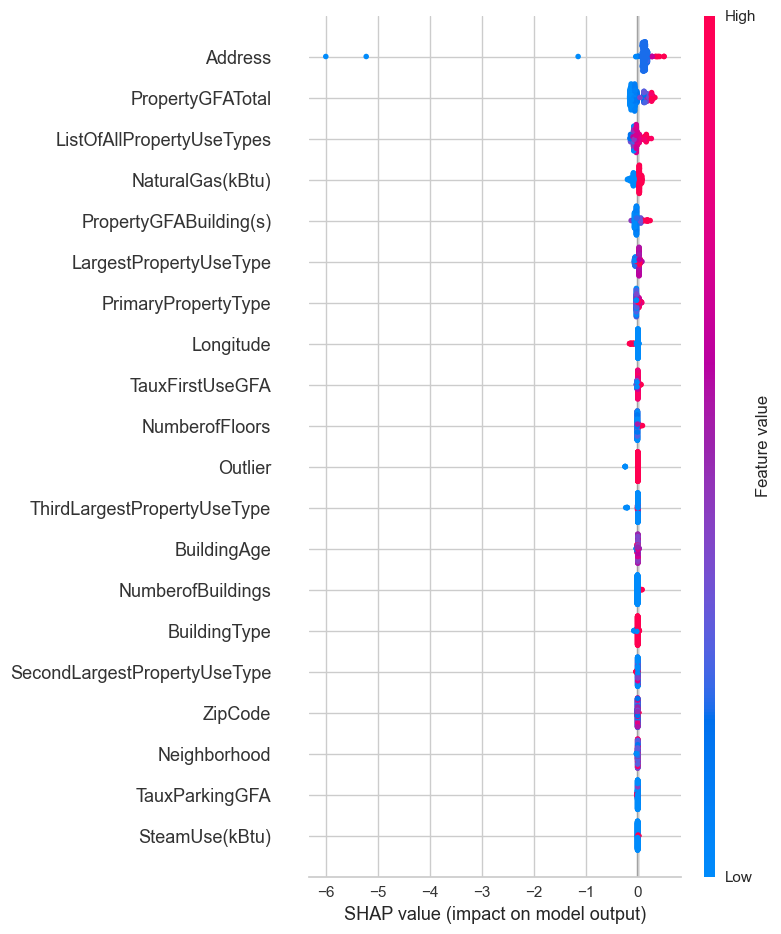

In [128]:
fonctions_models.plot_shape_values(gb_optimise_rnd_v1, X_test_log)

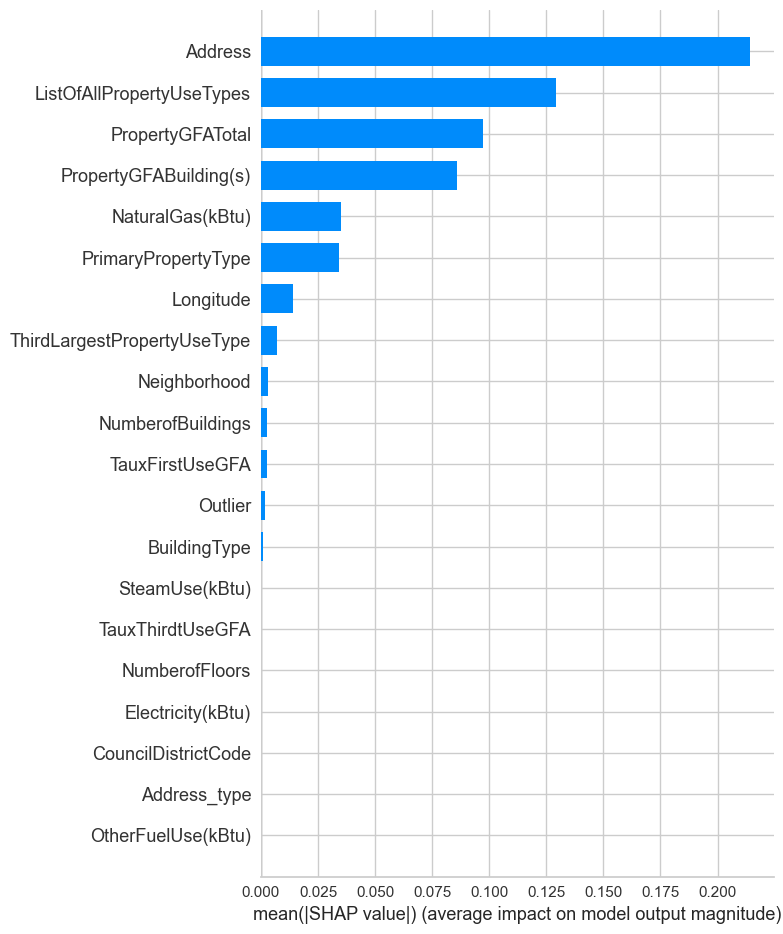

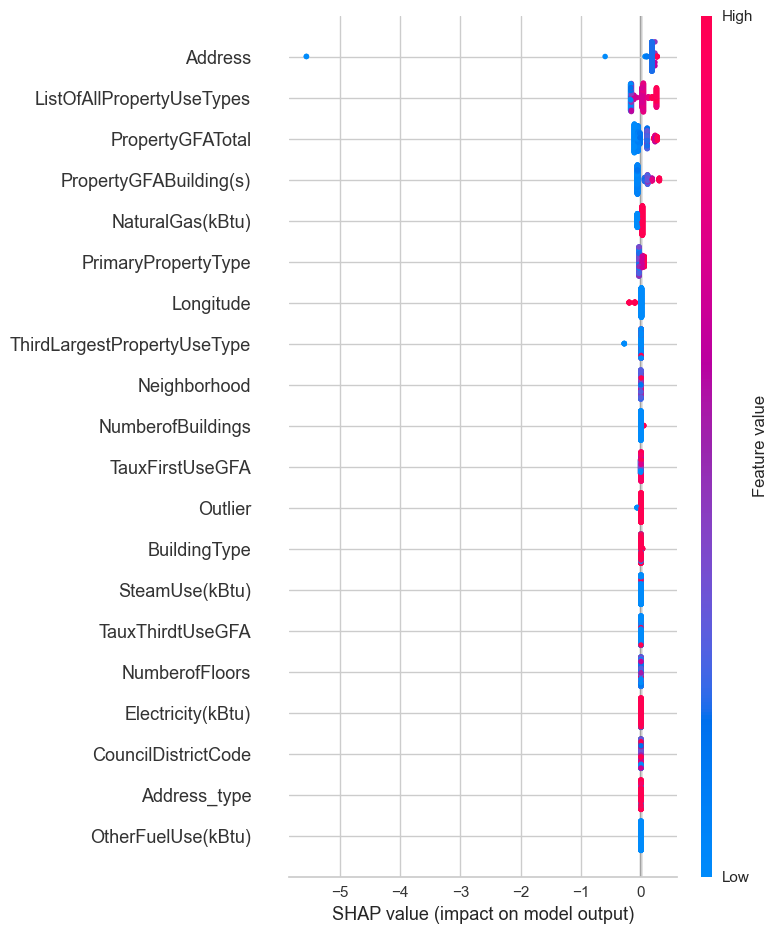

In [140]:
fonctions_models.plot_shape_values(gb_optimise_grd_v1, X_test_log)

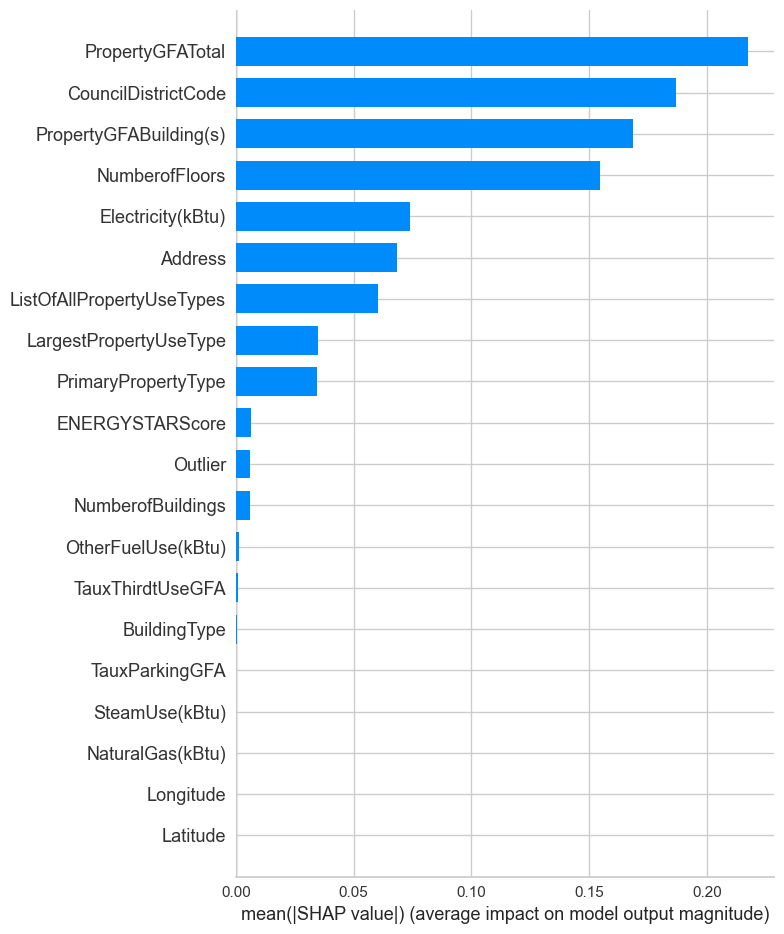

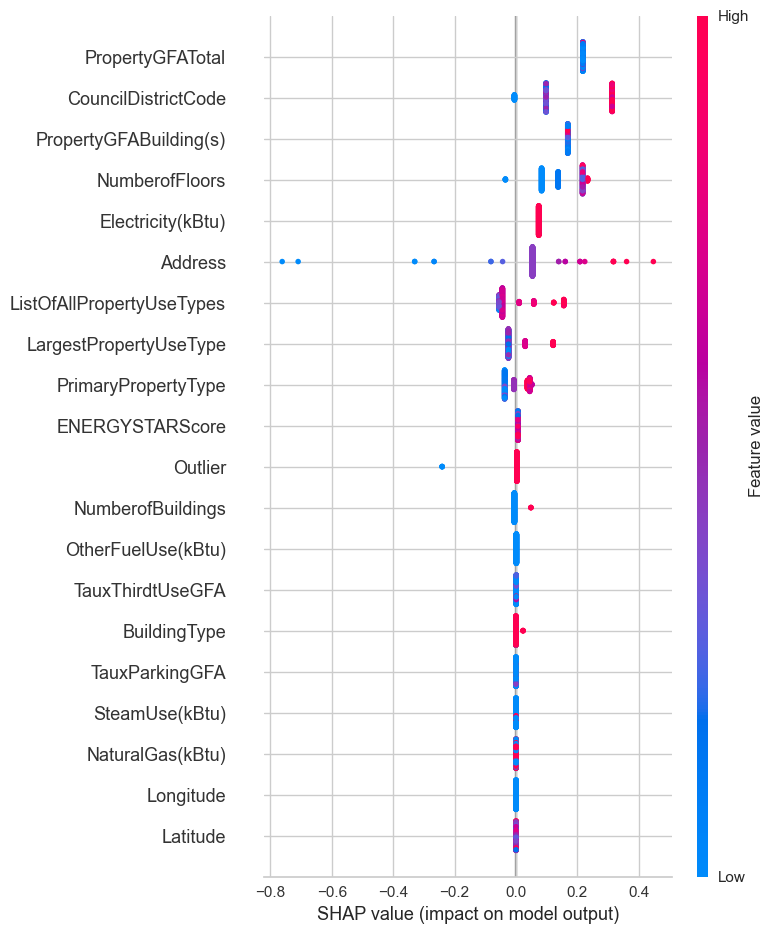

In [105]:
fonctions_models.plot_shape_values(gb_optimise_rnd_v2, X_test_log_Co2)

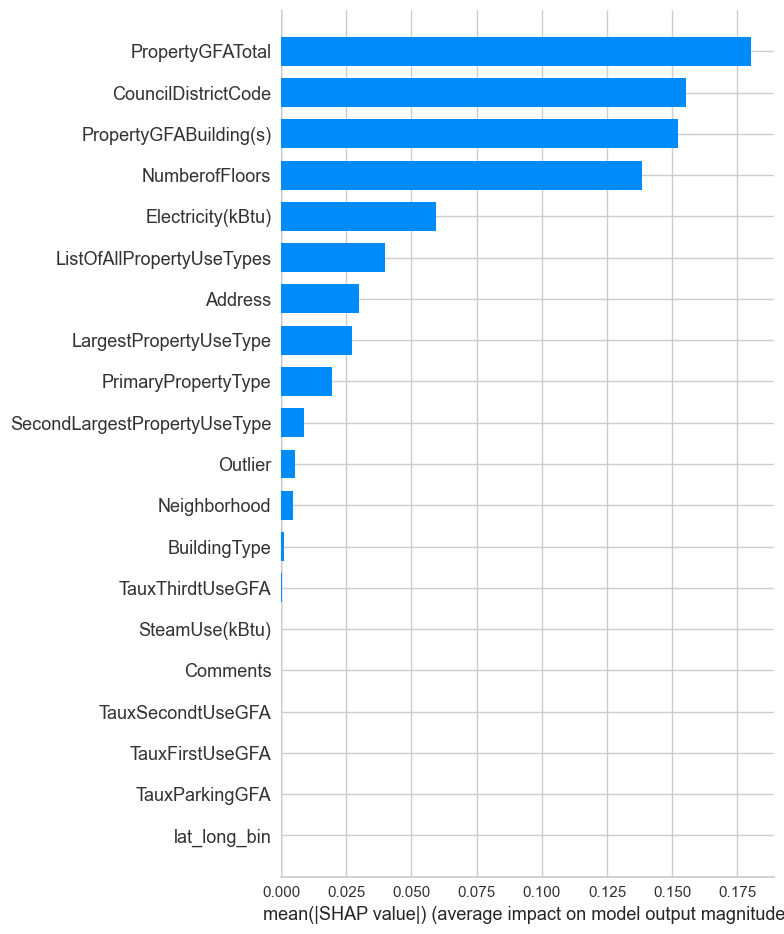

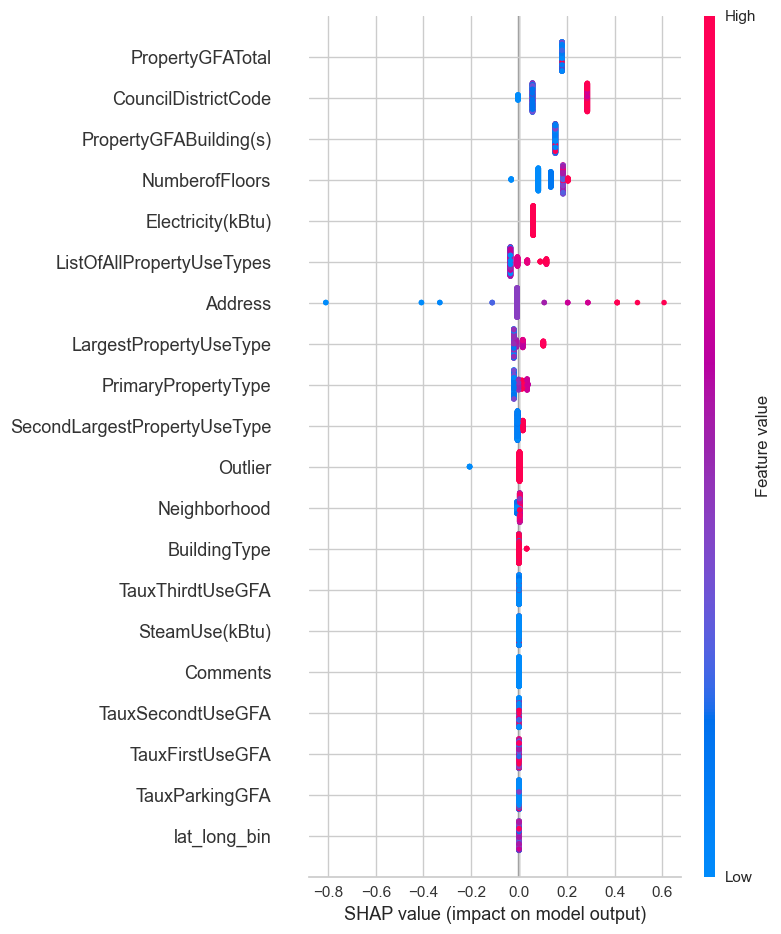

In [107]:
fonctions_models.plot_shape_values(gb_optimise_grd_v2, X_test_log_Co2)

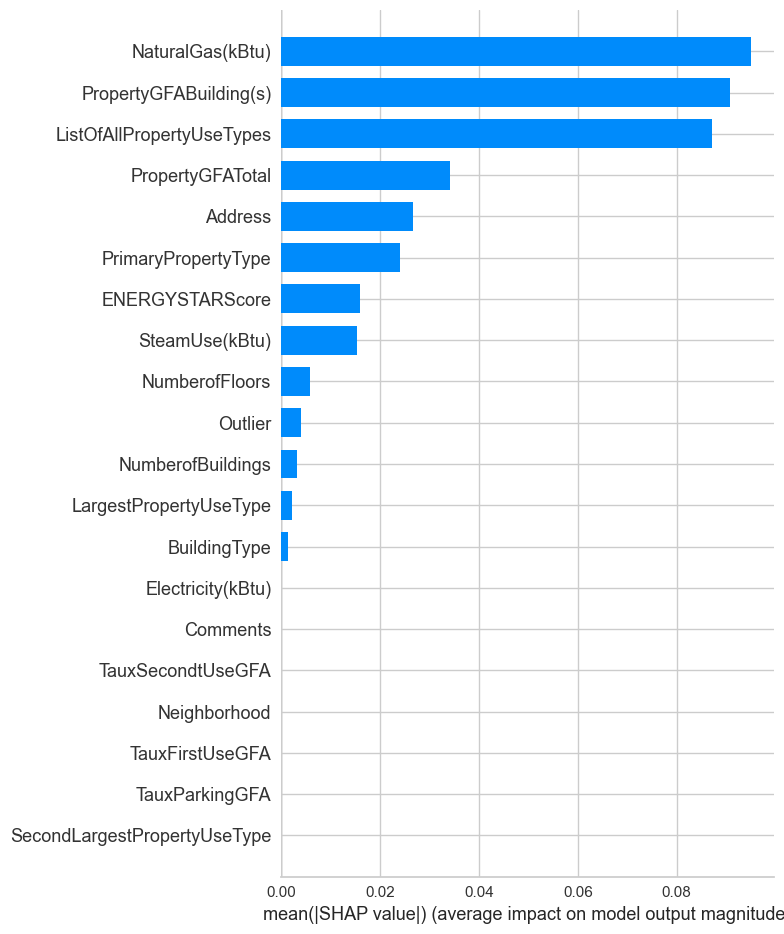

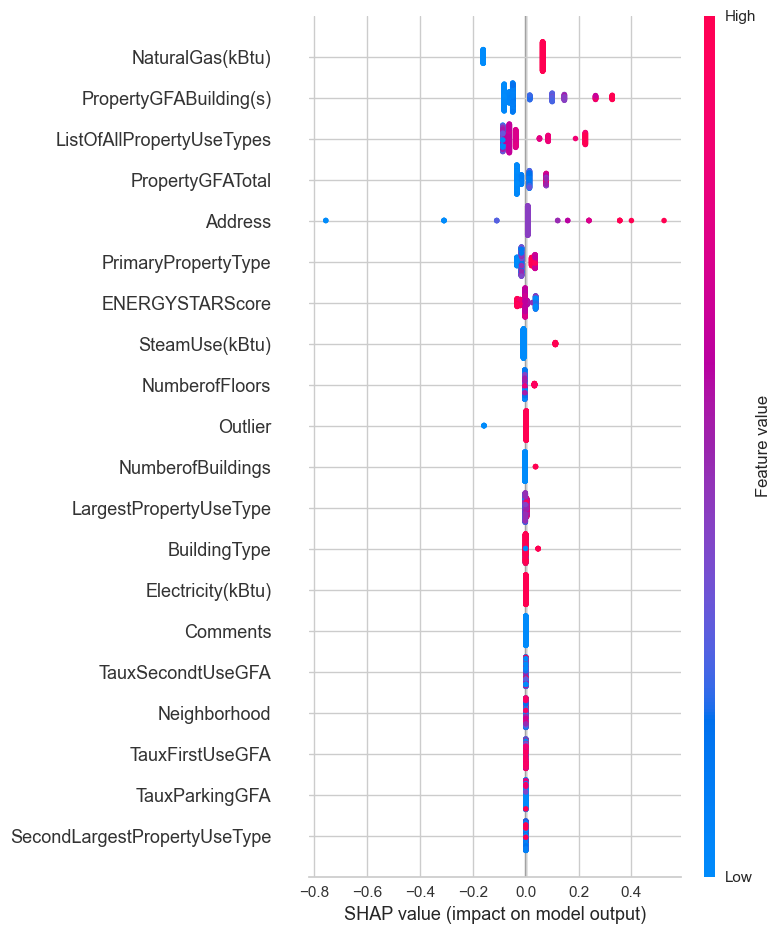

In [108]:
fonctions_models.plot_shape_values(gb_optimise_rnd__v2md, X_test_log_Co2)

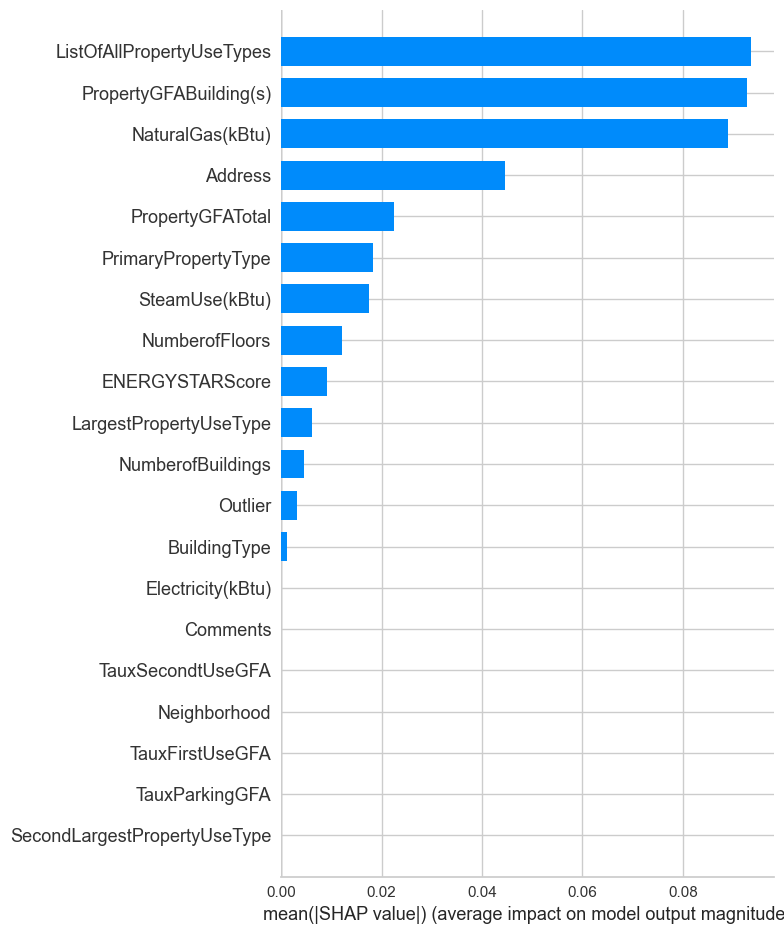

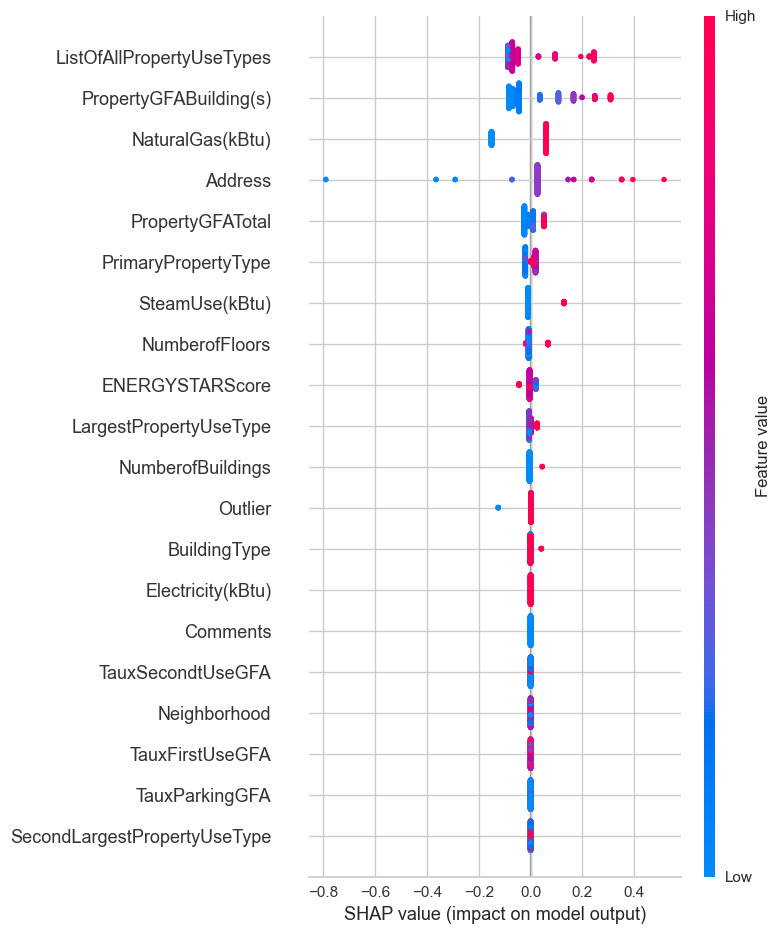

In [109]:
fonctions_models.plot_shape_values(gb_optimise_grd__v2md, X_test_log_Co2)  

## <span style='background :lightblue' > 6.9 Learning Curve des algorithmes optimisés  </span>

**Learning Curve sur les variables cibles (Grid Search, Randomized Search)**

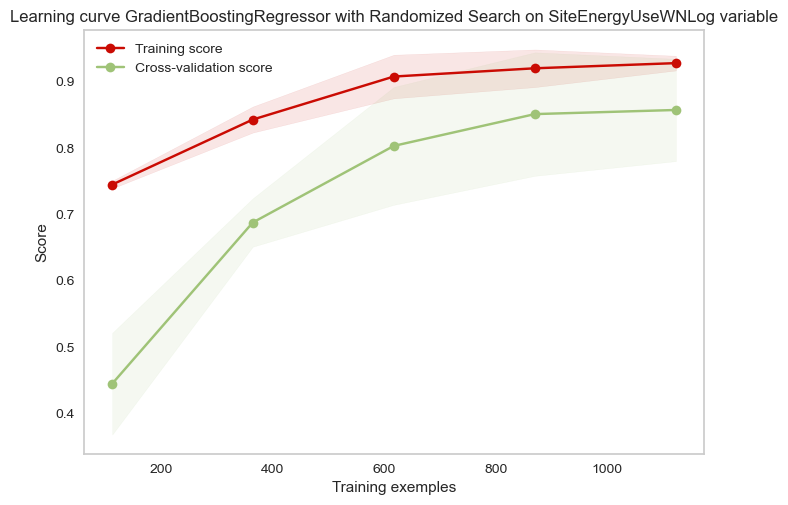

In [110]:
fonctions_models.plot_learning_curve(gb_optimise_rnd_v1, 'Learning curve GradientBoostingRegressor with Randomized Search on SiteEnergyUseWNLog variable',
                                 X_train_log, y_train_log)

- **Bilan :**

>Courbe d'entraînement croissante : pas en under-fitting.
> Réduction d'écart entre la courbe d'entraînement et de test.

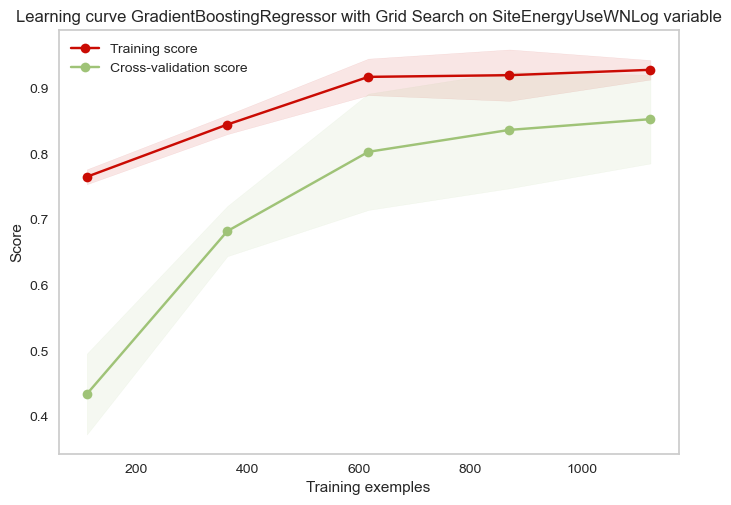

In [111]:
fonctions_models.plot_learning_curve(gb_optimise_grd_v1, 'Learning curve GradientBoostingRegressor with Grid Search on SiteEnergyUseWNLog variable',
                                 X_train_log, y_train_log)

- **Bilan :**

> Courbe d'entraînement croissante : pas en under-fitting.
> Réduction d'écart entre la courbe d'entraînement et de test.

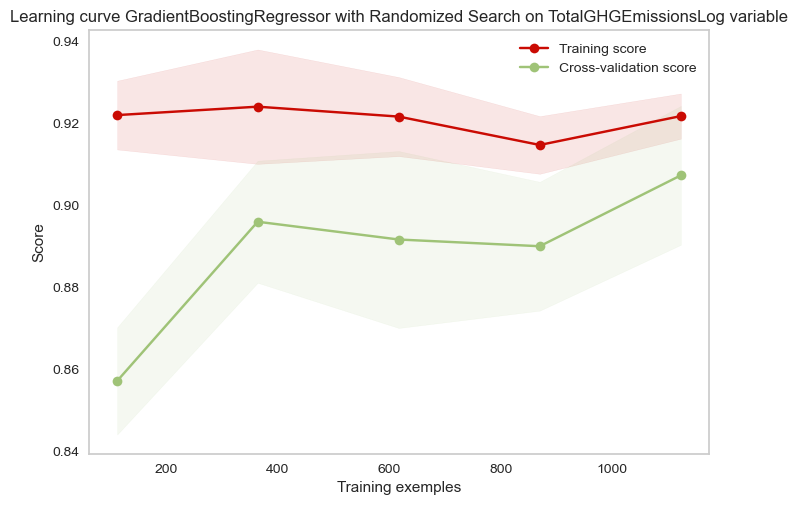

In [112]:
fonctions_models.plot_learning_curve(gb_optimise_rnd_v2, 'Learning curve GradientBoostingRegressor with Randomized Search on TotalGHGEmissionsLog variable',
                                 X_train_log_Co2, y_train_log_Co2)

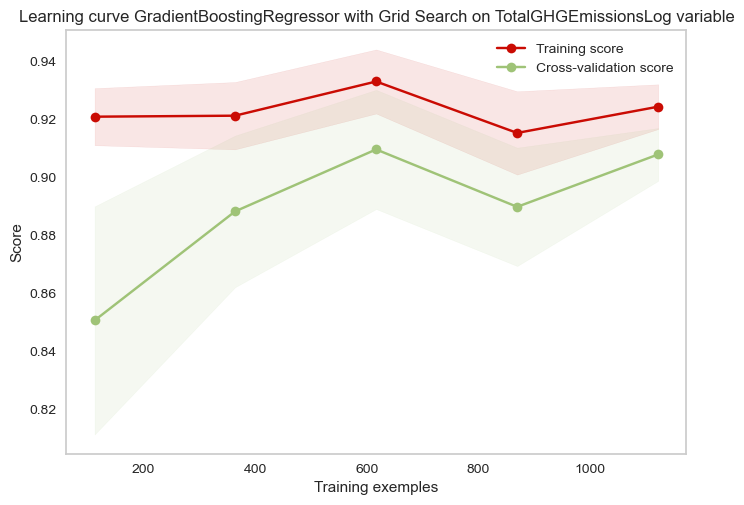

In [113]:
fonctions_models.plot_learning_curve(gb_optimise_grd_v2, 'Learning curve GradientBoostingRegressor with Grid Search on TotalGHGEmissionsLog variable',
                                 X_train_log_Co2, y_train_log_Co2)

**Learning Curve des algorithmes optimisés, avec la variable 'ENERGYScore'**

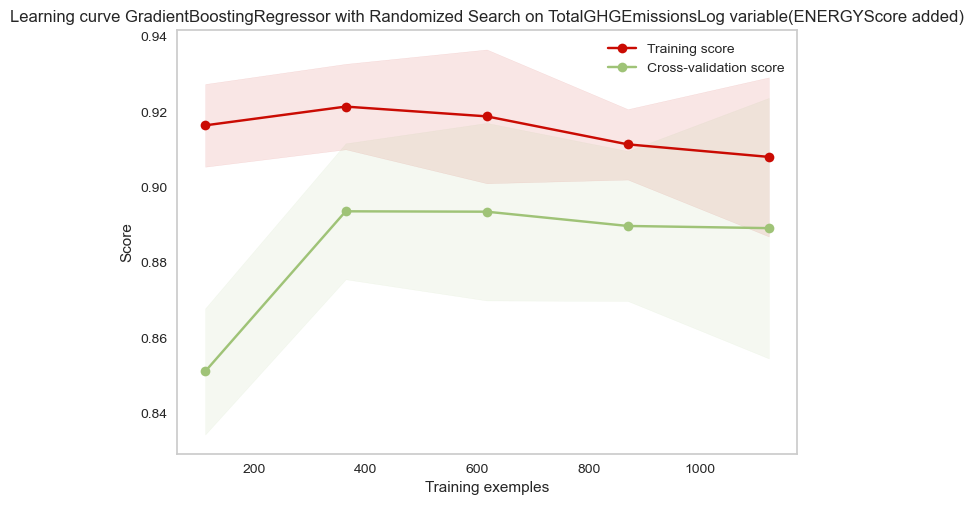

In [114]:
fonctions_models.plot_learning_curve(gb_optimise_rnd__v2md, 'Learning curve GradientBoostingRegressor with Randomized Search on TotalGHGEmissionsLog variable(ENERGYScore added)',
                                 X_train_log_Co2, y_train_log_Co2)

- **Bilan :**

>Courbe d'entraînement décroissante : pas en under-fitting.
>Plus de données doivent être fournies au modèle.

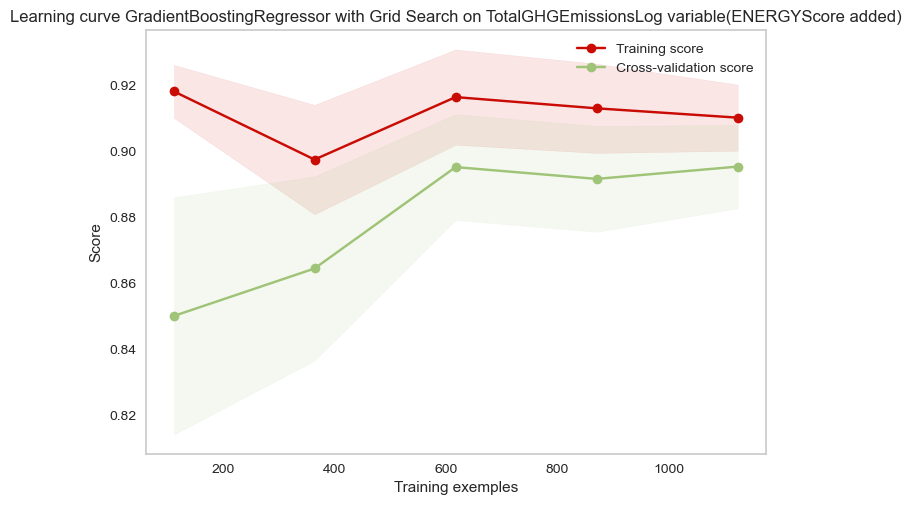

In [115]:
fonctions_models.plot_learning_curve(gb_optimise_grd__v2md, 'Learning curve GradientBoostingRegressor with Grid Search on TotalGHGEmissionsLog variable(ENERGYScore added)',
                                 X_train_log_Co2, y_train_log_Co2)

- **Bilan :**

> Courbe d'entraînement en croissante, puis stagnante : pas en under-fitting.
> Réduction d'écart entre la courbe d'entraînement et de test.

# <span style='background :lightgreen' > 7. Résultats sur le jeu test  </span>

## <span style='background :lightblue' > 7.1 Prédicitons sur les données  </span>

In [116]:
# Split en jeu d'entrainement et de test
train_set, test_set = train_test_split(data_prepro, train_size=0.8, random_state=0)

In [117]:
# Fonction pour la transformation inverse sur nos variables à prédire
f = lambda x : np.exp(x) - 1
y_test_true = test_set.copy().reset_index()

In [118]:
y_test_pred = pd.DataFrame()

# Resultats sur le jeu Test
print("Resultats sur le jeu Test :", "\n")
for label in ["SiteEnergyUseWNLog","TotalGHGEmissionsLog"] :
    print("_______", label, "_______")

    y_test_pred[label] = final_model[label].predict(test_set)

    y_true, y_pred = y_test_true[label].apply(f), y_test_pred[label].apply(f)
    
    r2 = final_model[label].score(test_set, test_set[label]) # r2_score
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # root mean squared error
    mape = fonctions_models.mean_absolute_percentage_error(y_true, y_pred) # mean absolute percentage error
    mean_abs_error = mean_absolute_error(y_true, y_pred) # mean absolute error

    
    print("r2 score :", r2)
    print("rmse :", rmse)
    print("mape : {:.2f} %".format(mape))
    print("mean absolute error :", mean_abs_error, "\n")

Resultats sur le jeu Test : 

_______ SiteEnergyUseWNLog _______
r2 score : 0.7775827046645345
rmse : 345.00896913326807
mape : inf %
mean absolute error : 130.93195214421326 

_______ TotalGHGEmissionsLog _______
r2 score : 0.8158792839556781
rmse : 4.222696810504986
mape : inf %
mean absolute error : 1.4324248859110535 



## <span style='background :lightblue' > 7.2 Exemples de prédictions de quelques bâtiments  </span>

### <span style='background : navajowhite' > 7.2.1 Visualisation des erreurs </span>

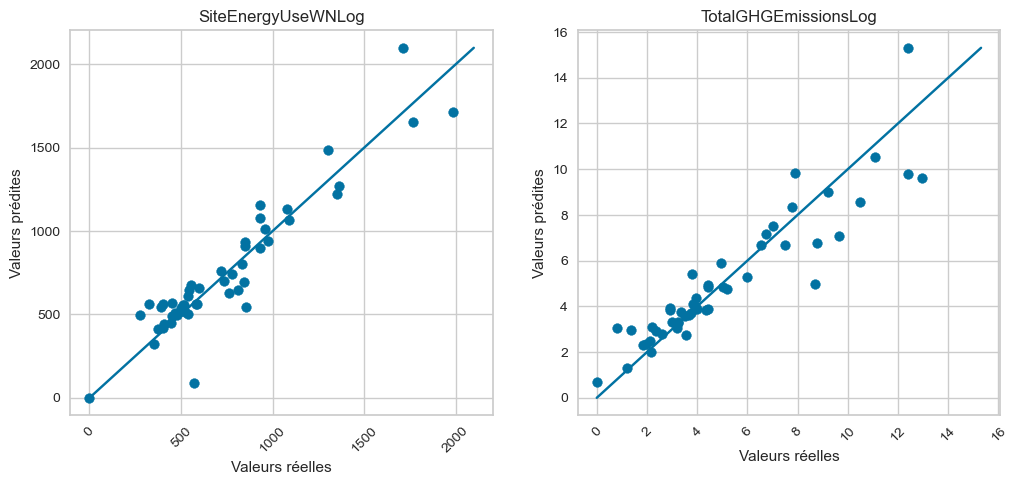

In [124]:
# 10 batiments séléctionnés aléatoirement
nbr_batiments=50
index_bat = np.random.permutation(y_test_true.index)[0:nbr_batiments]

# Séléction des 10 bâtiments
bat_table = y_test_true.loc[index_bat]

fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUseWNLog","TotalGHGEmissionsLog"]) :
    # valeurs test réelles et valeurs test prédites
    y_true, y_pred = y_test_true.loc[index_bat, label].apply(f), y_test_pred.loc[index_bat, label].apply(f)
    
    bat_table[label]  = y_true
    # Calcul de l'écart relatif entre valeurs réelles et valeurs prédites
    bat_table[label + " %"] = 100*abs(y_true - y_pred)/y_true
    
    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.scatter(y_true, y_pred)
    
    x_max = max(y_true.max(), y_pred.max())
    x_min = min(y_true.min(), y_pred.min())
    
    plt.xticks(rotation=45)

    plt.plot([x_min, x_max] ,[x_min, x_max])
plt.show()

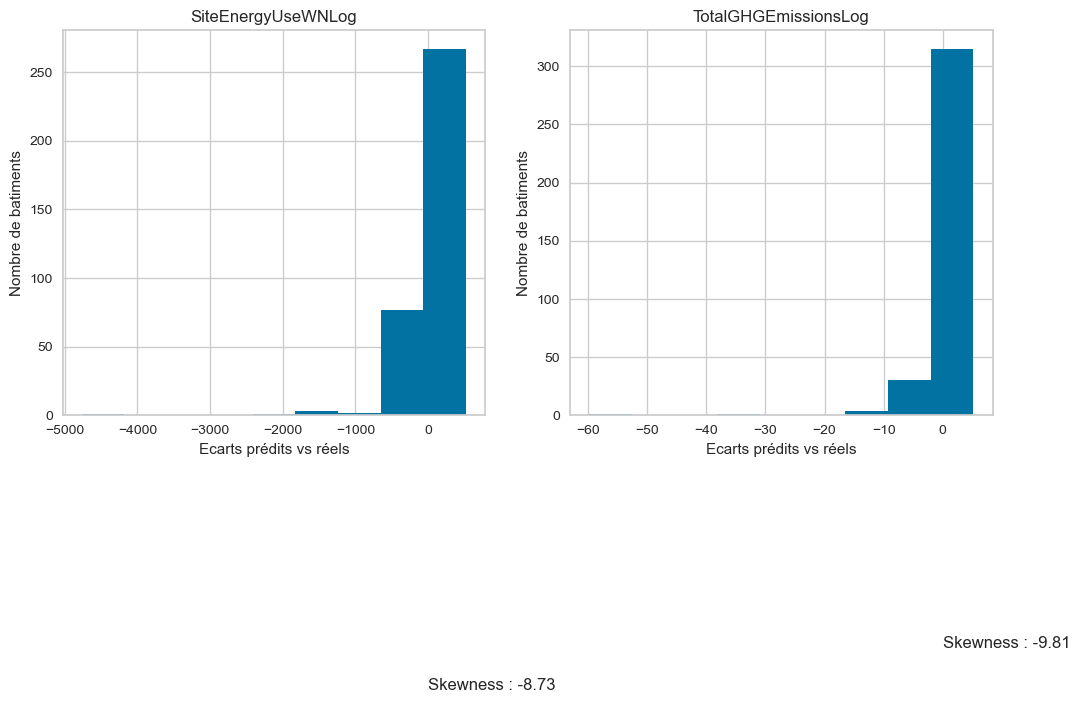

In [120]:
# Histogramme de l'écart entre valeurs prédites et valeurs réelles
# Graphique 1 : SiteEnergyUse(kBtu)
# Graphique 2 : TotalGHGEmissions
fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUseWNLog","TotalGHGEmissionsLog"]) :
    ax = plt.subplot(1,2,i+1)
    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Ecarts prédits vs réels")
    plt.ylabel("Nombre de batiments")
    y = y_test_pred[label].apply(f) - y_test_true[label].apply(f)
    plt.hist(y, bins=int(1 + np.log2(len(test_set))))
    plt.text(0, -200, 'Skewness : ' + str(round(y.skew(),2)))
plt.show()

## <span style='background :lightblue' > 7.3 Visualisation des erreurs </span>

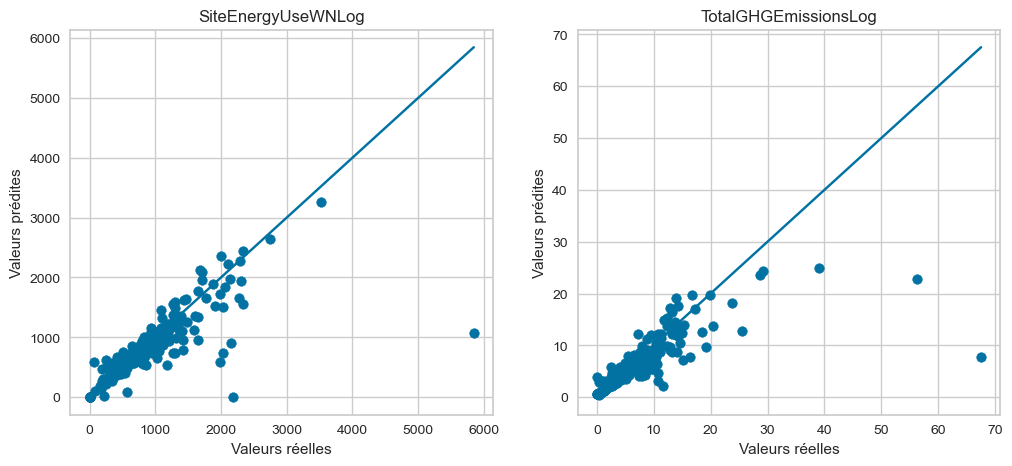

In [121]:
# x : valeurs réelles, y : valeurs prédites
# Graphique 1 : SiteEnergyUse(kBtu)
# Graphique 2 : TotalGHGEmissions
fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUseWNLog","TotalGHGEmissionsLog"]) :
    
    # valeurs test réelles et valeurs test prédites
    y_true, y_pred = y_test_true[label].apply(f), y_test_pred[label].apply(f)

    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.scatter(y_true, y_pred)
    
    # x-min et x-max limites
    x_max = max(y_true.max(), y_pred.max())
    x_min = min(y_true.min(), y_pred.min())
    plt.plot([x_min, x_max] ,[x_min, x_max])
    
plt.show()

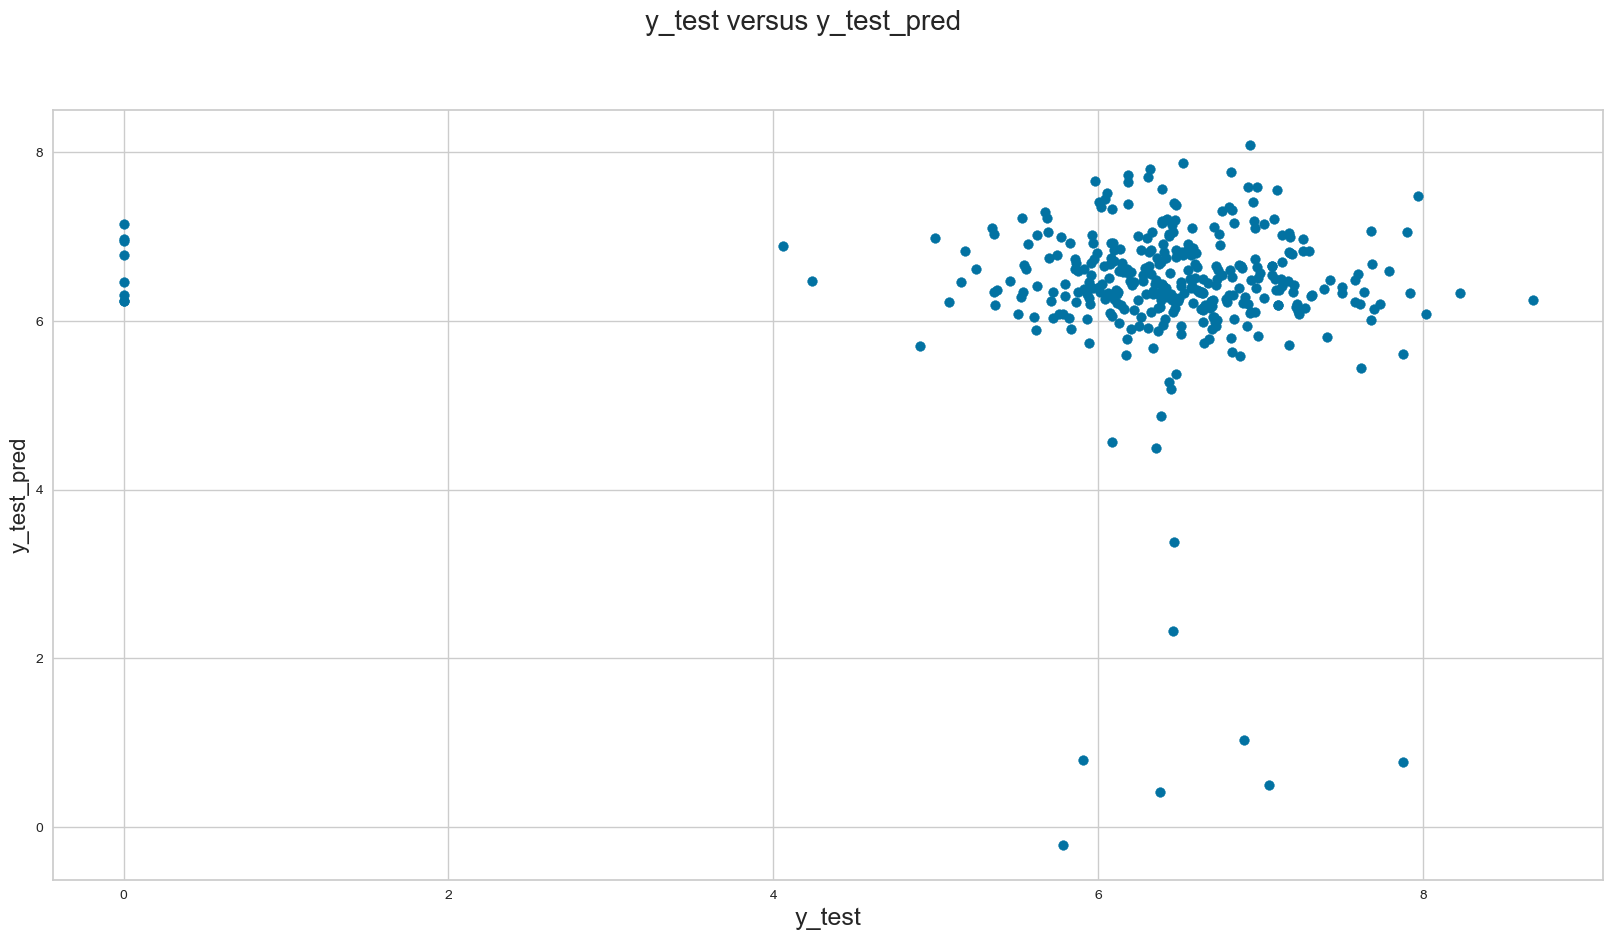

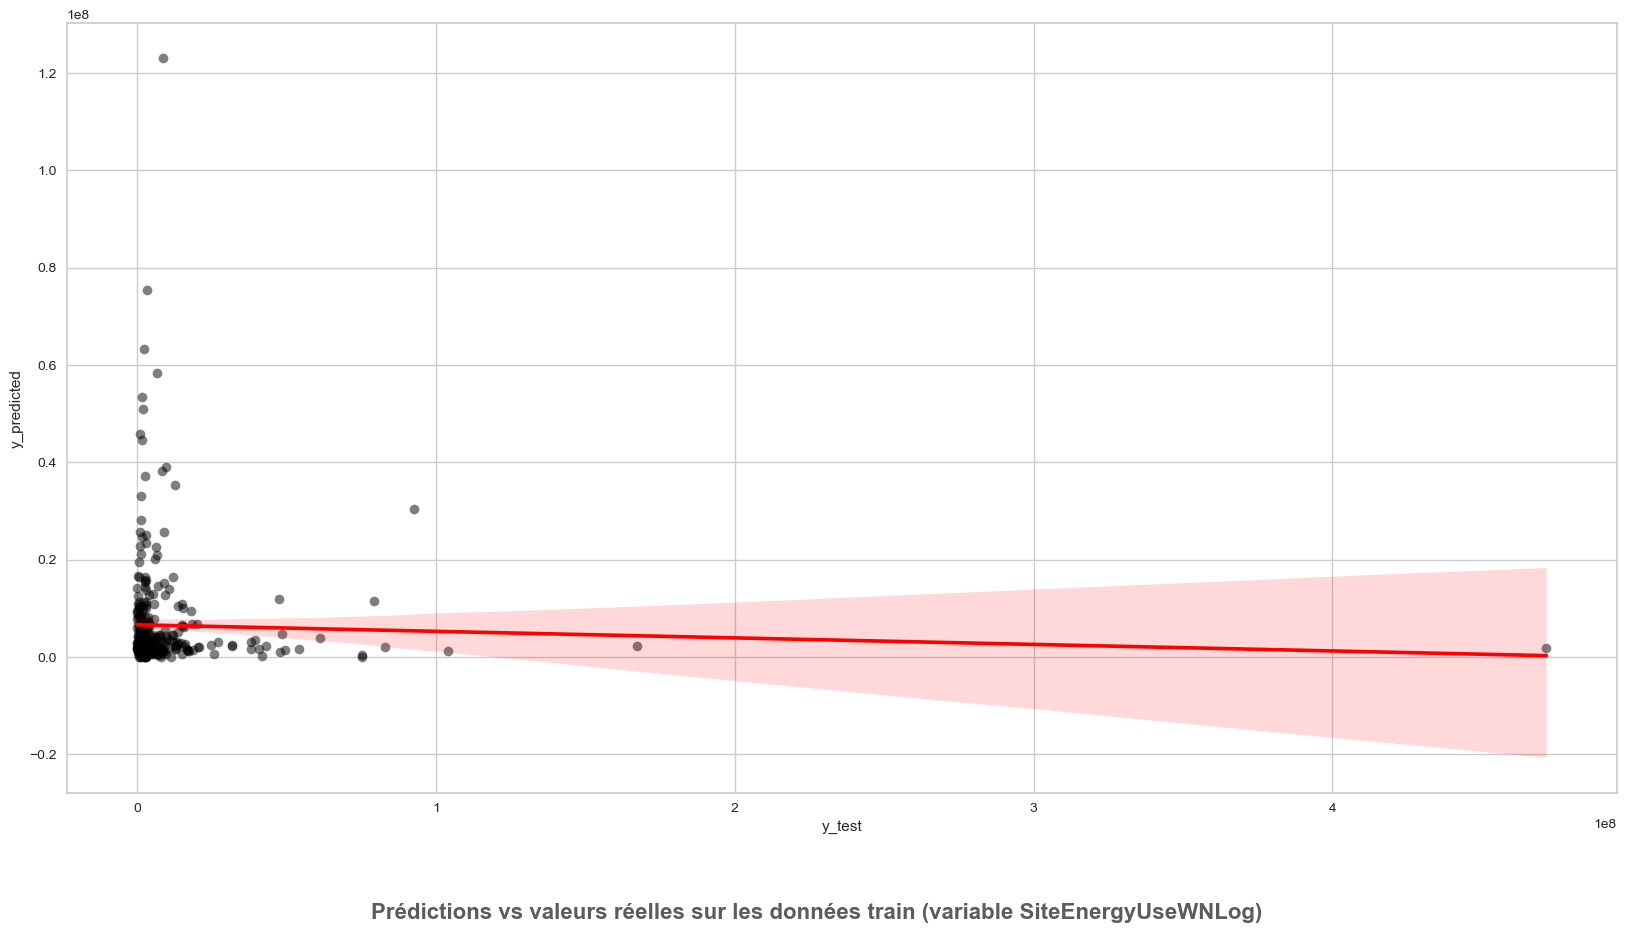

In [122]:
# Visualisation des prédictions / valeurs réélles du jeu d'entraînement

y_test_pred_s = y_test_pred['SiteEnergyUseWNLog'].squeeze() 
# Visualisation des prédictions / valeurs réélles du jeu de test en log
fig = plt.figure(figsize=(20, 10))
plt.scatter(y_test_log, y_test_pred_s)
fig.suptitle('y_test versus y_test_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_test_pred', fontsize=16)


test = (10 ** y_test_log) + 1
#test = y_test_log
predict = (10 **y_test_pred_s) + 1
#predict = y_test_pred_s


# Visualisation des prédictions / valeurs réélles du jeu de test non transformé en log
fig = plt.figure(figsize=(20, 10))

sns.regplot(x = test , y = predict,
                scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})
        
plt.xlabel('y_test')
plt.ylabel('y_predicted')
plt.suptitle(t='Prédictions vs valeurs réelles sur les données train (variable ''SiteEnergyUseWNLog'')',
               y=0,
               fontsize=16,
               alpha=0.75,
               weight='bold',
               ha='center')
plt.show()

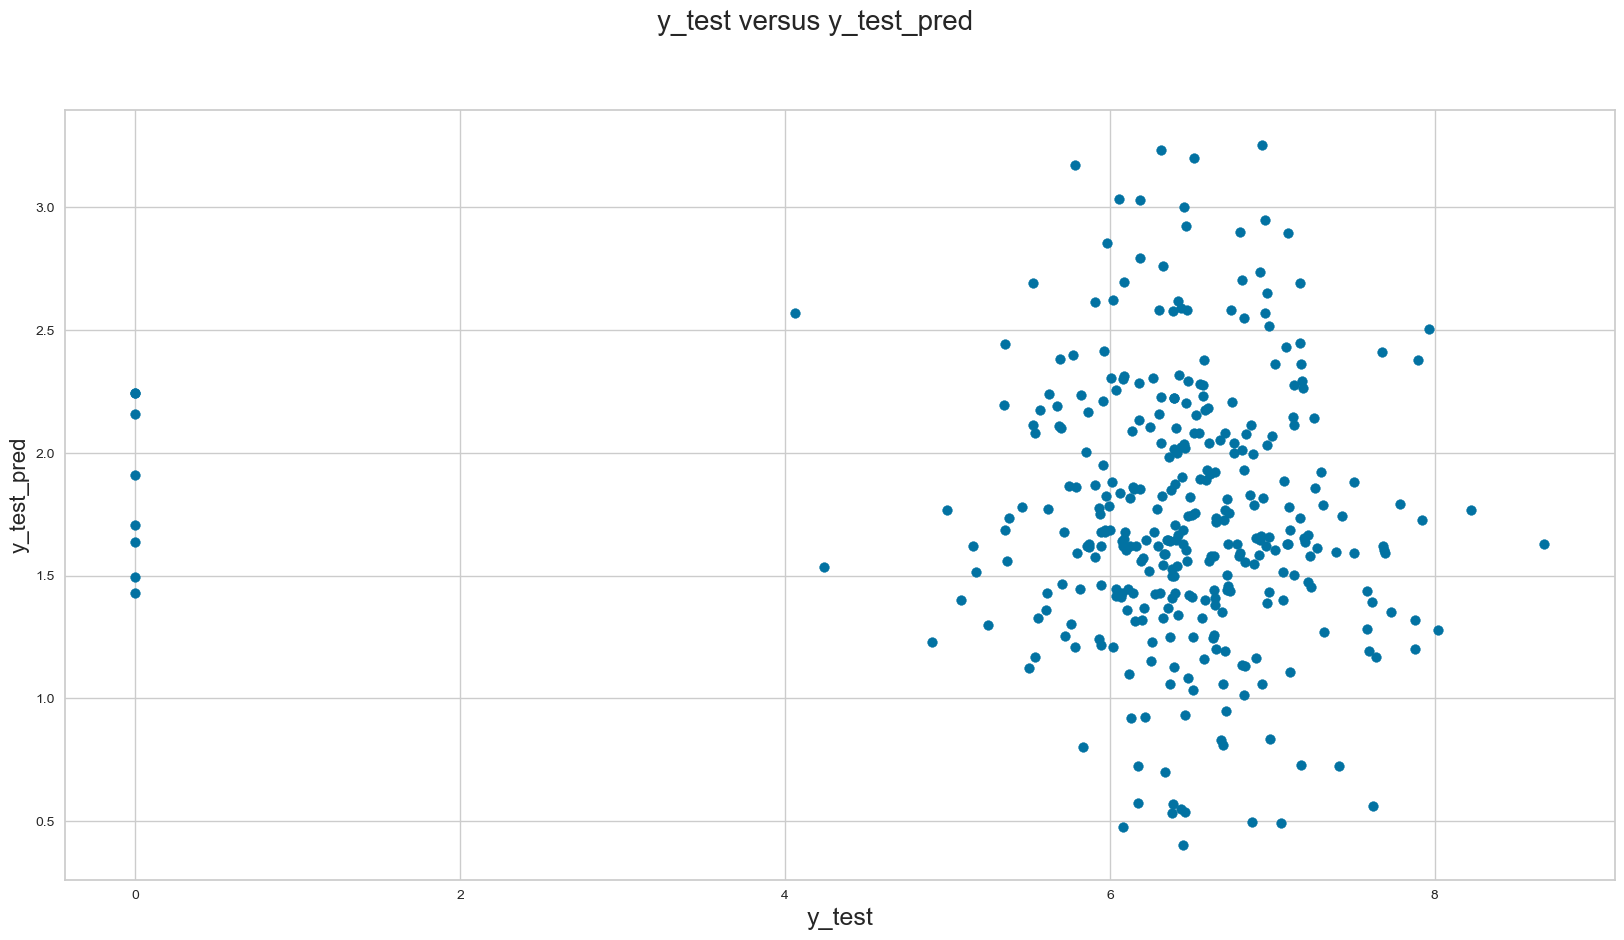

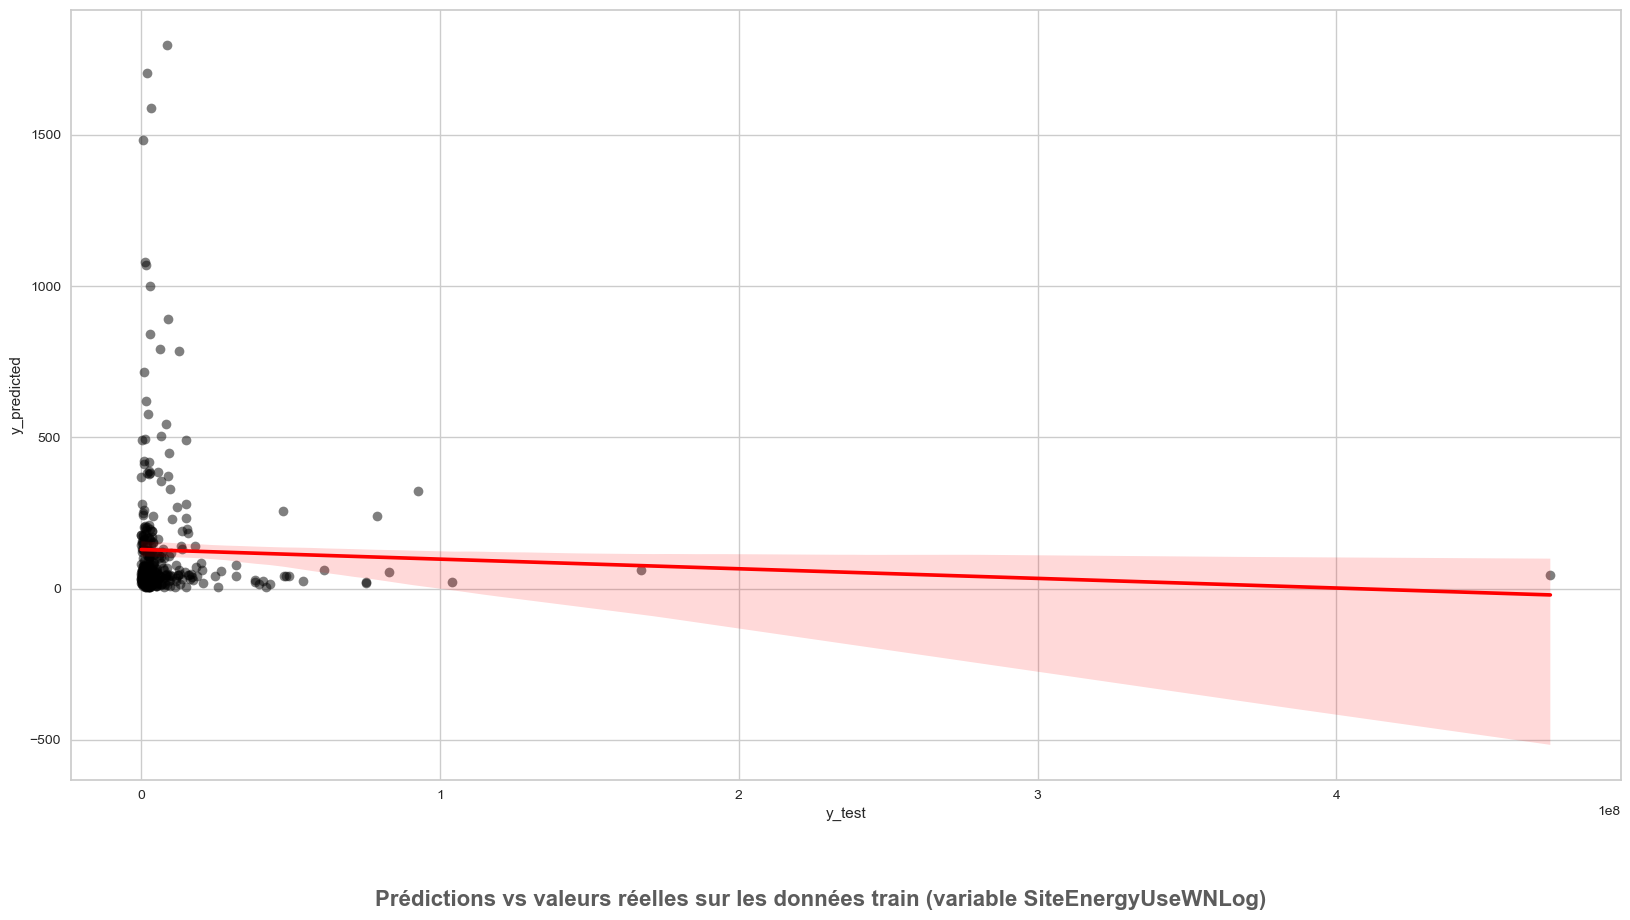

In [123]:
y_test_pred_s = y_test_pred['TotalGHGEmissionsLog'].squeeze() 
# Visualisation des prédictions / valeurs réélles du jeu de test en log
fig = plt.figure(figsize=(20, 10))
plt.scatter(y_test_log, y_test_pred_s)
fig.suptitle('y_test versus y_test_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_test_pred', fontsize=16)

test = (10 ** y_test_log) + 1
predict = (10 **y_test_pred_s) + 1

# Visualisation des prédictions / valeurs réélles du jeu de test non transformé en log
fig = plt.figure(figsize=(20, 10))

sns.regplot(x = test , y = predict,
                scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})
        
plt.xlabel('y_test')
plt.ylabel('y_predicted')
plt.suptitle(t='Prédictions vs valeurs réelles sur les données train (variable ''SiteEnergyUseWNLog'')',
               y=0,
               fontsize=16,
               alpha=0.75,
               weight='bold',
               ha='center')
plt.show()

